In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/COSE474/FinalProject/20242R0136COSE47402/FinalProject

/content/drive/MyDrive/Colab Notebooks/COSE474/FinalProject/20242R0136COSE47402/FinalProject


In [3]:
ls

captions_val2017.json  instances_val2017.json  self_attention_layer1_forward.py  TestCode.ipynb


# Preparation

In [4]:
import json
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

##Loading CLIP model
Training 없이 모델 구조 기반의 inference 실험을 할 것이기에 가장 작은 모델 사용.
CLIP 자체로는 이미지 caption을 생성하지 않기에 image captioning model을 추가로 사용.

In [5]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel, VisionEncoderDecoderModel, AutoTokenizer

# Load the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Load the image captioning model
caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
caption_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

## Fetching Cat and Dog images from MSCOCO dataset
instances_val2027.json으로부터 얻은 강아지와 고양이의 id로 강아지와 고양이 이미지만 뽑기

In [6]:
## fetch cat&dog images from MSCOCO
mscoco_instances_path = "instances_val2017.json"
mscoco_captions_path = "captions_val2017.json"

# 강아지와 고양이의 category_id
target_categories = {17: "cat", 18: "dog"}

# 필터링된 이미지 ID 저장
target_image_ids = set()

# Load instances JSON to filter images
with open(mscoco_instances_path, "r") as f:
    instances_data = json.load(f)

# Annotation에서 강아지와 고양이가 포함된 이미지 필터링
for annotation in instances_data["annotations"]:
    if annotation["category_id"] in target_categories:
        target_image_ids.add(annotation["image_id"])

total_images = len(target_image_ids)
print(f"Number of images with cats or dogs: {total_images}")

# Load captions JSON
with open(mscoco_captions_path, "r") as f:
    captions_data = json.load(f)

# Extract image and caption information
images_info = {img["id"]: img for img in captions_data["images"]}
annotations = captions_data["annotations"]

# Group captions by image ID
captions_by_image = {}
for ann in annotations:
    if ann["image_id"] in target_image_ids:  # Filter only target image IDs
        captions_by_image.setdefault(ann["image_id"], []).append(ann["caption"])
# print(captions_by_image)

Number of images with cats or dogs: 349


#**Original CLIP**


### MSCOCO Dataset 결과

In [7]:
from tqdm import tqdm

# Initialize variables for average score calculation
total_similarity_score = 0.0
processed_images = 0
# num_images = 50  # Number of images to process (adjust as needed)
num_images = total_images

# Candidate captions
candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of a bird", "a photo of a car"]
# candidate_captions = ["a photo of a white cat", "a photo of a black cat", "a photo of a white dog", "a photo of a black dog","a photo of an animal"]

# Loop through filtered images
for image_id, captions in tqdm(list(captions_by_image.items())[:num_images]):
    # Load image from URL
    image_url = images_info[image_id]["coco_url"]
    print(image_url)
    image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

    # plt.imshow(image)
    # plt.title(f"Image ID: {image_id}")
    # plt.axis("off")
    # plt.show()

    # CLIP score for candidate captions
    inputs = clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)

    # Compute similarity scores
    logits_per_image = outputs.logits_per_image
    print(logits_per_image)
    probs = logits_per_image.softmax(dim=1)
    best_caption_index = torch.argmax(probs).item()
    best_caption = candidate_captions[best_caption_index]
    print(f"Best caption by CLIP for image {image_id}: {best_caption}")

    # # Calculate CLIP similarity score for best caption
    # pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
    # image_features = clip_model.get_image_features(pixel_values)

    # text_inputs = clip_processor(text=[best_caption], return_tensors="pt", padding=True)
    # text_features = clip_model.get_text_features(**text_inputs)

    # # Normalize embeddings
    # image_features = F.normalize(image_features, p=2, dim=1)
    # text_features = F.normalize(text_features, p=2, dim=1)

    # # Cosine similarity
    # similarity_score = (image_features @ text_features.T).item()
    # print(f"CLIP Similarity Score for image {image_id}: {similarity_score}")

    # Generate a detailed caption using the captioning model
    pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
    attention_mask = torch.ones(pixel_values.shape[:2], dtype=torch.long)

    generated_ids = caption_model.generate(
        pixel_values,
        attention_mask=attention_mask,  # Explicitly pass the attention mask
        max_length=50,                 # Set a custom maximum length for the output
        pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
    )
    generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption: {generated_caption}")

    # CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
    best_caption = candidate_captions[best_caption_index]
    input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

    generated_ids = caption_model.generate(
        pixel_values,
        input_ids=input_ids,  # CLIP의 Best Caption 반영
        attention_mask=attention_mask,
        max_length=50,
        pad_token_id=caption_tokenizer.pad_token_id
    )
    generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption with CLIP influence: {generated_caption}\n")

    # Calculate CLIP similarity score for generated caption with clip influence
    pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
    image_features = clip_model.get_image_features(pixel_values)

    text_inputs = clip_processor(text=[generated_caption], return_tensors="pt", padding=True)
    text_features = clip_model.get_text_features(**text_inputs)

    # Normalize embeddings
    image_features = F.normalize(image_features, p=2, dim=1)
    text_features = F.normalize(text_features, p=2, dim=1)

    # Cosine similarity
    similarity_score = (image_features @ text_features.T).item()
    print(f"CLIP Similarity Score for image {image_id}: {similarity_score}")


    # Update total score and processed image count
    total_similarity_score += similarity_score
    processed_images += 1

# Calculate and print the average CLIP similarity score
average_similarity_score = total_similarity_score / processed_images
print(f"\nAverage CLIP Similarity Score for {processed_images} images: {average_similarity_score}")


  0%|          | 0/349 [00:00<?, ?it/s]

http://images.cocodataset.org/val2017/000000046378.jpg


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


tensor([[27.1647, 21.2905, 25.7971, 20.3364]], grad_fn=<TBackward0>)
Best caption by CLIP for image 46378: a photo of a cat
Generated Caption: a cat with a bite out of it's mouth 


  0%|          | 1/349 [00:02<11:50,  2.04s/it]

Generated Caption with CLIP influence: a photo of a cat with a bite out of it 

CLIP Similarity Score for image 46378: 0.28870147466659546
http://images.cocodataset.org/val2017/000000172330.jpg
tensor([[27.8398, 22.3475, 21.1272, 25.0792]], grad_fn=<TBackward0>)
Best caption by CLIP for image 172330: a photo of a cat
Generated Caption: a cat standing on the side of a road 


  1%|          | 2/349 [00:03<10:18,  1.78s/it]

Generated Caption with CLIP influence: a photo of a cat standing on the sidewalk 

CLIP Similarity Score for image 172330: 0.28662464022636414
http://images.cocodataset.org/val2017/000000223747.jpg
tensor([[25.6788, 20.8276, 20.1105, 18.6999]], grad_fn=<TBackward0>)
Best caption by CLIP for image 223747: a photo of a cat
Generated Caption: a person laying on a bed with a blanket 


  1%|          | 3/349 [00:04<09:05,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat sleeping on a blanket 

CLIP Similarity Score for image 223747: 0.26075056195259094
http://images.cocodataset.org/val2017/000000482917.jpg
tensor([[19.2966, 24.3990, 18.5056, 17.7371]], grad_fn=<TBackward0>)
Best caption by CLIP for image 482917: a photo of a dog
Generated Caption: a person laying on the floor with a cat 


  1%|          | 4/349 [00:06<08:50,  1.54s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a couch 

CLIP Similarity Score for image 482917: 0.24818943440914154
http://images.cocodataset.org/val2017/000000065485.jpg
tensor([[22.3763, 23.8554, 21.2655, 25.9772]], grad_fn=<TBackward0>)
Best caption by CLIP for image 65485: a photo of a car
Generated Caption: a red truck parked in a parking lot 


  1%|▏         | 5/349 [00:07<08:46,  1.53s/it]

Generated Caption with CLIP influence: a photo of a car with a red and white truck 

CLIP Similarity Score for image 65485: 0.24997827410697937
http://images.cocodataset.org/val2017/000000255965.jpg
tensor([[28.2140, 21.2175, 21.1200, 19.6218]], grad_fn=<TBackward0>)
Best caption by CLIP for image 255965: a photo of a cat
Generated Caption: a cat sitting on a ledge looking at the camera 


  2%|▏         | 6/349 [00:09<09:35,  1.68s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a ledge 

CLIP Similarity Score for image 255965: 0.28217875957489014
http://images.cocodataset.org/val2017/000000010363.jpg
tensor([[25.7040, 19.7851, 19.3076, 26.1214]], grad_fn=<TBackward0>)
Best caption by CLIP for image 10363: a photo of a car
Generated Caption: a cat sitting on top of a car hood 


  2%|▏         | 7/349 [00:11<09:32,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 10363: 0.3113110661506653
http://images.cocodataset.org/val2017/000000558073.jpg
tensor([[27.4564, 20.7561, 21.1311, 19.5326]], grad_fn=<TBackward0>)
Best caption by CLIP for image 558073: a photo of a cat
Generated Caption: a cat sitting on a wall next to a window 


  2%|▏         | 8/349 [00:13<09:05,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a wall 

CLIP Similarity Score for image 558073: 0.2828425168991089
http://images.cocodataset.org/val2017/000000565391.jpg
tensor([[25.6473, 23.2969, 20.6537, 27.4147]], grad_fn=<TBackward0>)
Best caption by CLIP for image 565391: a photo of a car
Generated Caption: a black and white bird is sitting on a car 


  3%|▎         | 9/349 [00:14<09:02,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a bird on the hood 

CLIP Similarity Score for image 565391: 0.27331575751304626
http://images.cocodataset.org/val2017/000000304560.jpg
tensor([[28.9066, 21.9899, 21.9246, 20.5639]], grad_fn=<TBackward0>)
Best caption by CLIP for image 304560: a photo of a cat
Generated Caption: a cat sitting in the grass looking at the camera 


  3%|▎         | 10/349 [00:16<09:04,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat sitting in the grass 

CLIP Similarity Score for image 304560: 0.2950246334075928
http://images.cocodataset.org/val2017/000000153217.jpg
tensor([[26.2469, 21.2999, 20.7917, 22.5804]], grad_fn=<TBackward0>)
Best caption by CLIP for image 153217: a photo of a cat
Generated Caption: a black dog is running on a leash 


  3%|▎         | 11/349 [00:17<08:38,  1.53s/it]

Generated Caption with CLIP influence: a photo of a cat on a motorcycle 

CLIP Similarity Score for image 153217: 0.35492998361587524
http://images.cocodataset.org/val2017/000000209747.jpg
tensor([[28.7438, 22.3337, 21.8336, 20.2948]], grad_fn=<TBackward0>)
Best caption by CLIP for image 209747: a photo of a cat
Generated Caption: a cat sitting in a sink with a toothbrush in it's mouth 


  3%|▎         | 12/349 [00:19<08:39,  1.54s/it]

Generated Caption with CLIP influence: a photo of a cat in a sink 

CLIP Similarity Score for image 209747: 0.3003822863101959
http://images.cocodataset.org/val2017/000000134096.jpg
tensor([[26.9347, 19.9099, 21.1949, 17.3799]], grad_fn=<TBackward0>)
Best caption by CLIP for image 134096: a photo of a cat
Generated Caption: a cat sitting on a sink in a bathroom 


  4%|▎         | 13/349 [00:20<08:32,  1.53s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a sink 

CLIP Similarity Score for image 134096: 0.31705912947654724
http://images.cocodataset.org/val2017/000000163155.jpg
tensor([[28.0319, 21.8981, 22.1978, 20.1267]], grad_fn=<TBackward0>)
Best caption by CLIP for image 163155: a photo of a cat
Generated Caption: a cat sitting on a wooden bench 


  4%|▍         | 14/349 [00:22<09:09,  1.64s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a wooden bench 

CLIP Similarity Score for image 163155: 0.2967631220817566
http://images.cocodataset.org/val2017/000000360943.jpg
tensor([[28.2885, 22.5454, 22.2238, 21.5301]], grad_fn=<TBackward0>)
Best caption by CLIP for image 360943: a photo of a cat
Generated Caption: a cat sitting on a window sill looking out 


  4%|▍         | 15/349 [00:24<08:59,  1.62s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a window sill 

CLIP Similarity Score for image 360943: 0.3198605477809906
http://images.cocodataset.org/val2017/000000284623.jpg
tensor([[26.8981, 20.7666, 20.4656, 18.3180]], grad_fn=<TBackward0>)
Best caption by CLIP for image 284623: a photo of a cat
Generated Caption: a cat sitting on a sink next to a mirror 


  5%|▍         | 16/349 [00:25<09:00,  1.62s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a sink 

CLIP Similarity Score for image 284623: 0.2909753918647766
http://images.cocodataset.org/val2017/000000554002.jpg
tensor([[20.7786, 26.5601, 20.1653, 19.3836]], grad_fn=<TBackward0>)
Best caption by CLIP for image 554002: a photo of a dog
Generated Caption: a woman walking down a sidewalk with a dog 


  5%|▍         | 17/349 [00:27<09:03,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog and a woman walking on a sidewalk 

CLIP Similarity Score for image 554002: 0.2853633463382721
http://images.cocodataset.org/val2017/000000023272.jpg
tensor([[25.3348, 19.6787, 20.7832, 27.6003]], grad_fn=<TBackward0>)
Best caption by CLIP for image 23272: a photo of a car
Generated Caption: a dog is sitting on the hood of a car 


  5%|▌         | 18/349 [00:29<08:57,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the hood 

CLIP Similarity Score for image 23272: 0.30087584257125854
http://images.cocodataset.org/val2017/000000067213.jpg
tensor([[18.1208, 24.4022, 18.2142, 20.1146]], grad_fn=<TBackward0>)
Best caption by CLIP for image 67213: a photo of a dog
Generated Caption: a dog jumping in the air over a swimming pool 


  5%|▌         | 19/349 [00:30<08:53,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog jumping in the air 

CLIP Similarity Score for image 67213: 0.32770514488220215
http://images.cocodataset.org/val2017/000000170893.jpg
tensor([[22.2117, 28.1660, 21.9364, 18.9100]], grad_fn=<TBackward0>)
Best caption by CLIP for image 170893: a photo of a dog
Generated Caption: a dog is sitting on the toilet in the bathroom 


  6%|▌         | 20/349 [00:32<08:36,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog in a bathroom 

CLIP Similarity Score for image 170893: 0.32273128628730774
http://images.cocodataset.org/val2017/000000107087.jpg
tensor([[27.7822, 21.2467, 21.9360, 26.5736]], grad_fn=<TBackward0>)
Best caption by CLIP for image 107087: a photo of a cat
Generated Caption: a cat sitting in the hood of a car 


  6%|▌         | 21/349 [00:33<08:28,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat sitting in a car window 

CLIP Similarity Score for image 107087: 0.35280799865722656
http://images.cocodataset.org/val2017/000000366884.jpg
tensor([[22.3151, 23.6026, 20.7662, 20.2871]], grad_fn=<TBackward0>)
Best caption by CLIP for image 366884: a photo of a dog
Generated Caption: a cat is sitting on a rug in a room 


  6%|▋         | 22/349 [00:35<08:57,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a bed 

CLIP Similarity Score for image 366884: 0.237894669175148
http://images.cocodataset.org/val2017/000000139099.jpg
tensor([[20.8217, 22.2808, 18.5894, 22.7461]], grad_fn=<TBackward0>)
Best caption by CLIP for image 139099: a photo of a car
Generated Caption: a man in a hat is on a bike 


  7%|▋         | 23/349 [00:37<08:52,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with people on it 

CLIP Similarity Score for image 139099: 0.23479725420475006
http://images.cocodataset.org/val2017/000000404484.jpg
tensor([[20.9305, 24.9304, 19.6680, 18.0982]], grad_fn=<TBackward0>)
Best caption by CLIP for image 404484: a photo of a dog
Generated Caption: a dog standing on a rug in front of a window 


  7%|▋         | 24/349 [00:38<08:40,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog standing on a rug 

CLIP Similarity Score for image 404484: 0.25341299176216125
http://images.cocodataset.org/val2017/000000227044.jpg
tensor([[27.9679, 20.9625, 20.3563, 18.1515]], grad_fn=<TBackward0>)
Best caption by CLIP for image 227044: a photo of a cat
Generated Caption: a cat sitting on a sink in a bathroom 


  7%|▋         | 25/349 [00:40<08:36,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a sink 

CLIP Similarity Score for image 227044: 0.3118378221988678
http://images.cocodataset.org/val2017/000000472375.jpg
tensor([[17.6772, 23.0884, 16.4206, 19.8669]], grad_fn=<TBackward0>)
Best caption by CLIP for image 472375: a photo of a dog
Generated Caption: a dog is sitting on a motorcycle 


  7%|▋         | 26/349 [00:41<08:14,  1.53s/it]

Generated Caption with CLIP influence: a photo of a dog on a motorcycle 

CLIP Similarity Score for image 472375: 0.3158929646015167
http://images.cocodataset.org/val2017/000000101762.jpg
tensor([[26.1958, 21.5026, 20.7444, 20.8357]], grad_fn=<TBackward0>)
Best caption by CLIP for image 101762: a photo of a cat
Generated Caption: a cat is standing on a bicycle tire 


  8%|▊         | 27/349 [00:43<08:12,  1.53s/it]

Generated Caption with CLIP influence: a photo of a cat and a bicycle 

CLIP Similarity Score for image 101762: 0.33773496747016907
http://images.cocodataset.org/val2017/000000419974.jpg
tensor([[20.9023, 23.7031, 20.9684, 16.8877]], grad_fn=<TBackward0>)
Best caption by CLIP for image 419974: a photo of a dog
Generated Caption: a man in a kitchen cutting a cake 


  8%|▊         | 28/349 [00:44<08:03,  1.51s/it]

Generated Caption with CLIP influence: a photo of a dog in a kitchen 

CLIP Similarity Score for image 419974: 0.30645182728767395
http://images.cocodataset.org/val2017/000000167122.jpg
tensor([[24.1445, 21.9116, 22.4332, 26.3843]], grad_fn=<TBackward0>)
Best caption by CLIP for image 167122: a photo of a car
Generated Caption: a car is driving down a street at night 


  8%|▊         | 29/349 [00:46<08:01,  1.51s/it]

Generated Caption with CLIP influence: a photo of a car on a street at night 

CLIP Similarity Score for image 167122: 0.2832256257534027
http://images.cocodataset.org/val2017/000000365207.jpg
tensor([[21.3035, 23.0956, 27.5447, 26.5845]], grad_fn=<TBackward0>)
Best caption by CLIP for image 365207: a photo of a bird
Generated Caption: a mirror reflecting a car's reflection in the side view mirror 


  9%|▊         | 30/349 [00:48<09:11,  1.73s/it]

Generated Caption with CLIP influence: a photo of a bird in the side mirror of a car 

CLIP Similarity Score for image 365207: 0.3765977621078491
http://images.cocodataset.org/val2017/000000209613.jpg
tensor([[18.7630, 22.3709, 18.9988, 19.2622]], grad_fn=<TBackward0>)
Best caption by CLIP for image 209613: a photo of a dog
Generated Caption: sheep standing on top of a grass covered field 


  9%|▉         | 31/349 [00:50<09:13,  1.74s/it]

Generated Caption with CLIP influence: a photo of a dog and sheep standing on a hillside 

CLIP Similarity Score for image 209613: 0.30711913108825684
http://images.cocodataset.org/val2017/000000386457.jpg
tensor([[26.9079, 21.0494, 20.1394, 18.2191]], grad_fn=<TBackward0>)
Best caption by CLIP for image 386457: a photo of a cat
Generated Caption: a cat looking out of a window 


  9%|▉         | 32/349 [00:51<08:44,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat looking through a door 

CLIP Similarity Score for image 386457: 0.30645328760147095
http://images.cocodataset.org/val2017/000000077396.jpg
tensor([[25.4239, 19.3640, 18.4102, 18.5086]], grad_fn=<TBackward0>)
Best caption by CLIP for image 77396: a photo of a cat
Generated Caption: a cat is watching a television on the floor 


  9%|▉         | 33/349 [00:53<08:30,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat playing with a television 

CLIP Similarity Score for image 77396: 0.3452642261981964
http://images.cocodataset.org/val2017/000000312340.jpg
tensor([[28.1087, 21.2831, 22.5913, 20.4599]], grad_fn=<TBackward0>)
Best caption by CLIP for image 312340: a photo of a cat
Generated Caption: a cat sitting in a tree with a window 


 10%|▉         | 34/349 [00:54<08:18,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat sitting in a tree 

CLIP Similarity Score for image 312340: 0.25167208909988403
http://images.cocodataset.org/val2017/000000530099.jpg
tensor([[26.2780, 19.3834, 20.0461, 25.3296]], grad_fn=<TBackward0>)
Best caption by CLIP for image 530099: a photo of a cat
Generated Caption: a cat sitting on a car window sill 


 10%|█         | 35/349 [00:55<08:00,  1.53s/it]

Generated Caption with CLIP influence: a photo of a cat on a car window 

CLIP Similarity Score for image 530099: 0.33628931641578674
http://images.cocodataset.org/val2017/000000149222.jpg
tensor([[20.8944, 19.9914, 20.4689, 20.0148]], grad_fn=<TBackward0>)
Best caption by CLIP for image 149222: a photo of a cat
Generated Caption: a computer monitor and keyboard on a desk 


 10%|█         | 36/349 [00:57<07:36,  1.46s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a desk 

CLIP Similarity Score for image 149222: 0.24378712475299835
http://images.cocodataset.org/val2017/000000329219.jpg
tensor([[23.3190, 26.7926, 20.1866, 17.3004]], grad_fn=<TBackward0>)
Best caption by CLIP for image 329219: a photo of a dog
Generated Caption: a man standing next to a dog on a kitchen floor 


 11%|█         | 37/349 [00:58<07:55,  1.52s/it]

Generated Caption with CLIP influence: a photo of a dog standing on a kitchen floor 

CLIP Similarity Score for image 329219: 0.3382919728755951
http://images.cocodataset.org/val2017/000000245764.jpg
tensor([[27.5269, 21.4803, 21.5291, 18.5096]], grad_fn=<TBackward0>)
Best caption by CLIP for image 245764: a photo of a cat
Generated Caption: a cat is sitting on a toilet seat 


 11%|█         | 38/349 [01:00<08:28,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a toilet seat 

CLIP Similarity Score for image 245764: 0.331254780292511
http://images.cocodataset.org/val2017/000000131273.jpg
tensor([[19.1434, 25.6507, 18.5525, 22.2046]], grad_fn=<TBackward0>)
Best caption by CLIP for image 131273: a photo of a dog
Generated Caption: a dog sitting in the driver's seat of a car 


 11%|█         | 39/349 [01:02<08:26,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog sitting in a car 

CLIP Similarity Score for image 131273: 0.2939833402633667
http://images.cocodataset.org/val2017/000000169076.jpg
tensor([[20.8876, 22.4029, 17.7046, 18.4235]], grad_fn=<TBackward0>)
Best caption by CLIP for image 169076: a photo of a dog
Generated Caption: a black and white dog looking at a tv 


 11%|█▏        | 40/349 [01:03<08:13,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog looking at a tv 

CLIP Similarity Score for image 169076: 0.2954634428024292
http://images.cocodataset.org/val2017/000000466156.jpg
tensor([[27.0204, 20.1705, 20.2530, 26.5173]], grad_fn=<TBackward0>)
Best caption by CLIP for image 466156: a photo of a cat
Generated Caption: a cat standing on top of a car hood 


 12%|█▏        | 41/349 [01:05<08:02,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat on a car hood 

CLIP Similarity Score for image 466156: 0.3059234321117401
http://images.cocodataset.org/val2017/000000279278.jpg
tensor([[20.2024, 22.7803, 21.9742, 22.7798]], grad_fn=<TBackward0>)
Best caption by CLIP for image 279278: a photo of a dog
Generated Caption: a woman is standing on a skateboard with a skateboard 


 12%|█▏        | 42/349 [01:07<08:06,  1.58s/it]

Generated Caption with CLIP influence: a photo of a dog on a skateboard 

CLIP Similarity Score for image 279278: 0.30676957964897156
http://images.cocodataset.org/val2017/000000579321.jpg
tensor([[20.4667, 25.9592, 20.7453, 18.0927]], grad_fn=<TBackward0>)
Best caption by CLIP for image 579321: a photo of a dog
Generated Caption: a dog laying on the ground with its head on a person's shoulder 


 12%|█▏        | 43/349 [01:08<08:20,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog laying on the ground 

CLIP Similarity Score for image 579321: 0.29131466150283813
http://images.cocodataset.org/val2017/000000289343.jpg
tensor([[23.8884, 24.7396, 22.3759, 21.5734]], grad_fn=<TBackward0>)
Best caption by CLIP for image 289343: a photo of a dog
Generated Caption: a man riding a skateboard down a sidewalk 


 13%|█▎        | 44/349 [01:10<08:10,  1.61s/it]

Generated Caption with CLIP influence: a photo of a dog riding a skateboard 

CLIP Similarity Score for image 289343: 0.27582019567489624
http://images.cocodataset.org/val2017/000000498286.jpg
tensor([[19.8029, 26.8042, 20.4144, 19.7197]], grad_fn=<TBackward0>)
Best caption by CLIP for image 498286: a photo of a dog
Generated Caption: a dog with a tag on its face 


 13%|█▎        | 45/349 [01:12<08:38,  1.70s/it]

Generated Caption with CLIP influence: a photo of a dog with a tag on it 

CLIP Similarity Score for image 498286: 0.2566929757595062
http://images.cocodataset.org/val2017/000000494869.jpg
tensor([[21.4189, 23.5108, 19.7257, 17.8360]], grad_fn=<TBackward0>)
Best caption by CLIP for image 494869: a photo of a dog
Generated Caption: a woman and a child are in a kitchen 


 13%|█▎        | 46/349 [01:14<09:03,  1.79s/it]

Generated Caption with CLIP influence: a photo of a dog and a woman in a kitchen 

CLIP Similarity Score for image 494869: 0.3451197147369385
http://images.cocodataset.org/val2017/000000129756.jpg
tensor([[18.6481, 24.0343, 18.5494, 17.6865]], grad_fn=<TBackward0>)
Best caption by CLIP for image 129756: a photo of a dog
Generated Caption: a man standing in a field with sheep 


 13%|█▎        | 47/349 [01:15<08:49,  1.75s/it]

Generated Caption with CLIP influence: a photo of a dog and a man standing in a field 

CLIP Similarity Score for image 129756: 0.316526859998703
http://images.cocodataset.org/val2017/000000568690.jpg
tensor([[28.1272, 22.1774, 22.6885, 18.8410]], grad_fn=<TBackward0>)
Best caption by CLIP for image 568690: a photo of a cat
Generated Caption: a cat sitting on top of a toilet bowl 


 14%|█▍        | 48/349 [01:17<08:23,  1.67s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a toilet 

CLIP Similarity Score for image 568690: 0.34478387236595154
http://images.cocodataset.org/val2017/000000061471.jpg
tensor([[22.0624, 26.6198, 19.5719, 17.0698]], grad_fn=<TBackward0>)
Best caption by CLIP for image 61471: a photo of a dog
Generated Caption: a dog is standing in the bathroom with its mouth open 


 14%|█▍        | 49/349 [01:19<08:14,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog in a bathroom 

CLIP Similarity Score for image 61471: 0.32176893949508667
http://images.cocodataset.org/val2017/000000047121.jpg
tensor([[25.3859, 20.3359, 19.5930, 15.8769]], grad_fn=<TBackward0>)
Best caption by CLIP for image 47121: a photo of a cat
Generated Caption: a cat drinking water from a sink 


 14%|█▍        | 50/349 [01:20<07:59,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat drinking water from a faucet 

CLIP Similarity Score for image 47121: 0.3544974625110626
http://images.cocodataset.org/val2017/000000007386.jpg
tensor([[19.8024, 22.6190, 19.0395, 23.5750]], grad_fn=<TBackward0>)
Best caption by CLIP for image 7386: a photo of a car
Generated Caption: a motorcycle with a dog on it 


 15%|█▍        | 51/349 [01:22<07:51,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a motorcycle on it 

CLIP Similarity Score for image 7386: 0.2785927355289459
http://images.cocodataset.org/val2017/000000267300.jpg
tensor([[18.0333, 24.4604, 18.9438, 17.2763]], grad_fn=<TBackward0>)
Best caption by CLIP for image 267300: a photo of a dog
Generated Caption: a dog laying on a bed with a plate of food 


 15%|█▍        | 52/349 [01:23<07:56,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 267300: 0.261127233505249
http://images.cocodataset.org/val2017/000000327769.jpg
tensor([[28.3038, 22.0456, 21.3527, 19.1429]], grad_fn=<TBackward0>)
Best caption by CLIP for image 327769: a photo of a cat
Generated Caption: a cat laying in a bathroom sink 


 15%|█▌        | 53/349 [01:25<08:11,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat in a bathroom sink 

CLIP Similarity Score for image 327769: 0.345694363117218
http://images.cocodataset.org/val2017/000000176778.jpg
tensor([[17.5528, 16.4859, 16.6052, 15.0838]], grad_fn=<TBackward0>)
Best caption by CLIP for image 176778: a photo of a cat
Generated Caption: a white toilet sitting next to a bath tub 


 15%|█▌        | 54/349 [01:27<08:24,  1.71s/it]

Generated Caption with CLIP influence: a photo of a cat sitting in a bath tub 

CLIP Similarity Score for image 176778: 0.23207981884479523
http://images.cocodataset.org/val2017/000000260925.jpg
tensor([[26.2324, 20.0108, 19.2764, 26.4745]], grad_fn=<TBackward0>)
Best caption by CLIP for image 260925: a photo of a car
Generated Caption: a cat is laying on the hood of a car 


 16%|█▌        | 55/349 [01:28<08:16,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 260925: 0.3044099807739258
http://images.cocodataset.org/val2017/000000520301.jpg
tensor([[20.4710, 26.9510, 20.5821, 23.3196]], grad_fn=<TBackward0>)
Best caption by CLIP for image 520301: a photo of a dog
Generated Caption: a dog is sitting in the window of a car 


 16%|█▌        | 56/349 [01:30<07:53,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog on a bus 

CLIP Similarity Score for image 520301: 0.307598739862442
http://images.cocodataset.org/val2017/000000205834.jpg
tensor([[20.5231, 27.7421, 20.1056, 19.3666]], grad_fn=<TBackward0>)
Best caption by CLIP for image 205834: a photo of a dog
Generated Caption: a dog is sitting in the dirt with a bowl 


 16%|█▋        | 57/349 [01:31<07:46,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog sitting in the dirt 

CLIP Similarity Score for image 205834: 0.2764361798763275
http://images.cocodataset.org/val2017/000000491216.jpg
tensor([[27.2894, 25.2683, 21.6113, 19.2554]], grad_fn=<TBackward0>)
Best caption by CLIP for image 491216: a photo of a cat
Generated Caption: a cat is standing on the floor in a kitchen 


 17%|█▋        | 58/349 [01:33<07:30,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat in a kitchen 

CLIP Similarity Score for image 491216: 0.3428416848182678
http://images.cocodataset.org/val2017/000000109055.jpg
tensor([[26.5862, 21.4728, 20.8868, 21.6899]], grad_fn=<TBackward0>)
Best caption by CLIP for image 109055: a photo of a cat
Generated Caption: a cat is standing on a bicycle 


 17%|█▋        | 59/349 [01:34<07:15,  1.50s/it]

Generated Caption with CLIP influence: a photo of a cat on a bicycle 

CLIP Similarity Score for image 109055: 0.345462441444397
http://images.cocodataset.org/val2017/000000501523.jpg
tensor([[28.3372, 21.9777, 21.4012, 19.3327]], grad_fn=<TBackward0>)
Best caption by CLIP for image 501523: a photo of a cat
Generated Caption: a cat is sitting in a bathroom sink 


 17%|█▋        | 60/349 [01:36<07:07,  1.48s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a sink 

CLIP Similarity Score for image 501523: 0.3339810073375702
http://images.cocodataset.org/val2017/000000125850.jpg
tensor([[27.2066, 21.6479, 19.5877, 20.7649]], grad_fn=<TBackward0>)
Best caption by CLIP for image 125850: a photo of a cat
Generated Caption: a cat laying in a bowl on a table 


 17%|█▋        | 61/349 [01:37<07:23,  1.54s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bowl 

CLIP Similarity Score for image 125850: 0.33204010128974915
http://images.cocodataset.org/val2017/000000213445.jpg
tensor([[27.6686, 21.5063, 21.0871, 19.0672]], grad_fn=<TBackward0>)
Best caption by CLIP for image 213445: a photo of a cat
Generated Caption: a cat sitting on a table in a room 


 18%|█▊        | 62/349 [01:39<08:00,  1.67s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a table 

CLIP Similarity Score for image 213445: 0.3018765449523926
http://images.cocodataset.org/val2017/000000466339.jpg
tensor([[21.6656, 21.5137, 20.8571, 19.5698]], grad_fn=<TBackward0>)
Best caption by CLIP for image 466339: a photo of a cat
Generated Caption: a door is open to a room with a wooden floor 


 18%|█▊        | 63/349 [01:41<08:12,  1.72s/it]

Generated Caption with CLIP influence: a photo of a cat standing in a doorway 

CLIP Similarity Score for image 466339: 0.26316142082214355
http://images.cocodataset.org/val2017/000000456292.jpg
tensor([[25.2134, 24.0728, 22.9028, 20.4290]], grad_fn=<TBackward0>)
Best caption by CLIP for image 456292: a photo of a cat
Generated Caption: a cat standing on a wall next to a graffiti covered wall 


 18%|█▊        | 64/349 [01:43<08:10,  1.72s/it]

Generated Caption with CLIP influence: a photo of a cat standing on a wall 

CLIP Similarity Score for image 456292: 0.2675565779209137
http://images.cocodataset.org/val2017/000000225184.jpg
tensor([[19.9464, 25.6293, 19.3498, 18.4023]], grad_fn=<TBackward0>)
Best caption by CLIP for image 225184: a photo of a dog
Generated Caption: a herd of sheep standing on top of a lush green field 


 19%|█▊        | 65/349 [01:45<08:07,  1.72s/it]

Generated Caption with CLIP influence: a photo of a dog and sheep in a field 

CLIP Similarity Score for image 225184: 0.3313955068588257
http://images.cocodataset.org/val2017/000000176857.jpg
tensor([[26.1150, 21.0618, 19.8976, 17.7752]], grad_fn=<TBackward0>)
Best caption by CLIP for image 176857: a photo of a cat
Generated Caption: a woman is sitting on a bench in a museum 


 19%|█▉        | 66/349 [01:46<07:48,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a table 

CLIP Similarity Score for image 176857: 0.2871533930301666
http://images.cocodataset.org/val2017/000000402473.jpg
tensor([[25.7593, 18.6877, 18.8386, 18.4346]], grad_fn=<TBackward0>)
Best caption by CLIP for image 402473: a photo of a cat
Generated Caption: a cat laying on a wall next to a cat 


 19%|█▉        | 67/349 [01:48<07:40,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat and a cat laying on a wall 

CLIP Similarity Score for image 402473: 0.30476149916648865
http://images.cocodataset.org/val2017/000000211042.jpg
tensor([[26.5113, 20.8748, 21.6442, 17.1526]], grad_fn=<TBackward0>)
Best caption by CLIP for image 211042: a photo of a cat
Generated Caption: a cat standing on a toilet in a bathroom 


 19%|█▉        | 68/349 [01:49<07:28,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a toilet 

CLIP Similarity Score for image 211042: 0.3099185526371002
http://images.cocodataset.org/val2017/000000361621.jpg
tensor([[28.1833, 22.5058, 22.1165, 19.8625]], grad_fn=<TBackward0>)
Best caption by CLIP for image 361621: a photo of a cat
Generated Caption: a cat is looking at the camera 


 20%|█▉        | 69/349 [01:51<07:17,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat with a cat face 

CLIP Similarity Score for image 361621: 0.2788461744785309
http://images.cocodataset.org/val2017/000000078823.jpg
tensor([[21.2651, 26.8026, 20.6323, 25.7334]], grad_fn=<TBackward0>)
Best caption by CLIP for image 78823: a photo of a dog
Generated Caption: a dog sitting on top of a car 


 20%|██        | 70/349 [01:53<07:35,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a car 

CLIP Similarity Score for image 78823: 0.3349987864494324
http://images.cocodataset.org/val2017/000000061108.jpg
tensor([[17.7649, 22.1415, 17.9437, 20.0315]], grad_fn=<TBackward0>)
Best caption by CLIP for image 61108: a photo of a dog
Generated Caption: a bike parked next to a bench 


 20%|██        | 71/349 [01:54<07:17,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a bike 

CLIP Similarity Score for image 61108: 0.30384355783462524
http://images.cocodataset.org/val2017/000000554291.jpg
tensor([[27.1981, 22.5356, 21.3535, 20.9228]], grad_fn=<TBackward0>)
Best caption by CLIP for image 554291: a photo of a cat
Generated Caption: a cat is playing with a toy in a bowl 


 21%|██        | 72/349 [01:55<07:08,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat in a bowl 

CLIP Similarity Score for image 554291: 0.2911188304424286
http://images.cocodataset.org/val2017/000000068078.jpg
tensor([[21.1262, 20.1331, 20.5615, 18.0097]], grad_fn=<TBackward0>)
Best caption by CLIP for image 68078: a photo of a cat
Generated Caption: a bathroom with a sink, toilet and mirror 


 21%|██        | 73/349 [01:57<07:04,  1.54s/it]

Generated Caption with CLIP influence: a photo of a cat sitting in a bathroom sink 

CLIP Similarity Score for image 68078: 0.23462000489234924
http://images.cocodataset.org/val2017/000000424162.jpg
tensor([[18.2865, 24.9599, 18.1972, 21.5413]], grad_fn=<TBackward0>)
Best caption by CLIP for image 424162: a photo of a dog
Generated Caption: a woman riding a bike with a dog on a leash 


 21%|██        | 74/349 [01:59<07:14,  1.58s/it]

Generated Caption with CLIP influence: a photo of a dog and a woman riding a bike 

CLIP Similarity Score for image 424162: 0.341637521982193
http://images.cocodataset.org/val2017/000000157807.jpg
tensor([[27.5537, 20.4546, 20.2361, 17.4095]], grad_fn=<TBackward0>)
Best caption by CLIP for image 157807: a photo of a cat
Generated Caption: a cat standing on top of a toilet bowl 


 21%|██▏       | 75/349 [02:00<07:02,  1.54s/it]

Generated Caption with CLIP influence: a photo of a cat standing on a toilet 

CLIP Similarity Score for image 157807: 0.3587303161621094
http://images.cocodataset.org/val2017/000000060835.jpg
tensor([[20.4175, 24.5423, 21.5427, 17.8367]], grad_fn=<TBackward0>)
Best caption by CLIP for image 60835: a photo of a dog
Generated Caption: a dog is standing in a cage with a fence 


 22%|██▏       | 76/349 [02:02<07:02,  1.55s/it]

Generated Caption with CLIP influence: a photo of a dog in a cage 

CLIP Similarity Score for image 60835: 0.30958133935928345
http://images.cocodataset.org/val2017/000000240940.jpg
tensor([[26.3424, 21.0491, 20.6053, 23.0383]], grad_fn=<TBackward0>)
Best caption by CLIP for image 240940: a photo of a cat
Generated Caption: a cat sitting on the floor watching television 


 22%|██▏       | 77/349 [02:03<07:12,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a rug watching television 

CLIP Similarity Score for image 240940: 0.3194321095943451
http://images.cocodataset.org/val2017/000000118515.jpg
tensor([[28.6044, 22.3098, 21.4719, 20.5310]], grad_fn=<TBackward0>)
Best caption by CLIP for image 118515: a photo of a cat
Generated Caption: a small kitten sitting on a wooden bench 


 22%|██▏       | 78/349 [02:05<07:39,  1.70s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a wooden bench 

CLIP Similarity Score for image 118515: 0.3024660050868988
http://images.cocodataset.org/val2017/000000119233.jpg
tensor([[24.9192, 19.2914, 18.7075, 17.1159]], grad_fn=<TBackward0>)
Best caption by CLIP for image 119233: a photo of a cat
Generated Caption: a cat laying on top of a laptop computer 


 23%|██▎       | 79/349 [02:07<07:20,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a laptop 

CLIP Similarity Score for image 119233: 0.29737651348114014
http://images.cocodataset.org/val2017/000000377575.jpg
tensor([[21.4850, 28.3612, 21.8824, 19.9910]], grad_fn=<TBackward0>)
Best caption by CLIP for image 377575: a photo of a dog
Generated Caption: a dog wearing a santa clause hat 


 23%|██▎       | 80/349 [02:08<07:07,  1.59s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a bear costume 

CLIP Similarity Score for image 377575: 0.24845848977565765
http://images.cocodataset.org/val2017/000000291664.jpg
tensor([[21.2185, 27.7100, 20.1470, 18.7186]], grad_fn=<TBackward0>)
Best caption by CLIP for image 291664: a photo of a dog
Generated Caption: a dog is standing next to a fire hydrant 


 23%|██▎       | 81/349 [02:10<07:16,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog and a fire hydrant 

CLIP Similarity Score for image 291664: 0.35832223296165466
http://images.cocodataset.org/val2017/000000222235.jpg
tensor([[25.8974, 19.2419, 20.9562, 16.8762]], grad_fn=<TBackward0>)
Best caption by CLIP for image 222235: a photo of a cat
Generated Caption: a cat sitting in a tree next to a plant 


 23%|██▎       | 82/349 [02:12<07:10,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat in a garden 

CLIP Similarity Score for image 222235: 0.2969156801700592
http://images.cocodataset.org/val2017/000000117374.jpg
tensor([[26.5312, 21.4150, 26.5785, 20.0646]], grad_fn=<TBackward0>)
Best caption by CLIP for image 117374: a photo of a bird
Generated Caption: a cat is sitting on a tree branch 


 24%|██▍       | 83/349 [02:13<07:04,  1.60s/it]

Generated Caption with CLIP influence: a photo of a bird sitting on a tree branch 

CLIP Similarity Score for image 117374: 0.23678691685199738
http://images.cocodataset.org/val2017/000000080666.jpg
tensor([[28.8879, 21.8815, 21.6326, 20.8872]], grad_fn=<TBackward0>)
Best caption by CLIP for image 80666: a photo of a cat
Generated Caption: a cat sitting on a sidewalk next to a building 


 24%|██▍       | 84/349 [02:15<07:01,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a sidewalk 

CLIP Similarity Score for image 80666: 0.2949102520942688
http://images.cocodataset.org/val2017/000000088951.jpg
tensor([[22.9380, 25.2577, 21.9129, 20.8227]], grad_fn=<TBackward0>)
Best caption by CLIP for image 88951: a photo of a dog
Generated Caption: a man sitting on a bench next to a tree 


 24%|██▍       | 85/349 [02:16<07:12,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a bench 

CLIP Similarity Score for image 88951: 0.300060898065567
http://images.cocodataset.org/val2017/000000117525.jpg
tensor([[19.9764, 24.7558, 20.1685, 18.6517]], grad_fn=<TBackward0>)
Best caption by CLIP for image 117525: a photo of a dog
Generated Caption: a man with a dog wearing a christmas hat 


 25%|██▍       | 86/349 [02:18<07:21,  1.68s/it]

Generated Caption with CLIP influence: a photo of a dog with a christmas hat on 

CLIP Similarity Score for image 117525: 0.2916255593299866
http://images.cocodataset.org/val2017/000000029393.jpg
tensor([[20.3685, 26.5571, 21.4054, 19.4718]], grad_fn=<TBackward0>)
Best caption by CLIP for image 29393: a photo of a dog
Generated Caption: a dog standing on top of a table 


 25%|██▍       | 87/349 [02:20<07:11,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog standing on a ledge 

CLIP Similarity Score for image 29393: 0.30110621452331543
http://images.cocodataset.org/val2017/000000305343.jpg
tensor([[18.6389, 16.5163, 17.4946, 14.7659]], grad_fn=<TBackward0>)
Best caption by CLIP for image 305343: a photo of a cat
Generated Caption: two paintings of a man and a woman 


 25%|██▌       | 88/349 [02:21<06:55,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat and a vase 

CLIP Similarity Score for image 305343: 0.2186172604560852
http://images.cocodataset.org/val2017/000000532530.jpg
tensor([[16.8936, 17.9346, 18.3721, 18.6695]], grad_fn=<TBackward0>)
Best caption by CLIP for image 532530: a photo of a car
Generated Caption: a sign that says "no parking" on a street 


 26%|██▌       | 89/349 [02:23<06:50,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car on a street 

CLIP Similarity Score for image 532530: 0.20036351680755615
http://images.cocodataset.org/val2017/000000224200.jpg
tensor([[23.1285, 28.2030, 21.8660, 21.0975]], grad_fn=<TBackward0>)
Best caption by CLIP for image 224200: a photo of a dog
Generated Caption: a cat sitting on the sidewalk next to a fire hydrant 


 26%|██▌       | 90/349 [02:24<06:51,  1.59s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on the sidewalk 

CLIP Similarity Score for image 224200: 0.33355534076690674
http://images.cocodataset.org/val2017/000000361571.jpg
tensor([[21.2321, 28.2417, 20.1182, 19.4444]], grad_fn=<TBackward0>)
Best caption by CLIP for image 361571: a photo of a dog
Generated Caption: a dog wearing a hat and a hat hat 


 26%|██▌       | 91/349 [02:26<06:44,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog with a hat on 

CLIP Similarity Score for image 361571: 0.31982508301734924
http://images.cocodataset.org/val2017/000000452891.jpg
tensor([[19.8755, 26.9428, 19.7322, 19.3870]], grad_fn=<TBackward0>)
Best caption by CLIP for image 452891: a photo of a dog
Generated Caption: a dog sitting on a bench with a leash 


 26%|██▋       | 92/349 [02:27<06:38,  1.55s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a bench 

CLIP Similarity Score for image 452891: 0.3034544289112091
http://images.cocodataset.org/val2017/000000375493.jpg
tensor([[21.0063, 22.1575, 19.2720, 20.5414]], grad_fn=<TBackward0>)
Best caption by CLIP for image 375493: a photo of a dog
Generated Caption: a woman in a dress standing next to a dog 


 27%|██▋       | 93/349 [02:29<06:37,  1.55s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a costume 

CLIP Similarity Score for image 375493: 0.2508750855922699
http://images.cocodataset.org/val2017/000000432553.jpg
tensor([[17.2565, 24.1820, 16.5266, 18.5423]], grad_fn=<TBackward0>)
Best caption by CLIP for image 432553: a photo of a dog
Generated Caption: a dog is standing on a leash 


 27%|██▋       | 94/349 [02:31<06:57,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog with a leash 

CLIP Similarity Score for image 432553: 0.25810107588768005
http://images.cocodataset.org/val2017/000000546829.jpg
tensor([[19.4171, 25.9201, 20.5510, 18.7192]], grad_fn=<TBackward0>)
Best caption by CLIP for image 546829: a photo of a dog
Generated Caption: a dog sitting on a bench in the woods 


 27%|██▋       | 95/349 [02:32<06:48,  1.61s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a bench 

CLIP Similarity Score for image 546829: 0.3166244626045227
http://images.cocodataset.org/val2017/000000261161.jpg
tensor([[19.3535, 26.1800, 19.9641, 18.1717]], grad_fn=<TBackward0>)
Best caption by CLIP for image 261161: a photo of a dog
Generated Caption: a dog sitting on a bench next to a tree 


 28%|██▊       | 96/349 [02:34<06:47,  1.61s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a bench 

CLIP Similarity Score for image 261161: 0.33028367161750793
http://images.cocodataset.org/val2017/000000475732.jpg
tensor([[24.1572, 19.7692, 18.4693, 18.3594]], grad_fn=<TBackward0>)
Best caption by CLIP for image 475732: a photo of a cat
Generated Caption: a cat wearing a hat 


 28%|██▊       | 97/349 [02:35<06:26,  1.53s/it]

Generated Caption with CLIP influence: a photo of a cat wearing a hat 

CLIP Similarity Score for image 475732: 0.29638540744781494
http://images.cocodataset.org/val2017/000000372819.jpg
tensor([[15.9194, 24.5399, 16.8646, 18.1107]], grad_fn=<TBackward0>)
Best caption by CLIP for image 372819: a photo of a dog
Generated Caption: a dog running with a group of people 


 28%|██▊       | 98/349 [02:37<06:21,  1.52s/it]

Generated Caption with CLIP influence: a photo of a dog and a dog running together 

CLIP Similarity Score for image 372819: 0.2851381301879883
http://images.cocodataset.org/val2017/000000053529.jpg
tensor([[18.2199, 23.1006, 18.5787, 23.3075]], grad_fn=<TBackward0>)
Best caption by CLIP for image 53529: a photo of a car
Generated Caption: a dog is looking at a camera while standing in the street 


 28%|██▊       | 99/349 [02:39<06:34,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the hood 

CLIP Similarity Score for image 53529: 0.26636624336242676
http://images.cocodataset.org/val2017/000000108244.jpg
tensor([[26.2733, 20.8419, 20.0141, 19.6998]], grad_fn=<TBackward0>)
Best caption by CLIP for image 108244: a photo of a cat
Generated Caption: a cat laying in a box on top of a table 


 29%|██▊       | 100/349 [02:40<06:27,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat laying in a box 

CLIP Similarity Score for image 108244: 0.2790294289588928
http://images.cocodataset.org/val2017/000000076417.jpg
tensor([[20.4853, 28.4904, 21.1380, 25.6674]], grad_fn=<TBackward0>)
Best caption by CLIP for image 76417: a photo of a dog
Generated Caption: a dog sitting in the drivers seat of a car 


 29%|██▉       | 101/349 [02:42<06:29,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog sitting in a car 

CLIP Similarity Score for image 76417: 0.3029676377773285
http://images.cocodataset.org/val2017/000000320554.jpg
tensor([[26.4417, 21.6167, 21.2028, 18.8693]], grad_fn=<TBackward0>)
Best caption by CLIP for image 320554: a photo of a cat
Generated Caption: a cat sitting on a bench in the sun 


 29%|██▉       | 102/349 [02:43<06:43,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a bench 

CLIP Similarity Score for image 320554: 0.31316789984703064
http://images.cocodataset.org/val2017/000000277584.jpg
tensor([[27.2066, 21.1055, 21.4685, 20.3324]], grad_fn=<TBackward0>)
Best caption by CLIP for image 277584: a photo of a cat
Generated Caption: a cat sitting on a window sill looking out 


 30%|██▉       | 103/349 [02:45<06:45,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a window sill 

CLIP Similarity Score for image 277584: 0.3215073049068451
http://images.cocodataset.org/val2017/000000089271.jpg
tensor([[26.1601, 21.1861, 19.6460, 19.8030]], grad_fn=<TBackward0>)
Best caption by CLIP for image 89271: a photo of a cat
Generated Caption: a cat wearing a hat 


 30%|██▉       | 104/349 [02:47<06:26,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat wearing a hat 

CLIP Similarity Score for image 89271: 0.3092997968196869
http://images.cocodataset.org/val2017/000000286708.jpg
tensor([[26.4712, 20.9470, 20.5757, 19.3042]], grad_fn=<TBackward0>)
Best caption by CLIP for image 286708: a photo of a cat
Generated Caption: a cat wearing a hat and a bow tie 


 30%|███       | 105/349 [02:48<06:19,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat wearing a hat 

CLIP Similarity Score for image 286708: 0.31709620356559753
http://images.cocodataset.org/val2017/000000279145.jpg
tensor([[20.3567, 19.1997, 19.7071, 18.6119]], grad_fn=<TBackward0>)
Best caption by CLIP for image 279145: a photo of a cat
Generated Caption: a bench in a garden with plants growing out of it 


 30%|███       | 106/349 [02:50<06:25,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a bench 

CLIP Similarity Score for image 279145: 0.2556147873401642
http://images.cocodataset.org/val2017/000000236166.jpg
tensor([[20.5079, 23.4864, 17.9913, 17.5677]], grad_fn=<TBackward0>)
Best caption by CLIP for image 236166: a photo of a dog
Generated Caption: a man wearing a hat and a hat hat 


 31%|███       | 107/349 [02:51<06:13,  1.54s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a hat 

CLIP Similarity Score for image 236166: 0.2630099058151245
http://images.cocodataset.org/val2017/000000288685.jpg
tensor([[13.4622, 17.4040, 13.3010, 13.7964]], grad_fn=<TBackward0>)
Best caption by CLIP for image 288685: a photo of a dog
Generated Caption: a dog is running in a field with a group of people 


 31%|███       | 108/349 [02:53<06:22,  1.59s/it]

Generated Caption with CLIP influence: a photo of a dog and a group of people 

CLIP Similarity Score for image 288685: 0.21891126036643982
http://images.cocodataset.org/val2017/000000311190.jpg
tensor([[20.6288, 27.4112, 19.8926, 23.8745]], grad_fn=<TBackward0>)
Best caption by CLIP for image 311190: a photo of a dog
Generated Caption: a dog wearing a hat and a collar 


 31%|███       | 109/349 [02:54<06:09,  1.54s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a hat 

CLIP Similarity Score for image 311190: 0.3237505853176117
http://images.cocodataset.org/val2017/000000413395.jpg
tensor([[25.4680, 20.5808, 19.1639, 18.3763]], grad_fn=<TBackward0>)
Best caption by CLIP for image 413395: a photo of a cat
Generated Caption: a man holding a cat on a bed 


 32%|███▏      | 110/349 [02:56<06:22,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat and a man 

CLIP Similarity Score for image 413395: 0.30799880623817444
http://images.cocodataset.org/val2017/000000446522.jpg
tensor([[21.4465, 26.8628, 20.2026, 19.2626]], grad_fn=<TBackward0>)
Best caption by CLIP for image 446522: a photo of a dog
Generated Caption: a dog laying on a chair in a room 


 32%|███▏      | 111/349 [02:58<06:30,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a chair 

CLIP Similarity Score for image 446522: 0.32557711005210876
http://images.cocodataset.org/val2017/000000089880.jpg
tensor([[15.7130, 22.7038, 15.0783, 16.2534]], grad_fn=<TBackward0>)
Best caption by CLIP for image 89880: a photo of a dog
Generated Caption: a dog with a red collar and a black and white dog 


 32%|███▏      | 112/349 [02:59<06:18,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog and a cat 

CLIP Similarity Score for image 89880: 0.21796762943267822
http://images.cocodataset.org/val2017/000000171611.jpg
tensor([[18.5920, 19.2172, 18.3609, 19.0985]], grad_fn=<TBackward0>)
Best caption by CLIP for image 171611: a photo of a dog
Generated Caption: a boat is docked at a pier with people on it 


 32%|███▏      | 113/349 [03:01<06:27,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog on a boat in the water 

CLIP Similarity Score for image 171611: 0.25048232078552246
http://images.cocodataset.org/val2017/000000312213.jpg
tensor([[25.9406, 20.7068, 20.7146, 17.8793]], grad_fn=<TBackward0>)
Best caption by CLIP for image 312213: a photo of a cat
Generated Caption: a cat sitting on a laptop computer 


 33%|███▎      | 114/349 [03:02<06:07,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a laptop 

CLIP Similarity Score for image 312213: 0.3044966757297516
http://images.cocodataset.org/val2017/000000512836.jpg
tensor([[20.7411, 25.5801, 19.6955, 18.9556]], grad_fn=<TBackward0>)
Best caption by CLIP for image 512836: a photo of a dog
Generated Caption: a woman holding an umbrella while walking in the snow 


 33%|███▎      | 115/349 [03:04<06:07,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog and a person holding an umbrella 

CLIP Similarity Score for image 512836: 0.3085605204105377
http://images.cocodataset.org/val2017/000000222317.jpg
tensor([[20.7414, 26.0681, 19.9394, 18.8727]], grad_fn=<TBackward0>)
Best caption by CLIP for image 222317: a photo of a dog
Generated Caption: a dog laying on a couch with a stuffed animal 


 33%|███▎      | 116/349 [03:05<06:01,  1.55s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a couch 

CLIP Similarity Score for image 222317: 0.2947212755680084
http://images.cocodataset.org/val2017/000000181969.jpg
tensor([[20.3377, 25.9356, 18.4342, 17.7453]], grad_fn=<TBackward0>)
Best caption by CLIP for image 181969: a photo of a dog
Generated Caption: a dog laying on a couch with a pillow 


 34%|███▎      | 117/349 [03:07<06:00,  1.55s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a couch 

CLIP Similarity Score for image 181969: 0.23861472308635712
http://images.cocodataset.org/val2017/000000574315.jpg
tensor([[26.8921, 20.7254, 20.9436, 17.7153]], grad_fn=<TBackward0>)
Best caption by CLIP for image 574315: a photo of a cat
Generated Caption: a cat sitting on top of a computer keyboard 


 34%|███▍      | 118/349 [03:09<06:00,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a keyboard 

CLIP Similarity Score for image 574315: 0.3261670470237732
http://images.cocodataset.org/val2017/000000177015.jpg
tensor([[25.0828, 19.7404, 19.1613, 16.8435]], grad_fn=<TBackward0>)
Best caption by CLIP for image 177015: a photo of a cat
Generated Caption: a man is sitting on a couch with a cat 


 34%|███▍      | 119/349 [03:11<06:31,  1.70s/it]

Generated Caption with CLIP influence: a photo of a cat on a man's lap 

CLIP Similarity Score for image 177015: 0.3281262218952179
http://images.cocodataset.org/val2017/000000210099.jpg
tensor([[28.4571, 22.4096, 22.5120, 20.9411]], grad_fn=<TBackward0>)
Best caption by CLIP for image 210099: a photo of a cat
Generated Caption: a cat sitting on a chair in a room 


 34%|███▍      | 120/349 [03:12<06:15,  1.64s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a chair 

CLIP Similarity Score for image 210099: 0.3294951021671295
http://images.cocodataset.org/val2017/000000574810.jpg
tensor([[28.1173, 22.8755, 22.8983, 19.4180]], grad_fn=<TBackward0>)
Best caption by CLIP for image 574810: a photo of a cat
Generated Caption: a cat sitting on a window sill looking out 


 35%|███▍      | 121/349 [03:14<06:01,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat looking out a window 

CLIP Similarity Score for image 574810: 0.31189364194869995
http://images.cocodataset.org/val2017/000000197528.jpg
tensor([[26.7164, 21.4900, 22.3003, 20.1339]], grad_fn=<TBackward0>)
Best caption by CLIP for image 197528: a photo of a cat
Generated Caption: a cat looking out a window 


 35%|███▍      | 122/349 [03:15<05:45,  1.52s/it]

Generated Caption with CLIP influence: a photo of a cat looking out a window 

CLIP Similarity Score for image 197528: 0.30303898453712463
http://images.cocodataset.org/val2017/000000116825.jpg
tensor([[25.8691, 19.7537, 20.2250, 18.2914]], grad_fn=<TBackward0>)
Best caption by CLIP for image 116825: a photo of a cat
Generated Caption: a cat laying on a table next to a remote 


 35%|███▌      | 123/349 [03:16<05:32,  1.47s/it]

Generated Caption with CLIP influence: a photo of a cat on a table 

CLIP Similarity Score for image 116825: 0.26170092821121216
http://images.cocodataset.org/val2017/000000246454.jpg
tensor([[19.1244, 26.0332, 18.4103, 18.4381]], grad_fn=<TBackward0>)
Best caption by CLIP for image 246454: a photo of a dog
Generated Caption: a woman petting a dog on the street 


 36%|███▌      | 124/349 [03:18<05:30,  1.47s/it]

Generated Caption with CLIP influence: a photo of a dog and a woman 

CLIP Similarity Score for image 246454: 0.292329341173172
http://images.cocodataset.org/val2017/000000517832.jpg
tensor([[18.7278, 25.0144, 17.2820, 16.1767]], grad_fn=<TBackward0>)
Best caption by CLIP for image 517832: a photo of a dog
Generated Caption: a dog sitting on a chair with a pillow 


 36%|███▌      | 125/349 [03:19<05:39,  1.52s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a chair 

CLIP Similarity Score for image 517832: 0.32010823488235474
http://images.cocodataset.org/val2017/000000401991.jpg
tensor([[18.9286, 23.5439, 16.5897, 15.5150]], grad_fn=<TBackward0>)
Best caption by CLIP for image 401991: a photo of a dog
Generated Caption: a dog laying on a bed with a blanket 


 36%|███▌      | 126/349 [03:21<05:43,  1.54s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 401991: 0.27521875500679016
http://images.cocodataset.org/val2017/000000126110.jpg
tensor([[21.5074, 23.4193, 19.8070, 22.5581]], grad_fn=<TBackward0>)
Best caption by CLIP for image 126110: a photo of a dog
Generated Caption: a dog is looking out of a truck window 


 36%|███▋      | 127/349 [03:23<05:50,  1.58s/it]

Generated Caption with CLIP influence: a photo of a dog in a van 

CLIP Similarity Score for image 126110: 0.2794337868690491
http://images.cocodataset.org/val2017/000000079229.jpg
tensor([[20.0209, 24.4379, 19.5500, 20.7952]], grad_fn=<TBackward0>)
Best caption by CLIP for image 79229: a photo of a dog
Generated Caption: a man riding a horse in a field 


 37%|███▋      | 128/349 [03:24<05:42,  1.55s/it]

Generated Caption with CLIP influence: a photo of a dog on a horse 

CLIP Similarity Score for image 79229: 0.30825427174568176
http://images.cocodataset.org/val2017/000000520531.jpg
tensor([[26.0438, 20.1085, 20.4992, 17.7122]], grad_fn=<TBackward0>)
Best caption by CLIP for image 520531: a photo of a cat
Generated Caption: a cat sitting on a desk next to a computer 


 37%|███▋      | 129/349 [03:26<05:39,  1.54s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a desk 

CLIP Similarity Score for image 520531: 0.3040279448032379
http://images.cocodataset.org/val2017/000000179392.jpg
tensor([[25.7028, 19.7483, 19.8310, 16.8838]], grad_fn=<TBackward0>)
Best caption by CLIP for image 179392: a photo of a cat
Generated Caption: a black cat sitting on a desk with a lamp 


 37%|███▋      | 130/349 [03:27<05:33,  1.52s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a desk 

CLIP Similarity Score for image 179392: 0.27749985456466675
http://images.cocodataset.org/val2017/000000145781.jpg
tensor([[20.7939, 26.0857, 19.4650, 19.1286]], grad_fn=<TBackward0>)
Best caption by CLIP for image 145781: a photo of a dog
Generated Caption: a dog laying on the ground with a bottle of water 


 38%|███▊      | 131/349 [03:29<05:47,  1.59s/it]

Generated Caption with CLIP influence: a photo of a dog laying on the ground with a bottle 

CLIP Similarity Score for image 145781: 0.3081369400024414
http://images.cocodataset.org/val2017/000000551815.jpg
tensor([[24.9344, 18.6506, 18.7467, 18.7646]], grad_fn=<TBackward0>)
Best caption by CLIP for image 551815: a photo of a cat
Generated Caption: a cat laying on top of a pile of stuffed animals 


 38%|███▊      | 132/349 [03:31<05:53,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat and a cat laying on a blanket 

CLIP Similarity Score for image 551815: 0.2993311285972595
http://images.cocodataset.org/val2017/000000316015.jpg
tensor([[24.2200, 18.2960, 19.6640, 16.9563]], grad_fn=<TBackward0>)
Best caption by CLIP for image 316015: a photo of a cat
Generated Caption: a cat sitting on a desk next to a computer 


 38%|███▊      | 133/349 [03:32<05:45,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a desk 

CLIP Similarity Score for image 316015: 0.29595065116882324
http://images.cocodataset.org/val2017/000000525247.jpg
tensor([[25.6784, 20.6162, 21.4243, 17.0710]], grad_fn=<TBackward0>)
Best caption by CLIP for image 525247: a photo of a cat
Generated Caption: a cat sitting on top of a laptop computer 


 38%|███▊      | 134/349 [03:34<05:46,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat on a laptop 

CLIP Similarity Score for image 525247: 0.31230318546295166
http://images.cocodataset.org/val2017/000000030494.jpg
tensor([[21.5974, 26.4950, 22.1181, 18.1909]], grad_fn=<TBackward0>)
Best caption by CLIP for image 30494: a photo of a dog
Generated Caption: a cat is running through the woods 


 39%|███▊      | 135/349 [03:36<06:03,  1.70s/it]

Generated Caption with CLIP influence: a photo of a dog running through a forest 

CLIP Similarity Score for image 30494: 0.3087993562221527
http://images.cocodataset.org/val2017/000000025560.jpg
tensor([[25.3741, 19.4912, 19.8547, 16.9773]], grad_fn=<TBackward0>)
Best caption by CLIP for image 25560: a photo of a cat
Generated Caption: a cat sitting on top of a television 


 39%|███▉      | 136/349 [03:37<05:48,  1.64s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on top of a television 

CLIP Similarity Score for image 25560: 0.3170267343521118
http://images.cocodataset.org/val2017/000000329319.jpg
tensor([[27.7101, 21.3928, 23.0761, 18.7969]], grad_fn=<TBackward0>)
Best caption by CLIP for image 329319: a photo of a cat
Generated Caption: a cat sitting on a wooden bench 


 39%|███▉      | 137/349 [03:39<05:40,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a wooden bench 

CLIP Similarity Score for image 329319: 0.31248733401298523
http://images.cocodataset.org/val2017/000000416256.jpg
tensor([[28.5704, 22.2089, 21.1622, 19.7481]], grad_fn=<TBackward0>)
Best caption by CLIP for image 416256: a photo of a cat
Generated Caption: a cat laying on top of a computer keyboard 


 40%|███▉      | 138/349 [03:40<05:32,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat on a computer keyboard 

CLIP Similarity Score for image 416256: 0.3281266689300537
http://images.cocodataset.org/val2017/000000292330.jpg
tensor([[17.6723, 24.5528, 18.6061, 16.2146]], grad_fn=<TBackward0>)
Best caption by CLIP for image 292330: a photo of a dog
Generated Caption: a dog running with a baseball bat on a field 


 40%|███▉      | 139/349 [03:42<05:30,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog catching a ball 

CLIP Similarity Score for image 292330: 0.28546106815338135
http://images.cocodataset.org/val2017/000000235399.jpg
tensor([[17.6040, 22.6607, 17.3004, 20.6298]], grad_fn=<TBackward0>)
Best caption by CLIP for image 235399: a photo of a dog
Generated Caption: a dog laying on the bed of a truck 


 40%|████      | 140/349 [03:43<05:24,  1.55s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 235399: 0.24294117093086243
http://images.cocodataset.org/val2017/000000565962.jpg
tensor([[25.6055, 22.1524, 19.1473, 21.8221]], grad_fn=<TBackward0>)
Best caption by CLIP for image 565962: a photo of a cat
Generated Caption: a black bear is sitting in the middle of a forest 


 40%|████      | 141/349 [03:45<05:15,  1.52s/it]

Generated Caption with CLIP influence: a photo of a cat in the woods 

CLIP Similarity Score for image 565962: 0.2508801519870758
http://images.cocodataset.org/val2017/000000364297.jpg
tensor([[25.7964, 20.2395, 19.7981, 17.4665]], grad_fn=<TBackward0>)
Best caption by CLIP for image 364297: a photo of a cat
Generated Caption: a cat is laying on a computer keyboard 


 41%|████      | 142/349 [03:46<05:14,  1.52s/it]

Generated Caption with CLIP influence: a photo of a cat on a computer keyboard 

CLIP Similarity Score for image 364297: 0.3410225808620453
http://images.cocodataset.org/val2017/000000077595.jpg
tensor([[27.5349, 20.8259, 20.5566, 19.8831]], grad_fn=<TBackward0>)
Best caption by CLIP for image 77595: a photo of a cat
Generated Caption: a cat laying on a bed with a laptop 


 41%|████      | 143/349 [03:48<05:35,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 77595: 0.283578485250473
http://images.cocodataset.org/val2017/000000219578.jpg
tensor([[24.0810, 24.1658, 16.2815, 18.7907]], grad_fn=<TBackward0>)
Best caption by CLIP for image 219578: a photo of a dog
Generated Caption: a cat laying on a couch next to a dog 


 41%|████▏     | 144/349 [03:50<05:37,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog and cat sleeping on a couch 

CLIP Similarity Score for image 219578: 0.34503671526908875
http://images.cocodataset.org/val2017/000000407083.jpg
tensor([[17.9571, 23.9319, 18.1160, 21.7668]], grad_fn=<TBackward0>)
Best caption by CLIP for image 407083: a photo of a dog
Generated Caption: a dog is sitting in the driver's seat of a car 


 42%|████▏     | 145/349 [03:52<05:51,  1.72s/it]

Generated Caption with CLIP influence: a photo of a dog in a car with a man in the back seat 

CLIP Similarity Score for image 407083: 0.2949092984199524
http://images.cocodataset.org/val2017/000000411665.jpg
tensor([[27.8351, 21.6276, 20.8953, 20.3430]], grad_fn=<TBackward0>)
Best caption by CLIP for image 411665: a photo of a cat
Generated Caption: a cat is looking at itself in a mirror 


 42%|████▏     | 146/349 [03:53<05:35,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat looking at itself in a mirror 

CLIP Similarity Score for image 411665: 0.34828412532806396
http://images.cocodataset.org/val2017/000000078565.jpg
tensor([[19.0129, 21.2429, 18.0968, 19.0450]], grad_fn=<TBackward0>)
Best caption by CLIP for image 78565: a photo of a dog
Generated Caption: people are on the beach with sailboats 


 42%|████▏     | 147/349 [03:55<05:29,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog and a sailboat in the ocean 

CLIP Similarity Score for image 78565: 0.2623397409915924
http://images.cocodataset.org/val2017/000000261706.jpg
tensor([[24.3190, 18.0273, 18.9829, 17.3992]], grad_fn=<TBackward0>)
Best caption by CLIP for image 261706: a photo of a cat
Generated Caption: a cat is sitting on a couch with a remote 


 42%|████▏     | 148/349 [03:56<05:24,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a couch 

CLIP Similarity Score for image 261706: 0.27419888973236084
http://images.cocodataset.org/val2017/000000297830.jpg
tensor([[17.7781, 23.5694, 17.9742, 15.8922]], grad_fn=<TBackward0>)
Best caption by CLIP for image 297830: a photo of a dog
Generated Caption: a dog with a frisbee in its mouth 


 43%|████▎     | 149/349 [03:58<05:34,  1.67s/it]

Generated Caption with CLIP influence: a photo of a dog with a frisbee in its mouth 

CLIP Similarity Score for image 297830: 0.18879692256450653
http://images.cocodataset.org/val2017/000000425390.jpg
tensor([[25.8996, 19.2452, 19.9855, 17.5365]], grad_fn=<TBackward0>)
Best caption by CLIP for image 425390: a photo of a cat
Generated Caption: a cat laying on top of a laptop computer 


 43%|████▎     | 150/349 [04:00<05:29,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a laptop 

CLIP Similarity Score for image 425390: 0.315390944480896
http://images.cocodataset.org/val2017/000000309484.jpg
tensor([[19.6736, 25.7002, 18.0662, 18.2449]], grad_fn=<TBackward0>)
Best caption by CLIP for image 309484: a photo of a dog
Generated Caption: a dog chewing on a person's hand 


 43%|████▎     | 151/349 [04:01<05:25,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog chewing on a toothbrush 

CLIP Similarity Score for image 309484: 0.3218463361263275
http://images.cocodataset.org/val2017/000000433134.jpg
tensor([[28.0812, 22.4191, 22.2952, 18.8617]], grad_fn=<TBackward0>)
Best caption by CLIP for image 433134: a photo of a cat
Generated Caption: a cat is standing on the grass with its eyes closed 


 44%|████▎     | 152/349 [04:03<05:28,  1.67s/it]

Generated Caption with CLIP influence: a photo of a cat on a grassy field 

CLIP Similarity Score for image 433134: 0.31241995096206665
http://images.cocodataset.org/val2017/000000241326.jpg
tensor([[23.4256, 22.0270, 17.6164, 19.2061]], grad_fn=<TBackward0>)
Best caption by CLIP for image 241326: a photo of a cat
Generated Caption: a black cat laying on a couch next to a dog 


 44%|████▍     | 153/349 [04:05<05:23,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a couch 

CLIP Similarity Score for image 241326: 0.2779662013053894
http://images.cocodataset.org/val2017/000000107226.jpg
tensor([[13.4061, 20.8886, 13.9862, 17.1412]], grad_fn=<TBackward0>)
Best caption by CLIP for image 107226: a photo of a dog
Generated Caption: a dog is standing in the grass with a group of people 


 44%|████▍     | 154/349 [04:06<05:23,  1.66s/it]

Generated Caption with CLIP influence: a photo of a dog and a man on a bike 

CLIP Similarity Score for image 107226: 0.2670271098613739
http://images.cocodataset.org/val2017/000000094336.jpg
tensor([[27.2490, 19.9609, 20.2693, 18.1942]], grad_fn=<TBackward0>)
Best caption by CLIP for image 94336: a photo of a cat
Generated Caption: a cat sitting in a sink 


 44%|████▍     | 155/349 [04:08<05:03,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat sitting in a sink 

CLIP Similarity Score for image 94336: 0.3226466774940491
http://images.cocodataset.org/val2017/000000555705.jpg
tensor([[25.8102, 18.7622, 18.0975, 19.3575]], grad_fn=<TBackward0>)
Best caption by CLIP for image 555705: a photo of a cat
Generated Caption: a cat laying on a wooden floor next to a shoe 


 45%|████▍     | 156/349 [04:09<05:02,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat and a cat toy 

CLIP Similarity Score for image 555705: 0.2588161528110504
http://images.cocodataset.org/val2017/000000161609.jpg
tensor([[19.0509, 25.9413, 18.9829, 17.2718]], grad_fn=<TBackward0>)
Best caption by CLIP for image 161609: a photo of a dog
Generated Caption: a dog wearing a hat is walking down the stairs 


 45%|████▍     | 157/349 [04:11<04:58,  1.56s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a hat 

CLIP Similarity Score for image 161609: 0.2585430443286896
http://images.cocodataset.org/val2017/000000462728.jpg
tensor([[16.8372, 20.6520, 18.7704, 18.5466]], grad_fn=<TBackward0>)
Best caption by CLIP for image 462728: a photo of a dog
Generated Caption: a person riding a surfboard on top of a wave 


 45%|████▌     | 158/349 [04:13<05:14,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog riding a wave on a surfboard 

CLIP Similarity Score for image 462728: 0.298147976398468
http://images.cocodataset.org/val2017/000000524280.jpg
tensor([[28.8132, 22.9849, 23.4293, 20.3612]], grad_fn=<TBackward0>)
Best caption by CLIP for image 524280: a photo of a cat
Generated Caption: a cat with a green eyes staring at the camera 


 46%|████▌     | 159/349 [04:15<05:32,  1.75s/it]

Generated Caption with CLIP influence: a photo of a cat with a green eye 

CLIP Similarity Score for image 524280: 0.30273517966270447
http://images.cocodataset.org/val2017/000000251572.jpg
tensor([[19.1946, 26.2125, 18.5345, 18.4887]], grad_fn=<TBackward0>)
Best caption by CLIP for image 251572: a photo of a dog
Generated Caption: a woman laying on a couch with a dog 


 46%|████▌     | 160/349 [04:16<05:20,  1.70s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a woman's lap 

CLIP Similarity Score for image 251572: 0.2935684025287628
http://images.cocodataset.org/val2017/000000181859.jpg
tensor([[27.4894, 20.7294, 19.9489, 17.4309]], grad_fn=<TBackward0>)
Best caption by CLIP for image 181859: a photo of a cat
Generated Caption: a cat laying in a sink in a bathroom 


 46%|████▌     | 161/349 [04:18<05:03,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat laying in a sink 

CLIP Similarity Score for image 181859: 0.3365851640701294
http://images.cocodataset.org/val2017/000000001675.jpg
tensor([[25.9821, 19.9230, 19.5991, 18.2907]], grad_fn=<TBackward0>)
Best caption by CLIP for image 1675: a photo of a cat
Generated Caption: a cat sitting on a laptop computer 


 46%|████▋     | 162/349 [04:19<04:49,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a computer 

CLIP Similarity Score for image 1675: 0.32517534494400024
http://images.cocodataset.org/val2017/000000190140.jpg
tensor([[18.6781, 23.1140, 17.5046, 18.7022]], grad_fn=<TBackward0>)
Best caption by CLIP for image 190140: a photo of a dog
Generated Caption: a dog on a boat with a man on it 


 47%|████▋     | 163/349 [04:21<04:53,  1.58s/it]

Generated Caption with CLIP influence: a photo of a dog on a boat with a man 

CLIP Similarity Score for image 190140: 0.329497754573822
http://images.cocodataset.org/val2017/000000182805.jpg
tensor([[16.9471, 22.9408, 17.0367, 16.1035]], grad_fn=<TBackward0>)
Best caption by CLIP for image 182805: a photo of a dog
Generated Caption: a woman holding a dog under her arm 


 47%|████▋     | 164/349 [04:22<04:52,  1.58s/it]

Generated Caption with CLIP influence: a photo of a dog and a woman with a umbrella 

CLIP Similarity Score for image 182805: 0.32587388157844543
http://images.cocodataset.org/val2017/000000138492.jpg
tensor([[22.6233, 26.9940, 22.0845, 18.7637]], grad_fn=<TBackward0>)
Best caption by CLIP for image 138492: a photo of a dog
Generated Caption: a black and white dog catching a frisbee in its mouth 


 47%|████▋     | 165/349 [04:24<05:03,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog catching a frisbee in its mouth 

CLIP Similarity Score for image 138492: 0.3570716083049774
http://images.cocodataset.org/val2017/000000291490.jpg
tensor([[26.1309, 20.1466, 19.0796, 19.1088]], grad_fn=<TBackward0>)
Best caption by CLIP for image 291490: a photo of a cat
Generated Caption: a cat is sitting on a blanket 


 48%|████▊     | 166/349 [04:26<04:59,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat with a cat head 

CLIP Similarity Score for image 291490: 0.24487905204296112
http://images.cocodataset.org/val2017/000000071226.jpg
tensor([[21.7560, 22.7017, 14.7135, 17.0658]], grad_fn=<TBackward0>)
Best caption by CLIP for image 71226: a photo of a dog
Generated Caption: a dog laying on a bed with a blanket 


 48%|████▊     | 167/349 [04:27<05:00,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 71226: 0.2720123529434204
http://images.cocodataset.org/val2017/000000131938.jpg
tensor([[25.0711, 20.9222, 19.7590, 18.5404]], grad_fn=<TBackward0>)
Best caption by CLIP for image 131938: a photo of a cat
Generated Caption: a cat wearing a tie sitting on a bed 


 48%|████▊     | 168/349 [04:29<04:52,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat wearing a tie 

CLIP Similarity Score for image 131938: 0.35291972756385803
http://images.cocodataset.org/val2017/000000434996.jpg
tensor([[25.9003, 20.7183, 18.4876, 20.0390]], grad_fn=<TBackward0>)
Best caption by CLIP for image 434996: a photo of a cat
Generated Caption: a cat laying on a blanket next to stuffed animals 


 48%|████▊     | 169/349 [04:30<04:43,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat sleeping on a blanket 

CLIP Similarity Score for image 434996: 0.2853890359401703
http://images.cocodataset.org/val2017/000000398810.jpg
tensor([[27.6634, 21.3320, 21.8940, 20.6323]], grad_fn=<TBackward0>)
Best caption by CLIP for image 398810: a photo of a cat
Generated Caption: a cat sitting on a window sill looking out 


 49%|████▊     | 170/349 [04:32<04:39,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a window sill 

CLIP Similarity Score for image 398810: 0.29383599758148193
http://images.cocodataset.org/val2017/000000237864.jpg
tensor([[19.7447, 22.6515, 18.9398, 19.3298]], grad_fn=<TBackward0>)
Best caption by CLIP for image 237864: a photo of a dog
Generated Caption: a small elephant walking across a dirt field 


 49%|████▉     | 171/349 [04:34<04:37,  1.56s/it]

Generated Caption with CLIP influence: a photo of a dog and an elephant in a field 

CLIP Similarity Score for image 237864: 0.32096225023269653
http://images.cocodataset.org/val2017/000000139872.jpg
tensor([[19.6256, 25.5370, 19.1730, 18.4544]], grad_fn=<TBackward0>)
Best caption by CLIP for image 139872: a photo of a dog
Generated Caption: a dog is playing with a frisbee in the grass 


 49%|████▉     | 172/349 [04:35<04:51,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog with a frisbee in its mouth 

CLIP Similarity Score for image 139872: 0.308616042137146
http://images.cocodataset.org/val2017/000000106389.jpg
tensor([[26.0253, 20.2554, 19.9094, 18.2680]], grad_fn=<TBackward0>)
Best caption by CLIP for image 106389: a photo of a cat
Generated Caption: a cat sitting on a chair in a room 


 50%|████▉     | 173/349 [04:37<04:41,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a chair 

CLIP Similarity Score for image 106389: 0.3128989338874817
http://images.cocodataset.org/val2017/000000140203.jpg
tensor([[21.0341, 22.2971, 20.5269, 26.5121]], grad_fn=<TBackward0>)
Best caption by CLIP for image 140203: a photo of a car
Generated Caption: a white and blue truck parked in a parking lot 


 50%|████▉     | 174/349 [04:39<04:40,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car parked in a parking lot 

CLIP Similarity Score for image 140203: 0.25806668400764465
http://images.cocodataset.org/val2017/000000081766.jpg
tensor([[16.3112, 23.9930, 16.7488, 17.8799]], grad_fn=<TBackward0>)
Best caption by CLIP for image 81766: a photo of a dog
Generated Caption: a black dog sitting on a wooden bench 


 50%|█████     | 175/349 [04:40<04:53,  1.68s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a bench 

CLIP Similarity Score for image 81766: 0.2759988307952881
http://images.cocodataset.org/val2017/000000318908.jpg
tensor([[20.7500, 25.8610, 20.4943, 17.9954]], grad_fn=<TBackward0>)
Best caption by CLIP for image 318908: a photo of a dog
Generated Caption: a small white dog wearing a pink bow tie 


 50%|█████     | 176/349 [04:42<04:47,  1.66s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a pink bow tie 

CLIP Similarity Score for image 318908: 0.2500787377357483
http://images.cocodataset.org/val2017/000000131131.jpg
tensor([[25.2928, 18.7415, 18.3708, 16.9481]], grad_fn=<TBackward0>)
Best caption by CLIP for image 131131: a photo of a cat
Generated Caption: a cat is sitting on a computer screen 


 51%|█████     | 177/349 [04:43<04:35,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat on a computer screen 

CLIP Similarity Score for image 131131: 0.2679438591003418
http://images.cocodataset.org/val2017/000000004795.jpg
tensor([[23.7719, 18.6425, 18.5351, 15.8085]], grad_fn=<TBackward0>)
Best caption by CLIP for image 4795: a photo of a cat
Generated Caption: a cat sitting on a computer desk 


 51%|█████     | 178/349 [04:45<04:25,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a computer keyboard 

CLIP Similarity Score for image 4795: 0.2806375026702881
http://images.cocodataset.org/val2017/000000115885.jpg
tensor([[27.6258, 22.1603, 22.7781, 18.7388]], grad_fn=<TBackward0>)
Best caption by CLIP for image 115885: a photo of a cat
Generated Caption: a cat is laying on a laptop computer 


 51%|█████▏    | 179/349 [04:46<04:25,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat on a laptop 

CLIP Similarity Score for image 115885: 0.33043476939201355
http://images.cocodataset.org/val2017/000000490171.jpg
tensor([[17.3121, 24.7870, 17.2135, 17.5424]], grad_fn=<TBackward0>)
Best caption by CLIP for image 490171: a photo of a dog
Generated Caption: a dog on a surfboard in the water 


 52%|█████▏    | 180/349 [04:48<04:25,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog on a surfboard in the ocean 

CLIP Similarity Score for image 490171: 0.3285575807094574
http://images.cocodataset.org/val2017/000000219485.jpg
tensor([[19.8864, 20.0129, 19.6191, 20.2414]], grad_fn=<TBackward0>)
Best caption by CLIP for image 219485: a photo of a car
Generated Caption: a window with a sign on it 


 52%|█████▏    | 181/349 [04:49<04:15,  1.52s/it]

Generated Caption with CLIP influence: a photo of a car window with a building 

CLIP Similarity Score for image 219485: 0.2827305197715759
http://images.cocodataset.org/val2017/000000078426.jpg
tensor([[26.8343, 20.9348, 20.7019, 18.6110]], grad_fn=<TBackward0>)
Best caption by CLIP for image 78426: a photo of a cat
Generated Caption: a cat sitting on a desk next to a book 


 52%|█████▏    | 182/349 [04:51<04:13,  1.52s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a desk 

CLIP Similarity Score for image 78426: 0.33079904317855835
http://images.cocodataset.org/val2017/000000049269.jpg
tensor([[18.4715, 25.5444, 17.7855, 19.2099]], grad_fn=<TBackward0>)
Best caption by CLIP for image 49269: a photo of a dog
Generated Caption: a brown and white dog and a black and white dog 


 52%|█████▏    | 183/349 [04:53<04:33,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog and a horse 

CLIP Similarity Score for image 49269: 0.3400617837905884
http://images.cocodataset.org/val2017/000000515025.jpg
tensor([[23.7100, 18.2615, 18.2460, 17.6755]], grad_fn=<TBackward0>)
Best caption by CLIP for image 515025: a photo of a cat
Generated Caption: a man is standing on a table with a cat 


 53%|█████▎    | 184/349 [04:54<04:26,  1.62s/it]

Generated Caption with CLIP influence: a photo of a cat on a table 

CLIP Similarity Score for image 515025: 0.22861528396606445
http://images.cocodataset.org/val2017/000000403817.jpg
tensor([[25.7809, 20.1846, 20.3586, 17.3810]], grad_fn=<TBackward0>)
Best caption by CLIP for image 403817: a photo of a cat
Generated Caption: a cat sitting on a computer desk 


 53%|█████▎    | 185/349 [04:56<04:16,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a computer desk 

CLIP Similarity Score for image 403817: 0.3157097101211548
http://images.cocodataset.org/val2017/000000424545.jpg
tensor([[27.3829, 20.3664, 20.7499, 19.7063]], grad_fn=<TBackward0>)
Best caption by CLIP for image 424545: a photo of a cat
Generated Caption: a cat is sitting on a counter looking at something 


 53%|█████▎    | 186/349 [04:57<04:15,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat with a cat's head 

CLIP Similarity Score for image 424545: 0.26086893677711487
http://images.cocodataset.org/val2017/000000545826.jpg
tensor([[24.4871, 19.9693, 19.0381, 17.6224]], grad_fn=<TBackward0>)
Best caption by CLIP for image 545826: a photo of a cat
Generated Caption: a cat is playing with a toy on a table 


 54%|█████▎    | 187/349 [04:59<04:15,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat with a cat toy on its head 

CLIP Similarity Score for image 545826: 0.3076097369194031
http://images.cocodataset.org/val2017/000000187236.jpg
tensor([[23.9312, 17.5603, 16.7714, 17.1947]], grad_fn=<TBackward0>)
Best caption by CLIP for image 187236: a photo of a cat
Generated Caption: a cat is laying on the floor looking at something 


 54%|█████▍    | 188/349 [05:01<04:12,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat laying on the floor 

CLIP Similarity Score for image 187236: 0.2307867854833603
http://images.cocodataset.org/val2017/000000343076.jpg
tensor([[25.9893, 19.3919, 20.1973, 18.1660]], grad_fn=<TBackward0>)
Best caption by CLIP for image 343076: a photo of a cat
Generated Caption: a cat sitting on top of a wooden table 


 54%|█████▍    | 189/349 [05:02<04:05,  1.53s/it]

Generated Caption with CLIP influence: a photo of a cat on a computer 

CLIP Similarity Score for image 343076: 0.30163654685020447
http://images.cocodataset.org/val2017/000000049810.jpg
tensor([[27.8882, 22.3454, 23.0359, 21.0118]], grad_fn=<TBackward0>)
Best caption by CLIP for image 49810: a photo of a cat
Generated Caption: a cat sitting on a wooden bench 


 54%|█████▍    | 190/349 [05:04<04:03,  1.53s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a wooden bench 

CLIP Similarity Score for image 49810: 0.2720097005367279
http://images.cocodataset.org/val2017/000000014831.jpg
tensor([[29.0866, 24.5290, 24.3954, 21.1916]], grad_fn=<TBackward0>)
Best caption by CLIP for image 14831: a photo of a cat
Generated Caption: a cat is sleeping on a blanket 


 55%|█████▍    | 191/349 [05:06<04:21,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat sleeping on a blanket 

CLIP Similarity Score for image 14831: 0.2929430603981018
http://images.cocodataset.org/val2017/000000186296.jpg
tensor([[26.8798, 20.3483, 19.8202, 19.3399]], grad_fn=<TBackward0>)
Best caption by CLIP for image 186296: a photo of a cat
Generated Caption: a cat laying on the ground next to a pair of shoes 


 55%|█████▌    | 192/349 [05:07<04:19,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat laying on the ground 

CLIP Similarity Score for image 186296: 0.2769957184791565
http://images.cocodataset.org/val2017/000000416330.jpg
tensor([[27.4266, 22.2699, 20.9564, 19.3040]], grad_fn=<TBackward0>)
Best caption by CLIP for image 416330: a photo of a cat
Generated Caption: a cat is laying on a table 


 55%|█████▌    | 193/349 [05:09<04:11,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat with a white and black stripe 

CLIP Similarity Score for image 416330: 0.2847975194454193
http://images.cocodataset.org/val2017/000000357941.jpg
tensor([[27.6227, 22.0493, 23.0425, 20.4491]], grad_fn=<TBackward0>)
Best caption by CLIP for image 357941: a photo of a cat
Generated Caption: a tv with a cat on it 


 56%|█████▌    | 194/349 [05:10<03:58,  1.54s/it]

Generated Caption with CLIP influence: a photo of a cat on a tv 

CLIP Similarity Score for image 357941: 0.3491106331348419
http://images.cocodataset.org/val2017/000000063552.jpg
tensor([[27.3408, 21.4572, 21.1035, 19.9688]], grad_fn=<TBackward0>)
Best caption by CLIP for image 63552: a photo of a cat
Generated Caption: a cat is looking at itself in a mirror 


 56%|█████▌    | 195/349 [05:12<03:55,  1.53s/it]

Generated Caption with CLIP influence: a photo of a cat in a mirror 

CLIP Similarity Score for image 63552: 0.32919400930404663
http://images.cocodataset.org/val2017/000000015497.jpg
tensor([[26.5953, 20.6092, 20.4042, 19.7442]], grad_fn=<TBackward0>)
Best caption by CLIP for image 15497: a photo of a cat
Generated Caption: a cat laying on a desk next to a mouse 


 56%|█████▌    | 196/349 [05:13<03:49,  1.50s/it]

Generated Caption with CLIP influence: a photo of a cat on a computer 

CLIP Similarity Score for image 15497: 0.29500699043273926
http://images.cocodataset.org/val2017/000000399560.jpg
tensor([[24.7690, 16.7474, 17.3641, 17.2016]], grad_fn=<TBackward0>)
Best caption by CLIP for image 399560: a photo of a cat
Generated Caption: a cat is sitting in a bowl on the floor 


 56%|█████▋    | 197/349 [05:15<03:49,  1.51s/it]

Generated Caption with CLIP influence: a photo of a cat sitting in a bowl 

CLIP Similarity Score for image 399560: 0.2719201147556305
http://images.cocodataset.org/val2017/000000098839.jpg
tensor([[24.9943, 19.1413, 19.6500, 16.7257]], grad_fn=<TBackward0>)
Best caption by CLIP for image 98839: a photo of a cat
Generated Caption: a cat sitting on a television screen 


 57%|█████▋    | 198/349 [05:16<03:44,  1.48s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a television 

CLIP Similarity Score for image 98839: 0.3098776340484619
http://images.cocodataset.org/val2017/000000278463.jpg
tensor([[24.9819, 21.1878, 20.4115, 19.5721]], grad_fn=<TBackward0>)
Best caption by CLIP for image 278463: a photo of a cat
Generated Caption: a laptop computer sitting on top of a wooden table 


 57%|█████▋    | 199/349 [05:18<03:53,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a wooden table 

CLIP Similarity Score for image 278463: 0.24777919054031372
http://images.cocodataset.org/val2017/000000575357.jpg
tensor([[18.9066, 25.7677, 21.0291, 19.8239]], grad_fn=<TBackward0>)
Best caption by CLIP for image 575357: a photo of a dog
Generated Caption: a dog running through a field with a red tag 


 57%|█████▋    | 200/349 [05:19<04:01,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog running through a field 

CLIP Similarity Score for image 575357: 0.31332650780677795
http://images.cocodataset.org/val2017/000000366199.jpg
tensor([[26.2890, 20.8581, 21.0542, 18.2609]], grad_fn=<TBackward0>)
Best caption by CLIP for image 366199: a photo of a cat
Generated Caption: a cat sleeping on a blanket on a bed 


 58%|█████▊    | 201/349 [05:21<03:54,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat sleeping on a blanket 

CLIP Similarity Score for image 366199: 0.24693061411380768
http://images.cocodataset.org/val2017/000000286422.jpg
tensor([[18.4244, 20.1179, 18.0667, 19.0219]], grad_fn=<TBackward0>)
Best caption by CLIP for image 286422: a photo of a dog
Generated Caption: a white boat with a black and white sail on a lake 


 58%|█████▊    | 202/349 [05:23<03:54,  1.59s/it]

Generated Caption with CLIP influence: a photo of a dog on a sailboat 

CLIP Similarity Score for image 286422: 0.3061825931072235
http://images.cocodataset.org/val2017/000000112798.jpg
tensor([[25.8284, 19.9106, 19.9862, 18.3413]], grad_fn=<TBackward0>)
Best caption by CLIP for image 112798: a photo of a cat
Generated Caption: a cat laying on a table with a lot of clutter 


 58%|█████▊    | 203/349 [05:24<03:53,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a table 

CLIP Similarity Score for image 112798: 0.2820810079574585
http://images.cocodataset.org/val2017/000000407960.jpg
tensor([[24.1069, 18.9328, 18.0147, 17.8341]], grad_fn=<TBackward0>)
Best caption by CLIP for image 407960: a photo of a cat
Generated Caption: a cat sitting on the floor looking out the window 


 58%|█████▊    | 204/349 [05:26<03:49,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on the floor 

CLIP Similarity Score for image 407960: 0.22567205131053925
http://images.cocodataset.org/val2017/000000572388.jpg
tensor([[22.9050, 20.3695, 22.2163, 16.9875]], grad_fn=<TBackward0>)
Best caption by CLIP for image 572388: a photo of a cat
Generated Caption: a stuffed bear with a stuffed bear in it's mouth 


 59%|█████▊    | 205/349 [05:27<03:49,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat and a stuffed animal 

CLIP Similarity Score for image 572388: 0.25164300203323364
http://images.cocodataset.org/val2017/000000051008.jpg
tensor([[24.2602, 19.3261, 20.2147, 17.1306]], grad_fn=<TBackward0>)
Best caption by CLIP for image 51008: a photo of a cat
Generated Caption: a cat is sitting on a laptop computer 


 59%|█████▉    | 206/349 [05:29<03:40,  1.54s/it]

Generated Caption with CLIP influence: a photo of a cat on a laptop 

CLIP Similarity Score for image 51008: 0.30299535393714905
http://images.cocodataset.org/val2017/000000387383.jpg
tensor([[23.4740, 16.7922, 17.2693, 18.4948]], grad_fn=<TBackward0>)
Best caption by CLIP for image 387383: a photo of a cat
Generated Caption: a cat laying on a bed with a cat on it 


 59%|█████▉    | 207/349 [05:31<03:54,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 387383: 0.2662561535835266
http://images.cocodataset.org/val2017/000000311789.jpg
tensor([[25.5462, 19.7592, 19.5629, 17.6378]], grad_fn=<TBackward0>)
Best caption by CLIP for image 311789: a photo of a cat
Generated Caption: a cat laying on a wooden floor 


 60%|█████▉    | 208/349 [05:32<03:52,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a wooden floor 

CLIP Similarity Score for image 311789: 0.23237308859825134
http://images.cocodataset.org/val2017/000000080153.jpg
tensor([[17.7655, 22.6555, 17.2918, 18.1581]], grad_fn=<TBackward0>)
Best caption by CLIP for image 80153: a photo of a dog
Generated Caption: a man riding skis on top of a snow covered slope 


 60%|█████▉    | 209/349 [05:34<03:55,  1.68s/it]

Generated Caption with CLIP influence: a photo of a dog on a leash in the snow 

CLIP Similarity Score for image 80153: 0.2859708368778229
http://images.cocodataset.org/val2017/000000189806.jpg
tensor([[22.9100, 22.5293, 16.1792, 17.8416]], grad_fn=<TBackward0>)
Best caption by CLIP for image 189806: a photo of a cat
Generated Caption: a cat is sitting on the floor next to a cat laying on the floor 


 60%|██████    | 210/349 [05:36<03:58,  1.72s/it]

Generated Caption with CLIP influence: a photo of a cat and a cat laying on the floor 

CLIP Similarity Score for image 189806: 0.2722196877002716
http://images.cocodataset.org/val2017/000000392818.jpg
tensor([[17.7795, 24.8771, 16.8077, 19.0633]], grad_fn=<TBackward0>)
Best caption by CLIP for image 392818: a photo of a dog
Generated Caption: a dog wearing a collar and tie 


 60%|██████    | 211/349 [05:37<03:42,  1.61s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a collar 

CLIP Similarity Score for image 392818: 0.26679089665412903
http://images.cocodataset.org/val2017/000000084650.jpg
tensor([[24.8849, 19.0704, 18.6936, 19.6170]], grad_fn=<TBackward0>)
Best caption by CLIP for image 84650: a photo of a cat
Generated Caption: a cat laying on a suitcase on the floor 


 61%|██████    | 212/349 [05:39<03:35,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a suitcase 

CLIP Similarity Score for image 84650: 0.29964032769203186
http://images.cocodataset.org/val2017/000000509403.jpg
tensor([[20.1529, 24.5841, 20.4295, 18.7143]], grad_fn=<TBackward0>)
Best caption by CLIP for image 509403: a photo of a dog
Generated Caption: a man and a child playing with a frisbee in a field 


 61%|██████    | 213/349 [05:41<03:41,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog running through a field 

CLIP Similarity Score for image 509403: 0.24690061807632446
http://images.cocodataset.org/val2017/000000193162.jpg
tensor([[16.4240, 19.1118, 15.0914, 18.8957]], grad_fn=<TBackward0>)
Best caption by CLIP for image 193162: a photo of a dog
Generated Caption: a man is standing in a field with a cow 


 61%|██████▏   | 214/349 [05:42<03:39,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog and a cow in a field 

CLIP Similarity Score for image 193162: 0.2845371663570404
http://images.cocodataset.org/val2017/000000432468.jpg
tensor([[26.3284, 20.9576, 20.5426, 20.4690]], grad_fn=<TBackward0>)
Best caption by CLIP for image 432468: a photo of a cat
Generated Caption: a cat is sitting on a suitcase 


 62%|██████▏   | 215/349 [05:44<03:42,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat with a backpack 

CLIP Similarity Score for image 432468: 0.29608580470085144
http://images.cocodataset.org/val2017/000000185250.jpg
tensor([[17.9166, 22.9455, 18.3621, 16.3377]], grad_fn=<TBackward0>)
Best caption by CLIP for image 185250: a photo of a dog
Generated Caption: a man in a baseball uniform is holding a frisbee 


 62%|██████▏   | 216/349 [05:46<03:46,  1.70s/it]

Generated Caption with CLIP influence: a photo of a dog with a frisbee 

CLIP Similarity Score for image 185250: 0.26041415333747864
http://images.cocodataset.org/val2017/000000119828.jpg
tensor([[25.9276, 19.4166, 20.5654, 18.2150]], grad_fn=<TBackward0>)
Best caption by CLIP for image 119828: a photo of a cat
Generated Caption: a black cat sitting on a desk next to a laptop 


 62%|██████▏   | 217/349 [05:47<03:39,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a desk 

CLIP Similarity Score for image 119828: 0.3047422170639038
http://images.cocodataset.org/val2017/000000416170.jpg
tensor([[28.0692, 23.6532, 23.7304, 21.3694]], grad_fn=<TBackward0>)
Best caption by CLIP for image 416170: a photo of a cat
Generated Caption: a window with a metal frame and a fence 


 62%|██████▏   | 218/349 [05:49<03:33,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat in a window 

CLIP Similarity Score for image 416170: 0.32659465074539185
http://images.cocodataset.org/val2017/000000080949.jpg
tensor([[25.6039, 19.8667, 19.0551, 18.0407]], grad_fn=<TBackward0>)
Best caption by CLIP for image 80949: a photo of a cat
Generated Caption: a cat laying on top of a laptop computer 


 63%|██████▎   | 219/349 [05:50<03:24,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a laptop 

CLIP Similarity Score for image 80949: 0.31713226437568665
http://images.cocodataset.org/val2017/000000155291.jpg
tensor([[26.7880, 20.2161, 20.2146, 18.3309]], grad_fn=<TBackward0>)
Best caption by CLIP for image 155291: a photo of a cat
Generated Caption: a cat sitting on a window sill looking out 


 63%|██████▎   | 220/349 [05:52<03:24,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a window sill 

CLIP Similarity Score for image 155291: 0.31220144033432007
http://images.cocodataset.org/val2017/000000174231.jpg
tensor([[25.8695, 19.5297, 20.2668, 19.5077]], grad_fn=<TBackward0>)
Best caption by CLIP for image 174231: a photo of a cat
Generated Caption: a cat laying on a laptop computer 


 63%|██████▎   | 221/349 [05:53<03:16,  1.54s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a laptop 

CLIP Similarity Score for image 174231: 0.3367147445678711
http://images.cocodataset.org/val2017/000000039769.jpg
tensor([[22.7387, 15.6618, 15.3255, 17.3027]], grad_fn=<TBackward0>)
Best caption by CLIP for image 39769: a photo of a cat
Generated Caption: a cat laying on a blanket with a cat on it 


 64%|██████▎   | 222/349 [05:55<03:19,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat and a cat laying on a blanket 

CLIP Similarity Score for image 39769: 0.2675136625766754
http://images.cocodataset.org/val2017/000000494634.jpg
tensor([[25.7285, 21.4569, 21.6192, 17.8059]], grad_fn=<TBackward0>)
Best caption by CLIP for image 494634: a photo of a cat
Generated Caption: a cat is laying on a laptop computer 


 64%|██████▍   | 223/349 [05:57<03:26,  1.64s/it]

Generated Caption with CLIP influence: a photo of a cat on a laptop 

CLIP Similarity Score for image 494634: 0.316396564245224
http://images.cocodataset.org/val2017/000000469067.jpg
tensor([[24.2788, 18.4675, 18.4589, 17.4961]], grad_fn=<TBackward0>)
Best caption by CLIP for image 469067: a photo of a cat
Generated Caption: a woman laying on a bed with a cat 


 64%|██████▍   | 224/349 [05:58<03:22,  1.62s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 469067: 0.2550966441631317
http://images.cocodataset.org/val2017/000000385205.jpg
tensor([[25.9222, 19.9126, 21.2783, 18.0727]], grad_fn=<TBackward0>)
Best caption by CLIP for image 385205: a photo of a cat
Generated Caption: a cat laying on a rug next to a stuffed animal 


 64%|██████▍   | 225/349 [06:00<03:19,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a rug 

CLIP Similarity Score for image 385205: 0.25973597168922424
http://images.cocodataset.org/val2017/000000198641.jpg
tensor([[26.0021, 20.3454, 21.2652, 17.6458]], grad_fn=<TBackward0>)
Best caption by CLIP for image 198641: a photo of a cat
Generated Caption: a computer desk with a laptop and a monitor 


 65%|██████▍   | 226/349 [06:01<03:14,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a desk 

CLIP Similarity Score for image 198641: 0.2930260896682739
http://images.cocodataset.org/val2017/000000549220.jpg
tensor([[21.9384, 26.7408, 20.3844, 21.7875]], grad_fn=<TBackward0>)
Best caption by CLIP for image 549220: a photo of a dog
Generated Caption: a dog is sitting on a skateboard 


 65%|██████▌   | 227/349 [06:03<03:08,  1.54s/it]

Generated Caption with CLIP influence: a photo of a dog on a skateboard 

CLIP Similarity Score for image 549220: 0.36739999055862427
http://images.cocodataset.org/val2017/000000338901.jpg
tensor([[20.9507, 26.5512, 20.2214, 19.3069]], grad_fn=<TBackward0>)
Best caption by CLIP for image 338901: a photo of a dog
Generated Caption: a dog laying on a couch with a pillow 


 65%|██████▌   | 228/349 [06:04<03:04,  1.52s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a couch 

CLIP Similarity Score for image 338901: 0.28781023621559143
http://images.cocodataset.org/val2017/000000297085.jpg
tensor([[25.2181, 22.0634, 21.9510, 18.1916]], grad_fn=<TBackward0>)
Best caption by CLIP for image 297085: a photo of a cat
Generated Caption: a tv is on in a room with a large screen 


 66%|██████▌   | 229/349 [06:06<03:02,  1.52s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a tv 

CLIP Similarity Score for image 297085: 0.31213679909706116
http://images.cocodataset.org/val2017/000000532575.jpg
tensor([[19.1212, 25.0290, 18.0664, 17.9516]], grad_fn=<TBackward0>)
Best caption by CLIP for image 532575: a photo of a dog
Generated Caption: a dog is looking out the window of a boat 


 66%|██████▌   | 230/349 [06:07<03:01,  1.52s/it]

Generated Caption with CLIP influence: a photo of a dog with a hat on 

CLIP Similarity Score for image 532575: 0.2385752946138382
http://images.cocodataset.org/val2017/000000409867.jpg
tensor([[26.7831, 22.1834, 22.2664, 20.9910]], grad_fn=<TBackward0>)
Best caption by CLIP for image 409867: a photo of a cat
Generated Caption: a window with a bunch of colorful kites in it 


 66%|██████▌   | 231/349 [06:09<03:08,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat sitting in a window 

CLIP Similarity Score for image 409867: 0.305006742477417
http://images.cocodataset.org/val2017/000000474164.jpg
tensor([[20.4680, 26.2660, 21.1254, 24.3933]], grad_fn=<TBackward0>)
Best caption by CLIP for image 474164: a photo of a dog
Generated Caption: a dog sitting in the back of a truck 


 66%|██████▋   | 232/349 [06:11<03:18,  1.70s/it]

Generated Caption with CLIP influence: a photo of a dog sitting in the back of a truck 

CLIP Similarity Score for image 474164: 0.31409382820129395
http://images.cocodataset.org/val2017/000000225670.jpg
tensor([[21.5083, 24.8042, 17.5490, 18.5657]], grad_fn=<TBackward0>)
Best caption by CLIP for image 225670: a photo of a dog
Generated Caption: a skateboarder jumping over a basketball 


 67%|██████▋   | 233/349 [06:13<03:15,  1.68s/it]

Generated Caption with CLIP influence: a photo of a dog jumping in the air with a skateboard 

CLIP Similarity Score for image 225670: 0.3042554259300232
http://images.cocodataset.org/val2017/000000287649.jpg
tensor([[26.7041, 19.5257, 20.1608, 17.5149]], grad_fn=<TBackward0>)
Best caption by CLIP for image 287649: a photo of a cat
Generated Caption: a cat sitting on a desk next to a computer 


 67%|██████▋   | 234/349 [06:14<03:11,  1.67s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a desk 

CLIP Similarity Score for image 287649: 0.3034367263317108
http://images.cocodataset.org/val2017/000000511398.jpg
tensor([[17.1736, 24.0615, 18.0572, 17.1114]], grad_fn=<TBackward0>)
Best caption by CLIP for image 511398: a photo of a dog
Generated Caption: a dog laying on the ground next to a towel 


 67%|██████▋   | 235/349 [06:16<03:09,  1.66s/it]

Generated Caption with CLIP influence: a photo of a dog laying on the ground 

CLIP Similarity Score for image 511398: 0.2683791518211365
http://images.cocodataset.org/val2017/000000269314.jpg
tensor([[25.4625, 22.4855, 22.7924, 20.0180]], grad_fn=<TBackward0>)
Best caption by CLIP for image 269314: a photo of a cat
Generated Caption: a banana tree with a bunch of bananas hanging from it 


 68%|██████▊   | 236/349 [06:18<03:07,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on top of a banana tree 

CLIP Similarity Score for image 269314: 0.40173619985580444
http://images.cocodataset.org/val2017/000000533536.jpg
tensor([[23.7397, 18.6231, 20.4329, 16.1720]], grad_fn=<TBackward0>)
Best caption by CLIP for image 533536: a photo of a cat
Generated Caption: a cat sitting on a window sill looking out 


 68%|██████▊   | 237/349 [06:19<03:03,  1.64s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a window sill looking out 

CLIP Similarity Score for image 533536: 0.21493172645568848
http://images.cocodataset.org/val2017/000000412240.jpg
tensor([[25.8197, 27.4994, 20.9383, 20.8935]], grad_fn=<TBackward0>)
Best caption by CLIP for image 412240: a photo of a dog
Generated Caption: a cat laying on a table next to a book 


 68%|██████▊   | 238/349 [06:21<02:57,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a table 

CLIP Similarity Score for image 412240: 0.27546727657318115
http://images.cocodataset.org/val2017/000000492284.jpg
tensor([[24.9886, 21.5414, 19.5649, 17.3448]], grad_fn=<TBackward0>)
Best caption by CLIP for image 492284: a photo of a cat
Generated Caption: a woman standing next to a rock wall with a sheep 


 68%|██████▊   | 239/349 [06:22<02:58,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat standing on a rock 

CLIP Similarity Score for image 492284: 0.2629036605358124
http://images.cocodataset.org/val2017/000000458255.jpg
tensor([[25.4309, 20.4013, 19.9594, 18.1035]], grad_fn=<TBackward0>)
Best caption by CLIP for image 458255: a photo of a cat
Generated Caption: a cat laying on a bed with a person 


 69%|██████▉   | 240/349 [06:24<03:00,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 458255: 0.27417680621147156
http://images.cocodataset.org/val2017/000000264441.jpg
tensor([[24.9771, 19.6843, 19.1297, 17.9532]], grad_fn=<TBackward0>)
Best caption by CLIP for image 264441: a photo of a cat
Generated Caption: a white fluffy cat laying on a chair 


 69%|██████▉   | 241/349 [06:26<02:53,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a chair 

CLIP Similarity Score for image 264441: 0.29002779722213745
http://images.cocodataset.org/val2017/000000478393.jpg
tensor([[24.0274, 19.5079, 16.0446, 17.2817]], grad_fn=<TBackward0>)
Best caption by CLIP for image 478393: a photo of a cat
Generated Caption: a cat and a dog laying on a bed 


 69%|██████▉   | 242/349 [06:27<02:55,  1.64s/it]

Generated Caption with CLIP influence: a photo of a cat and a cat laying on a bed 

CLIP Similarity Score for image 478393: 0.2905362546443939
http://images.cocodataset.org/val2017/000000540928.jpg
tensor([[25.5385, 19.8108, 20.1838, 18.6762]], grad_fn=<TBackward0>)
Best caption by CLIP for image 540928: a photo of a cat
Generated Caption: a cat sitting on a chair next to a toy elephant 


 70%|██████▉   | 243/349 [06:29<02:51,  1.62s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a wooden chair 

CLIP Similarity Score for image 540928: 0.29682669043540955
http://images.cocodataset.org/val2017/000000231831.jpg
tensor([[25.9079, 19.8000, 20.2503, 17.5215]], grad_fn=<TBackward0>)
Best caption by CLIP for image 231831: a photo of a cat
Generated Caption: a cat sitting on a table next to a table cloth 


 70%|██████▉   | 244/349 [06:30<02:46,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a table 

CLIP Similarity Score for image 231831: 0.29029005765914917
http://images.cocodataset.org/val2017/000000399655.jpg
tensor([[18.1093, 24.2645, 17.0222, 16.6103]], grad_fn=<TBackward0>)
Best caption by CLIP for image 399655: a photo of a dog
Generated Caption: a dog wearing a red shirt and a black and white striped shirt 


 70%|███████   | 245/349 [06:32<02:49,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a red and white shirt 

CLIP Similarity Score for image 399655: 0.22557082772254944
http://images.cocodataset.org/val2017/000000489014.jpg
tensor([[20.9659, 21.9183, 19.0731, 18.7013]], grad_fn=<TBackward0>)
Best caption by CLIP for image 489014: a photo of a dog
Generated Caption: a white and black dog standing on top of a sailboat 


 70%|███████   | 246/349 [06:34<02:46,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog on a sailboat 

CLIP Similarity Score for image 489014: 0.3367081880569458
http://images.cocodataset.org/val2017/000000149568.jpg
tensor([[16.9542, 24.9709, 17.7727, 17.2098]], grad_fn=<TBackward0>)
Best caption by CLIP for image 149568: a photo of a dog
Generated Caption: a dog running with a frisbee in its mouth 


 71%|███████   | 247/349 [06:36<03:01,  1.78s/it]

Generated Caption with CLIP influence: a photo of a dog and a man walking on a leash 

CLIP Similarity Score for image 149568: 0.2733732759952545
http://images.cocodataset.org/val2017/000000058111.jpg
tensor([[25.9239, 20.0717, 19.9411, 18.0967]], grad_fn=<TBackward0>)
Best caption by CLIP for image 58111: a photo of a cat
Generated Caption: a cat is sitting on a counter top 


 71%|███████   | 248/349 [06:37<02:52,  1.71s/it]

Generated Caption with CLIP influence: a photo of a cat on a counter 

CLIP Similarity Score for image 58111: 0.2814854681491852
http://images.cocodataset.org/val2017/000000245576.jpg
tensor([[25.6905, 20.0403, 19.4180, 17.2966]], grad_fn=<TBackward0>)
Best caption by CLIP for image 245576: a photo of a cat
Generated Caption: a cat is laying on a keyboard 


 71%|███████▏  | 249/349 [06:39<02:43,  1.64s/it]

Generated Caption with CLIP influence: a photo of a cat on a computer keyboard 

CLIP Similarity Score for image 245576: 0.3287656009197235
http://images.cocodataset.org/val2017/000000534270.jpg
tensor([[19.8000, 25.2524, 20.2575, 19.9570]], grad_fn=<TBackward0>)
Best caption by CLIP for image 534270: a photo of a dog
Generated Caption: a man and woman standing next to each other 


 72%|███████▏  | 250/349 [06:41<02:40,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog and a man standing next to each other 

CLIP Similarity Score for image 534270: 0.2600768506526947
http://images.cocodataset.org/val2017/000000476810.jpg
tensor([[25.5480, 19.5999, 18.9679, 17.8163]], grad_fn=<TBackward0>)
Best caption by CLIP for image 476810: a photo of a cat
Generated Caption: a black cat laying on a table next to a remote control 


 72%|███████▏  | 251/349 [06:42<02:38,  1.62s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a table 

CLIP Similarity Score for image 476810: 0.22947457432746887
http://images.cocodataset.org/val2017/000000347930.jpg
tensor([[20.5656, 26.1908, 20.2961, 18.3065]], grad_fn=<TBackward0>)
Best caption by CLIP for image 347930: a photo of a dog
Generated Caption: a dog wearing a hat on a couch 


 72%|███████▏  | 252/349 [06:44<02:31,  1.56s/it]

Generated Caption with CLIP influence: a photo of a dog on a couch 

CLIP Similarity Score for image 347930: 0.3110140562057495
http://images.cocodataset.org/val2017/000000273232.jpg
tensor([[18.4382, 23.6376, 19.0159, 18.2564]], grad_fn=<TBackward0>)
Best caption by CLIP for image 273232: a photo of a dog
Generated Caption: a man carrying a surfboard and a dog on a beach 


 72%|███████▏  | 253/349 [06:45<02:35,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog carrying a surfboard on a beach 

CLIP Similarity Score for image 273232: 0.3280346393585205
http://images.cocodataset.org/val2017/000000082807.jpg
tensor([[21.7969, 27.0282, 21.5714, 18.6794]], grad_fn=<TBackward0>)
Best caption by CLIP for image 82807: a photo of a dog
Generated Caption: a dog sitting on a table with a cup of coffee 


 73%|███████▎  | 254/349 [06:47<02:31,  1.59s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a table 

CLIP Similarity Score for image 82807: 0.3015853464603424
http://images.cocodataset.org/val2017/000000443303.jpg
tensor([[23.8384, 18.2053, 18.4977, 18.3019]], grad_fn=<TBackward0>)
Best caption by CLIP for image 443303: a photo of a cat
Generated Caption: a cat is laying on a bed 


 73%|███████▎  | 255/349 [06:48<02:26,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 443303: 0.26074936985969543
http://images.cocodataset.org/val2017/000000300913.jpg
tensor([[27.9335, 22.1276, 21.5068, 20.3205]], grad_fn=<TBackward0>)
Best caption by CLIP for image 300913: a photo of a cat
Generated Caption: a cat is laying on a blanket 


 73%|███████▎  | 256/349 [06:50<02:23,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a blanket 

CLIP Similarity Score for image 300913: 0.27559682726860046
http://images.cocodataset.org/val2017/000000491757.jpg
tensor([[27.2836, 21.5570, 22.0878, 20.4108]], grad_fn=<TBackward0>)
Best caption by CLIP for image 491757: a photo of a cat
Generated Caption: a cat is sitting on a bed with a blanket 


 74%|███████▎  | 257/349 [06:52<02:26,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 491757: 0.322451651096344
http://images.cocodataset.org/val2017/000000350054.jpg
tensor([[26.1344, 21.4107, 21.2097, 18.1624]], grad_fn=<TBackward0>)
Best caption by CLIP for image 350054: a photo of a cat
Generated Caption: a tv is on in a living room 


 74%|███████▍  | 258/349 [06:53<02:22,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a christmas tree 

CLIP Similarity Score for image 350054: 0.28008583188056946
http://images.cocodataset.org/val2017/000000236784.jpg
tensor([[16.3354, 21.9668, 14.7640, 16.4640]], grad_fn=<TBackward0>)
Best caption by CLIP for image 236784: a photo of a dog
Generated Caption: a dog laying on a couch with a cat 


 74%|███████▍  | 259/349 [06:55<02:22,  1.59s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a couch with a cat 

CLIP Similarity Score for image 236784: 0.2719476521015167
http://images.cocodataset.org/val2017/000000353970.jpg
tensor([[26.6276, 20.3028, 20.5316, 18.6931]], grad_fn=<TBackward0>)
Best caption by CLIP for image 353970: a photo of a cat
Generated Caption: a cat is sitting on a chair 


 74%|███████▍  | 260/349 [06:56<02:17,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a chair 

CLIP Similarity Score for image 353970: 0.3027237355709076
http://images.cocodataset.org/val2017/000000143961.jpg
tensor([[16.9114, 19.4195, 19.1510, 17.4712]], grad_fn=<TBackward0>)
Best caption by CLIP for image 143961: a photo of a dog
Generated Caption: a woman sitting on the grass with a rainbow umbrella 


 75%|███████▍  | 261/349 [06:58<02:28,  1.69s/it]

Generated Caption with CLIP influence: a photo of a dog and a woman 

CLIP Similarity Score for image 143961: 0.20975297689437866
http://images.cocodataset.org/val2017/000000206831.jpg
tensor([[19.3034, 26.1158, 19.2820, 18.4795]], grad_fn=<TBackward0>)
Best caption by CLIP for image 206831: a photo of a dog
Generated Caption: a dog with a frisbee in its mouth 


 75%|███████▌  | 262/349 [07:00<02:27,  1.69s/it]

Generated Caption with CLIP influence: a photo of a dog with a frisbee in its mouth 

CLIP Similarity Score for image 206831: 0.3119344115257263
http://images.cocodataset.org/val2017/000000570664.jpg
tensor([[25.7886, 18.8175, 19.7561, 18.7984]], grad_fn=<TBackward0>)
Best caption by CLIP for image 570664: a photo of a cat
Generated Caption: a cat is sitting on a counter top 


 75%|███████▌  | 263/349 [07:01<02:22,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a counter 

CLIP Similarity Score for image 570664: 0.25000232458114624
http://images.cocodataset.org/val2017/000000166277.jpg
tensor([[26.5892, 21.2075, 20.3333, 16.7828]], grad_fn=<TBackward0>)
Best caption by CLIP for image 166277: a photo of a cat
Generated Caption: a cat drinking water from a glass 


 76%|███████▌  | 264/349 [07:03<02:25,  1.72s/it]

Generated Caption with CLIP influence: a photo of a cat drinking from a glass 

CLIP Similarity Score for image 166277: 0.33636704087257385
http://images.cocodataset.org/val2017/000000505573.jpg
tensor([[18.8797, 24.0046, 18.3121, 16.4900]], grad_fn=<TBackward0>)
Best caption by CLIP for image 505573: a photo of a dog
Generated Caption: a dog wearing a red bow tie 


 76%|███████▌  | 265/349 [07:05<02:16,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a red bow tie 

CLIP Similarity Score for image 505573: 0.34039250016212463
http://images.cocodataset.org/val2017/000000338624.jpg
tensor([[19.1060, 25.2433, 18.6390, 18.7170]], grad_fn=<TBackward0>)
Best caption by CLIP for image 338624: a photo of a dog
Generated Caption: a man walking down a sidewalk with a dog 


 76%|███████▌  | 266/349 [07:06<02:12,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog walking down a sidewalk 

CLIP Similarity Score for image 338624: 0.32030153274536133
http://images.cocodataset.org/val2017/000000271728.jpg
tensor([[24.4851, 19.6171, 19.4823, 17.9325]], grad_fn=<TBackward0>)
Best caption by CLIP for image 271728: a photo of a cat
Generated Caption: a cat sitting on a couch next to a remote control 


 77%|███████▋  | 267/349 [07:08<02:10,  1.59s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a couch 

CLIP Similarity Score for image 271728: 0.271049439907074
http://images.cocodataset.org/val2017/000000405306.jpg
tensor([[28.2835, 22.2181, 21.5061, 19.7982]], grad_fn=<TBackward0>)
Best caption by CLIP for image 405306: a photo of a cat
Generated Caption: a cat laying on a bed with a red blanket 


 77%|███████▋  | 268/349 [07:09<02:07,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 405306: 0.29605334997177124
http://images.cocodataset.org/val2017/000000377000.jpg
tensor([[26.6836, 22.2492, 23.1471, 19.4565]], grad_fn=<TBackward0>)
Best caption by CLIP for image 377000: a photo of a cat
Generated Caption: a cat is looking out the window of a window 


 77%|███████▋  | 269/349 [07:11<02:05,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a window sill 

CLIP Similarity Score for image 377000: 0.27659353613853455
http://images.cocodataset.org/val2017/000000519764.jpg
tensor([[25.4831, 19.4744, 19.1439, 17.7081]], grad_fn=<TBackward0>)
Best caption by CLIP for image 519764: a photo of a cat
Generated Caption: a cat sitting on a chair in a room 


 77%|███████▋  | 270/349 [07:12<02:02,  1.56s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a chair 

CLIP Similarity Score for image 519764: 0.3002450168132782
http://images.cocodataset.org/val2017/000000375278.jpg
tensor([[24.3783, 20.3299, 18.2457, 17.2646]], grad_fn=<TBackward0>)
Best caption by CLIP for image 375278: a photo of a cat
Generated Caption: a black cat is laying on a person's lap 


 78%|███████▊  | 271/349 [07:14<02:05,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat with its paw on a person's hand 

CLIP Similarity Score for image 375278: 0.25708329677581787
http://images.cocodataset.org/val2017/000000295478.jpg
tensor([[19.1036, 23.4271, 19.9479, 17.7768]], grad_fn=<TBackward0>)
Best caption by CLIP for image 295478: a photo of a dog
Generated Caption: a woman walking down a sidewalk with a bag 


 78%|███████▊  | 272/349 [07:16<02:12,  1.72s/it]

Generated Caption with CLIP influence: a photo of a dog wearing a shirt and jeans 

CLIP Similarity Score for image 295478: 0.2797742486000061
http://images.cocodataset.org/val2017/000000554579.jpg
tensor([[17.6481, 21.6913, 15.2619, 16.0441]], grad_fn=<TBackward0>)
Best caption by CLIP for image 554579: a photo of a dog
Generated Caption: a woman standing next to a man holding a dog 


 78%|███████▊  | 273/349 [07:18<02:11,  1.74s/it]

Generated Caption with CLIP influence: a photo of a dog and a woman in a room 

CLIP Similarity Score for image 554579: 0.2834914028644562
http://images.cocodataset.org/val2017/000000415990.jpg
tensor([[15.8444, 18.1585, 15.5235, 16.5112]], grad_fn=<TBackward0>)
Best caption by CLIP for image 415990: a photo of a dog
Generated Caption: a herd of cattle standing in a field 


 79%|███████▊  | 274/349 [07:20<02:08,  1.71s/it]

Generated Caption with CLIP influence: a photo of a dog in a field with a herd of cattle 

CLIP Similarity Score for image 415990: 0.30567631125450134
http://images.cocodataset.org/val2017/000000101420.jpg
tensor([[25.4391, 20.1501, 20.9195, 18.9476]], grad_fn=<TBackward0>)
Best caption by CLIP for image 101420: a photo of a cat
Generated Caption: a cat is laying on a couch in a room 


 79%|███████▉  | 275/349 [07:21<02:03,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat sleeping on a couch 

CLIP Similarity Score for image 101420: 0.268841028213501
http://images.cocodataset.org/val2017/000000460841.jpg
tensor([[24.4537, 21.2066, 21.8655, 16.1698]], grad_fn=<TBackward0>)
Best caption by CLIP for image 460841: a photo of a cat
Generated Caption: a person is looking at a cell phone 


 79%|███████▉  | 276/349 [07:23<01:57,  1.61s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a toilet 

CLIP Similarity Score for image 460841: 0.2486383318901062
http://images.cocodataset.org/val2017/000000367082.jpg
tensor([[20.9762, 26.8318, 19.1390, 19.1241]], grad_fn=<TBackward0>)
Best caption by CLIP for image 367082: a photo of a dog
Generated Caption: a dog is sitting on a pillow in a room 


 79%|███████▉  | 277/349 [07:24<01:53,  1.58s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a bed 

CLIP Similarity Score for image 367082: 0.2845040559768677
http://images.cocodataset.org/val2017/000000273642.jpg
tensor([[19.7245, 25.5338, 18.4726, 17.7742]], grad_fn=<TBackward0>)
Best caption by CLIP for image 273642: a photo of a dog
Generated Caption: a dog holding a remote control in its mouth 


 80%|███████▉  | 278/349 [07:26<01:50,  1.56s/it]

Generated Caption with CLIP influence: a photo of a dog with a remote control 

CLIP Similarity Score for image 273642: 0.34914830327033997
http://images.cocodataset.org/val2017/000000078420.jpg
tensor([[24.0366, 17.9236, 17.3367, 16.3015]], grad_fn=<TBackward0>)
Best caption by CLIP for image 78420: a photo of a cat
Generated Caption: a cat laying on a laptop computer 


 80%|███████▉  | 279/349 [07:27<01:53,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a laptop 

CLIP Similarity Score for image 78420: 0.28919628262519836
http://images.cocodataset.org/val2017/000000018833.jpg
tensor([[26.7308, 21.1545, 19.6271, 19.9276]], grad_fn=<TBackward0>)
Best caption by CLIP for image 18833: a photo of a cat
Generated Caption: a cat laying on a rug with shoes 


 80%|████████  | 280/349 [07:29<01:55,  1.67s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a rug 

CLIP Similarity Score for image 18833: 0.24376584589481354
http://images.cocodataset.org/val2017/000000389933.jpg
tensor([[21.2654, 27.8213, 21.0174, 19.2455]], grad_fn=<TBackward0>)
Best caption by CLIP for image 389933: a photo of a dog
Generated Caption: a brown dog sitting on a couch 


 81%|████████  | 281/349 [07:31<01:49,  1.61s/it]

Generated Caption with CLIP influence: a photo of a dog on a couch 

CLIP Similarity Score for image 389933: 0.2741742432117462
http://images.cocodataset.org/val2017/000000253386.jpg
tensor([[21.3818, 28.7314, 20.7266, 19.4688]], grad_fn=<TBackward0>)
Best caption by CLIP for image 253386: a photo of a dog
Generated Caption: a black dog with a black collar and a black dog 


 81%|████████  | 282/349 [07:32<01:46,  1.59s/it]

Generated Caption with CLIP influence: a photo of a dog with a black collar 

CLIP Similarity Score for image 253386: 0.31531181931495667
http://images.cocodataset.org/val2017/000000329447.jpg
tensor([[17.9633, 22.7535, 15.5464, 17.2273]], grad_fn=<TBackward0>)
Best caption by CLIP for image 329447: a photo of a dog
Generated Caption: two cows and a calf standing in a field 


 81%|████████  | 283/349 [07:34<01:45,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog and a cow in a field 

CLIP Similarity Score for image 329447: 0.3094513416290283
http://images.cocodataset.org/val2017/000000170278.jpg
tensor([[21.7572, 27.5198, 20.4296, 19.4110]], grad_fn=<TBackward0>)
Best caption by CLIP for image 170278: a photo of a dog
Generated Caption: a dog laying on a bed with a blanket 


 81%|████████▏ | 284/349 [07:35<01:42,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 170278: 0.3191554844379425
http://images.cocodataset.org/val2017/000000262938.jpg
tensor([[19.9693, 24.3442, 18.0010, 17.3987]], grad_fn=<TBackward0>)
Best caption by CLIP for image 262938: a photo of a dog
Generated Caption: a cat sitting on a table next to a book 


 82%|████████▏ | 285/349 [07:37<01:41,  1.58s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a book 

CLIP Similarity Score for image 262938: 0.2853337824344635
http://images.cocodataset.org/val2017/000000236592.jpg
tensor([[22.0325, 25.8680, 20.2232, 17.5049]], grad_fn=<TBackward0>)
Best caption by CLIP for image 236592: a photo of a dog
Generated Caption: a cat is looking out of an open oven 


 82%|████████▏ | 286/349 [07:38<01:38,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog looking inside a oven 

CLIP Similarity Score for image 236592: 0.3714454770088196
http://images.cocodataset.org/val2017/000000479155.jpg
tensor([[20.0839, 25.3262, 18.8236, 18.7442]], grad_fn=<TBackward0>)
Best caption by CLIP for image 479155: a photo of a dog
Generated Caption: a woman walking down a street with a bunch of fruit 


 82%|████████▏ | 287/349 [07:40<01:41,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog and a woman walking through a market 

CLIP Similarity Score for image 479155: 0.30830585956573486
http://images.cocodataset.org/val2017/000000269113.jpg
tensor([[14.9577, 22.7154, 16.2565, 16.0594]], grad_fn=<TBackward0>)
Best caption by CLIP for image 269113: a photo of a dog
Generated Caption: a dog running across a field with a frisbee 


 83%|████████▎ | 288/349 [07:43<01:50,  1.82s/it]

Generated Caption with CLIP influence: a photo of a dog running with a frisbee in its mouth 

CLIP Similarity Score for image 269113: 0.28117451071739197
http://images.cocodataset.org/val2017/000000255664.jpg
tensor([[22.0821, 28.1781, 22.0441, 20.3241]], grad_fn=<TBackward0>)
Best caption by CLIP for image 255664: a photo of a dog
Generated Caption: a dog catching a frisbee in its mouth 


 83%|████████▎ | 289/349 [07:44<01:48,  1.80s/it]

Generated Caption with CLIP influence: a photo of a dog catching a frisbee in a field 

CLIP Similarity Score for image 255664: 0.3408297002315521
http://images.cocodataset.org/val2017/000000357459.jpg
tensor([[17.5354, 23.7005, 18.7585, 17.6892]], grad_fn=<TBackward0>)
Best caption by CLIP for image 357459: a photo of a dog
Generated Caption: a dog is playing with a frisbee in the grass 


 83%|████████▎ | 290/349 [07:46<01:44,  1.78s/it]

Generated Caption with CLIP influence: a photo of a dog playing with a frisbee 

CLIP Similarity Score for image 357459: 0.3615765869617462
http://images.cocodataset.org/val2017/000000555005.jpg
tensor([[21.8593, 26.4032, 20.7891, 18.9249]], grad_fn=<TBackward0>)
Best caption by CLIP for image 555005: a photo of a dog
Generated Caption: a man in a black shirt and tie 


 83%|████████▎ | 291/349 [07:48<01:39,  1.72s/it]

Generated Caption with CLIP influence: a photo of a dog with a shirt on 

CLIP Similarity Score for image 555005: 0.26118168234825134
http://images.cocodataset.org/val2017/000000562561.jpg
tensor([[18.8345, 26.1322, 19.1772, 18.4355]], grad_fn=<TBackward0>)
Best caption by CLIP for image 562561: a photo of a dog
Generated Caption: a dog is standing on a leash with a cat 


 84%|████████▎ | 292/349 [07:49<01:35,  1.67s/it]

Generated Caption with CLIP influence: a photo of a dog and a cat playing together 

CLIP Similarity Score for image 562561: 0.27950215339660645
http://images.cocodataset.org/val2017/000000355905.jpg
tensor([[20.9570, 27.6379, 21.0639, 19.3840]], grad_fn=<TBackward0>)
Best caption by CLIP for image 355905: a photo of a dog
Generated Caption: a dog standing on the beach with its head down 


 84%|████████▍ | 293/349 [07:51<01:30,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog on the beach 

CLIP Similarity Score for image 355905: 0.3010649085044861
http://images.cocodataset.org/val2017/000000464522.jpg
tensor([[20.1704, 27.3689, 20.4255, 19.5820]], grad_fn=<TBackward0>)
Best caption by CLIP for image 464522: a photo of a dog
Generated Caption: a dog standing on a grassy field 


 84%|████████▍ | 294/349 [07:52<01:26,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog with a collar on 

CLIP Similarity Score for image 464522: 0.29037246108055115
http://images.cocodataset.org/val2017/000000022892.jpg
tensor([[23.8747, 22.1836, 18.2741, 17.7838]], grad_fn=<TBackward0>)
Best caption by CLIP for image 22892: a photo of a cat
Generated Caption: a cat looking at a cat sitting on a table 


 85%|████████▍ | 295/349 [07:54<01:33,  1.73s/it]

Generated Caption with CLIP influence: a photo of a cat and a cat looking at each other 

CLIP Similarity Score for image 22892: 0.26113268733024597
http://images.cocodataset.org/val2017/000000447200.jpg
tensor([[18.2866, 23.9183, 16.9901, 17.7121]], grad_fn=<TBackward0>)
Best caption by CLIP for image 447200: a photo of a dog
Generated Caption: two dogs are standing next to each other 


 85%|████████▍ | 296/349 [07:56<01:31,  1.73s/it]

Generated Caption with CLIP influence: a photo of a dog and a cat on a sidewalk 

CLIP Similarity Score for image 447200: 0.2851557433605194
http://images.cocodataset.org/val2017/000000221693.jpg
tensor([[19.3826, 25.9499, 19.2696, 18.2472]], grad_fn=<TBackward0>)
Best caption by CLIP for image 221693: a photo of a dog
Generated Caption: a dog with a frisbee in its mouth 


 85%|████████▌ | 297/349 [07:58<01:28,  1.71s/it]

Generated Caption with CLIP influence: a photo of a dog playing with a frisbee 

CLIP Similarity Score for image 221693: 0.3292151391506195
http://images.cocodataset.org/val2017/000000486479.jpg
tensor([[21.4072, 26.5885, 19.7008, 18.5535]], grad_fn=<TBackward0>)
Best caption by CLIP for image 486479: a photo of a dog
Generated Caption: a dog laying on a blanket on the floor 


 85%|████████▌ | 298/349 [07:59<01:24,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 486479: 0.2785729169845581
http://images.cocodataset.org/val2017/000000283412.jpg
tensor([[21.7234, 26.8703, 19.8939, 19.0094]], grad_fn=<TBackward0>)
Best caption by CLIP for image 283412: a photo of a dog
Generated Caption: a white dog sitting on a table with a white plate 


 86%|████████▌ | 299/349 [08:01<01:22,  1.64s/it]

Generated Caption with CLIP influence: a photo of a dog with a stuffed animal 

CLIP Similarity Score for image 283412: 0.2649427056312561
http://images.cocodataset.org/val2017/000000367195.jpg
tensor([[22.5079, 27.9389, 21.7720, 19.9400]], grad_fn=<TBackward0>)
Best caption by CLIP for image 367195: a photo of a dog
Generated Caption: a dog laying on a bed with a blanket 


 86%|████████▌ | 300/349 [08:02<01:17,  1.58s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 367195: 0.296048104763031
http://images.cocodataset.org/val2017/000000331075.jpg
tensor([[18.7062, 26.5356, 20.4364, 18.1717]], grad_fn=<TBackward0>)
Best caption by CLIP for image 331075: a photo of a dog
Generated Caption: a dog standing on top of a beach 


 86%|████████▌ | 301/349 [08:04<01:15,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog and a cat on a beach 

CLIP Similarity Score for image 331075: 0.2637737989425659
http://images.cocodataset.org/val2017/000000324158.jpg
tensor([[21.0920, 25.0162, 21.8369, 20.3449]], grad_fn=<TBackward0>)
Best caption by CLIP for image 324158: a photo of a dog
Generated Caption: a man on a skateboard is going down a road 


 87%|████████▋ | 302/349 [08:05<01:15,  1.61s/it]

Generated Caption with CLIP influence: a photo of a dog on a leash walking down a road 

CLIP Similarity Score for image 324158: 0.2761473059654236
http://images.cocodataset.org/val2017/000000064868.jpg
tensor([[25.0317, 26.3079, 20.4970, 18.8610]], grad_fn=<TBackward0>)
Best caption by CLIP for image 64868: a photo of a dog
Generated Caption: a person is petting a cat on a stove 


 87%|████████▋ | 303/349 [08:07<01:19,  1.74s/it]

Generated Caption with CLIP influence: a photo of a dog being fed a piece of food 

CLIP Similarity Score for image 64868: 0.2858120799064636
http://images.cocodataset.org/val2017/000000309938.jpg
tensor([[21.2357, 25.5632, 18.4242, 18.5144]], grad_fn=<TBackward0>)
Best caption by CLIP for image 309938: a photo of a dog
Generated Caption: a small dog is sitting on a table 


 87%|████████▋ | 304/349 [08:09<01:14,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog with a stuffed animal 

CLIP Similarity Score for image 309938: 0.2707829177379608
http://images.cocodataset.org/val2017/000000263463.jpg
tensor([[21.2410, 27.0648, 21.1006, 25.1084]], grad_fn=<TBackward0>)
Best caption by CLIP for image 263463: a photo of a dog
Generated Caption: a dog is looking out the window of a car 


 87%|████████▋ | 305/349 [08:10<01:10,  1.61s/it]

Generated Caption with CLIP influence: a photo of a dog in a mirror 

CLIP Similarity Score for image 263463: 0.30231454968452454
http://images.cocodataset.org/val2017/000000564280.jpg
tensor([[18.4085, 24.1820, 18.2987, 17.0522]], grad_fn=<TBackward0>)
Best caption by CLIP for image 564280: a photo of a dog
Generated Caption: a dog laying on a couch with a laptop 


 88%|████████▊ | 306/349 [08:12<01:07,  1.56s/it]

Generated Caption with CLIP influence: a photo of a dog on a laptop 

CLIP Similarity Score for image 564280: 0.3177882432937622
http://images.cocodataset.org/val2017/000000022192.jpg
tensor([[19.3024, 24.9425, 18.4051, 18.8047]], grad_fn=<TBackward0>)
Best caption by CLIP for image 22192: a photo of a dog
Generated Caption: a dog laying on the ground next to a pile of trash 


 88%|████████▊ | 307/349 [08:13<01:05,  1.57s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a blanket 

CLIP Similarity Score for image 22192: 0.26413217186927795
http://images.cocodataset.org/val2017/000000385997.jpg
tensor([[24.4520, 24.4483, 21.2388, 20.9165]], grad_fn=<TBackward0>)
Best caption by CLIP for image 385997: a photo of a cat
Generated Caption: a cat sitting on a chair in a room 


 88%|████████▊ | 308/349 [08:15<01:03,  1.55s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a chair 

CLIP Similarity Score for image 385997: 0.23166963458061218
http://images.cocodataset.org/val2017/000000463522.jpg
tensor([[17.7771, 19.0613, 17.9419, 20.4020]], grad_fn=<TBackward0>)
Best caption by CLIP for image 463522: a photo of a car
Generated Caption: a horse drawn carriage on a city street 


 89%|████████▊ | 309/349 [08:16<01:01,  1.54s/it]

Generated Caption with CLIP influence: a photo of a car with a horse drawn carriage 

CLIP Similarity Score for image 463522: 0.29103177785873413
http://images.cocodataset.org/val2017/000000125405.jpg
tensor([[15.7892, 23.8100, 16.4379, 16.9330]], grad_fn=<TBackward0>)
Best caption by CLIP for image 125405: a photo of a dog
Generated Caption: a dog standing on a grassy field with a frisbee 


 89%|████████▉ | 310/349 [08:18<01:04,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog with a frisbee in its mouth 

CLIP Similarity Score for image 125405: 0.27061012387275696
http://images.cocodataset.org/val2017/000000560880.jpg
tensor([[19.5707, 22.1624, 18.0009, 20.9867]], grad_fn=<TBackward0>)
Best caption by CLIP for image 560880: a photo of a dog
Generated Caption: people are standing around a field 


 89%|████████▉ | 311/349 [08:20<01:05,  1.71s/it]

Generated Caption with CLIP influence: a photo of a dog and a man in a field 

CLIP Similarity Score for image 560880: 0.2743526101112366
http://images.cocodataset.org/val2017/000000333772.jpg
tensor([[25.6711, 19.3230, 19.6041, 18.4756]], grad_fn=<TBackward0>)
Best caption by CLIP for image 333772: a photo of a cat
Generated Caption: a cat laying on top of a computer desk 


 89%|████████▉ | 312/349 [08:22<01:00,  1.65s/it]

Generated Caption with CLIP influence: a photo of a cat on a computer desk 

CLIP Similarity Score for image 333772: 0.3204951584339142
http://images.cocodataset.org/val2017/000000364636.jpg
tensor([[19.1343, 27.0187, 19.4983, 18.3871]], grad_fn=<TBackward0>)
Best caption by CLIP for image 364636: a photo of a dog
Generated Caption: a dog with a frisbee in its mouth 


 90%|████████▉ | 313/349 [08:23<01:00,  1.68s/it]

Generated Caption with CLIP influence: a photo of a dog with a frisbee in its mouth 

CLIP Similarity Score for image 364636: 0.29835787415504456
http://images.cocodataset.org/val2017/000000072813.jpg
tensor([[20.6043, 26.3375, 19.6435, 19.2670]], grad_fn=<TBackward0>)
Best caption by CLIP for image 72813: a photo of a dog
Generated Caption: a dog laying on a bed with a blanket 


 90%|████████▉ | 314/349 [08:25<00:56,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 72813: 0.30535927414894104
http://images.cocodataset.org/val2017/000000090003.jpg
tensor([[15.5991, 22.2100, 16.5837, 17.1736]], grad_fn=<TBackward0>)
Best caption by CLIP for image 90003: a photo of a dog
Generated Caption: a dog running in the grass with a frisbee 


 90%|█████████ | 315/349 [08:27<00:55,  1.63s/it]

Generated Caption with CLIP influence: a photo of a dog running in a field 

CLIP Similarity Score for image 90003: 0.22975556552410126
http://images.cocodataset.org/val2017/000000052891.jpg
tensor([[18.1588, 25.4646, 19.3840, 16.9488]], grad_fn=<TBackward0>)
Best caption by CLIP for image 52891: a photo of a dog
Generated Caption: a dog is playing with a frisbee in the sand 


 91%|█████████ | 316/349 [08:28<00:55,  1.68s/it]

Generated Caption with CLIP influence: a photo of a dog playing with a frisbee 

CLIP Similarity Score for image 52891: 0.2948470413684845
http://images.cocodataset.org/val2017/000000547502.jpg
tensor([[15.0053, 22.4653, 16.0795, 16.0567]], grad_fn=<TBackward0>)
Best caption by CLIP for image 547502: a photo of a dog
Generated Caption: a dog chasing a dog in a field 


 91%|█████████ | 317/349 [08:30<00:53,  1.66s/it]

Generated Caption with CLIP influence: a photo of a dog and a dog in a field 

CLIP Similarity Score for image 547502: 0.2292681783437729
http://images.cocodataset.org/val2017/000000289702.jpg
tensor([[18.0163, 23.7922, 18.0050, 17.0113]], grad_fn=<TBackward0>)
Best caption by CLIP for image 289702: a photo of a dog
Generated Caption: a dog standing in a room next to a pile of trash 


 91%|█████████ | 318/349 [08:32<00:57,  1.87s/it]

Generated Caption with CLIP influence: a photo of a dog and a dog's reflection in a mirror 

CLIP Similarity Score for image 289702: 0.2663217782974243
http://images.cocodataset.org/val2017/000000369541.jpg
tensor([[17.7209, 26.2954, 25.2105, 18.1061]], grad_fn=<TBackward0>)
Best caption by CLIP for image 369541: a photo of a dog
Generated Caption: a dog jumping up to catch a frisbee 


 91%|█████████▏| 319/349 [08:34<00:55,  1.83s/it]

Generated Caption with CLIP influence: a photo of a dog catching a frisbee in its mouth 

CLIP Similarity Score for image 369541: 0.3611200749874115
http://images.cocodataset.org/val2017/000000355240.jpg
tensor([[20.0238, 26.3635, 19.6562, 21.3589]], grad_fn=<TBackward0>)
Best caption by CLIP for image 355240: a photo of a dog
Generated Caption: a dog sitting on a window sill looking out 


 92%|█████████▏| 320/349 [08:36<00:50,  1.76s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a window sill 

CLIP Similarity Score for image 355240: 0.284946471452713
http://images.cocodataset.org/val2017/000000017029.jpg
tensor([[20.4696, 25.8943, 21.7093, 19.0569]], grad_fn=<TBackward0>)
Best caption by CLIP for image 17029: a photo of a dog
Generated Caption: a black cat jumping up to catch a frisbee 


 92%|█████████▏| 321/349 [08:38<00:50,  1.79s/it]

Generated Caption with CLIP influence: a photo of a dog jumping in the air to catch a frisbee 

CLIP Similarity Score for image 17029: 0.38532575964927673
http://images.cocodataset.org/val2017/000000151962.jpg
tensor([[19.6109, 26.4484, 19.7206, 24.2953]], grad_fn=<TBackward0>)
Best caption by CLIP for image 151962: a photo of a dog
Generated Caption: a dog is looking out the window of a car 


 92%|█████████▏| 322/349 [08:39<00:47,  1.76s/it]

Generated Caption with CLIP influence: a photo of a dog in the reflection of a car mirror 

CLIP Similarity Score for image 151962: 0.32397520542144775
http://images.cocodataset.org/val2017/000000421455.jpg
tensor([[20.9929, 25.4843, 20.4295, 24.4796]], grad_fn=<TBackward0>)
Best caption by CLIP for image 421455: a photo of a dog
Generated Caption: a person taking a picture of themselves in a car mirror 


 93%|█████████▎| 323/349 [08:41<00:45,  1.76s/it]

Generated Caption with CLIP influence: a photo of a dog in the reflection of a car mirror 

CLIP Similarity Score for image 421455: 0.31968024373054504
http://images.cocodataset.org/val2017/000000134112.jpg
tensor([[20.1631, 24.7047, 18.5094, 17.1289]], grad_fn=<TBackward0>)
Best caption by CLIP for image 134112: a photo of a dog
Generated Caption: a dog is sitting on a bed with a laptop 


 93%|█████████▎| 324/349 [08:43<00:42,  1.68s/it]

Generated Caption with CLIP influence: a photo of a dog on a laptop 

CLIP Similarity Score for image 134112: 0.33993273973464966
http://images.cocodataset.org/val2017/000000134882.jpg
tensor([[24.7959, 19.7603, 19.4000, 17.9814]], grad_fn=<TBackward0>)
Best caption by CLIP for image 134882: a photo of a cat
Generated Caption: a bed with a white sheet and a black and white cat 


 93%|█████████▎| 325/349 [08:45<00:43,  1.81s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 134882: 0.280862033367157
http://images.cocodataset.org/val2017/000000061333.jpg
tensor([[28.0680, 22.2465, 21.3002, 20.7235]], grad_fn=<TBackward0>)
Best caption by CLIP for image 61333: a photo of a cat
Generated Caption: a cat laying on a blanket on a bed 


 93%|█████████▎| 326/349 [08:47<00:41,  1.83s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 61333: 0.3124151825904846
http://images.cocodataset.org/val2017/000000202445.jpg
tensor([[24.9765, 18.8830, 18.8722, 17.5772]], grad_fn=<TBackward0>)
Best caption by CLIP for image 202445: a photo of a cat
Generated Caption: a cat is laying on a bed with a picture of a cat on it 


 94%|█████████▎| 327/349 [08:48<00:41,  1.88s/it]

Generated Caption with CLIP influence: a photo of a cat laying on a bed 

CLIP Similarity Score for image 202445: 0.2732568085193634
http://images.cocodataset.org/val2017/000000318238.jpg
tensor([[14.9688, 20.9939, 14.1080, 15.6411]], grad_fn=<TBackward0>)
Best caption by CLIP for image 318238: a photo of a dog
Generated Caption: a dog laying on a bed with a person 


 94%|█████████▍| 328/349 [08:50<00:39,  1.88s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 318238: 0.24183389544487
http://images.cocodataset.org/val2017/000000159458.jpg
tensor([[19.7034, 21.3115, 17.8087, 16.1745]], grad_fn=<TBackward0>)
Best caption by CLIP for image 159458: a photo of a dog
Generated Caption: a bed with a stuffed animal on top of it 


 94%|█████████▍| 329/349 [08:52<00:35,  1.77s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 159458: 0.2732863128185272
http://images.cocodataset.org/val2017/000000193674.jpg
tensor([[17.4633, 20.6381, 19.6917, 18.2666]], grad_fn=<TBackward0>)
Best caption by CLIP for image 193674: a photo of a dog
Generated Caption: a man in a wet suit is standing on a surfboard 


 95%|█████████▍| 330/349 [08:54<00:33,  1.77s/it]

Generated Caption with CLIP influence: a photo of a dog on a surfboard in the ocean 

CLIP Similarity Score for image 193674: 0.28677716851234436
http://images.cocodataset.org/val2017/000000494913.jpg
tensor([[19.2873, 19.1062, 18.4235, 18.5908]], grad_fn=<TBackward0>)
Best caption by CLIP for image 494913: a photo of a cat
Generated Caption: a living room with a couch, television, and a coffee table 


 95%|█████████▍| 331/349 [08:55<00:31,  1.77s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a couch in a living room 

CLIP Similarity Score for image 494913: 0.21659357845783234
http://images.cocodataset.org/val2017/000000371749.jpg
tensor([[21.5522, 22.9222, 20.1096, 17.3505]], grad_fn=<TBackward0>)
Best caption by CLIP for image 371749: a photo of a dog
Generated Caption: a person holding a wii remote in their hand 


 95%|█████████▌| 332/349 [08:57<00:30,  1.77s/it]

Generated Caption with CLIP influence: a photo of a dog playing with a wii controller 

CLIP Similarity Score for image 371749: 0.37772923707962036
http://images.cocodataset.org/val2017/000000121586.jpg
tensor([[20.7528, 20.1766, 19.3351, 15.9390]], grad_fn=<TBackward0>)
Best caption by CLIP for image 121586: a photo of a cat
Generated Caption: a television is on in a room with a book shelf 


 95%|█████████▌| 333/349 [08:59<00:28,  1.79s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a tv 

CLIP Similarity Score for image 121586: 0.2431049942970276
http://images.cocodataset.org/val2017/000000435299.jpg
tensor([[27.8197, 22.0403, 22.3010, 20.3492]], grad_fn=<TBackward0>)
Best caption by CLIP for image 435299: a photo of a cat
Generated Caption: a cat is laying on a bed with a blanket 


 96%|█████████▌| 334/349 [09:01<00:25,  1.72s/it]

Generated Caption with CLIP influence: a photo of a cat on a bed 

CLIP Similarity Score for image 435299: 0.3170135021209717
http://images.cocodataset.org/val2017/000000366611.jpg
tensor([[17.3415, 23.5622, 17.1833, 17.7490]], grad_fn=<TBackward0>)
Best caption by CLIP for image 366611: a photo of a dog
Generated Caption: a dog is standing on the ground by a grassy area 


 96%|█████████▌| 335/349 [09:02<00:23,  1.70s/it]

Generated Caption with CLIP influence: a photo of a dog on the ground 

CLIP Similarity Score for image 366611: 0.2531684935092926
http://images.cocodataset.org/val2017/000000530624.jpg
tensor([[20.6088, 24.3868, 18.4809, 17.0035]], grad_fn=<TBackward0>)
Best caption by CLIP for image 530624: a photo of a dog
Generated Caption: a cat laying on a bed with a blanket 


 96%|█████████▋| 336/349 [09:04<00:21,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog laying on a bed 

CLIP Similarity Score for image 530624: 0.2784810960292816
http://images.cocodataset.org/val2017/000000427034.jpg
tensor([[19.3195, 25.1662, 19.2811, 17.6133]], grad_fn=<TBackward0>)
Best caption by CLIP for image 427034: a photo of a dog
Generated Caption: a dog is sitting on a lamp post 


 97%|█████████▋| 337/349 [09:05<00:19,  1.62s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a lamp 

CLIP Similarity Score for image 427034: 0.2636001408100128
http://images.cocodataset.org/val2017/000000139684.jpg
tensor([[19.3339, 18.7704, 18.3781, 17.0980]], grad_fn=<TBackward0>)
Best caption by CLIP for image 139684: a photo of a cat
Generated Caption: a living room with a couch, television, and a coffee table 


 97%|█████████▋| 338/349 [09:07<00:17,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a couch 

CLIP Similarity Score for image 139684: 0.2155308723449707
http://images.cocodataset.org/val2017/000000057760.jpg
tensor([[17.3438, 19.7060, 21.2292, 19.7120]], grad_fn=<TBackward0>)
Best caption by CLIP for image 57760: a photo of a bird
Generated Caption: people on a beach with a beach ball 


 97%|█████████▋| 339/349 [09:09<00:16,  1.62s/it]

Generated Caption with CLIP influence: a photo of a bird-like group of people on a beach 

CLIP Similarity Score for image 57760: 0.3004379868507385
http://images.cocodataset.org/val2017/000000543581.jpg
tensor([[21.0853, 25.1502, 19.7740, 18.3959]], grad_fn=<TBackward0>)
Best caption by CLIP for image 543581: a photo of a dog
Generated Caption: a living room with a couch, chair, and a dog 


 97%|█████████▋| 340/349 [09:10<00:14,  1.65s/it]

Generated Caption with CLIP influence: a photo of a dog sitting on a couch 

CLIP Similarity Score for image 543581: 0.2920953631401062
http://images.cocodataset.org/val2017/000000471789.jpg
tensor([[17.5007, 18.6879, 22.2334, 19.9535]], grad_fn=<TBackward0>)
Best caption by CLIP for image 471789: a photo of a bird
Generated Caption: a man flying a kite in a park 


 98%|█████████▊| 341/349 [09:12<00:13,  1.75s/it]

Generated Caption with CLIP influence: a photo of a bird flying over a park 

CLIP Similarity Score for image 471789: 0.2850562632083893
http://images.cocodataset.org/val2017/000000117908.jpg
tensor([[23.8986, 21.1441, 20.5307, 17.2894]], grad_fn=<TBackward0>)
Best caption by CLIP for image 117908: a photo of a cat
Generated Caption: a cat is looking at the refrigerator door 


 98%|█████████▊| 342/349 [09:14<00:11,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat in a refrigerator 

CLIP Similarity Score for image 117908: 0.2967582643032074
http://images.cocodataset.org/val2017/000000366141.jpg
tensor([[20.6200, 20.1515, 19.0527, 17.7151]], grad_fn=<TBackward0>)
Best caption by CLIP for image 366141: a photo of a cat
Generated Caption: a living room with a couch, chair, and table 


 98%|█████████▊| 343/349 [09:15<00:09,  1.66s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a couch in a living room 

CLIP Similarity Score for image 366141: 0.2672273516654968
http://images.cocodataset.org/val2017/000000290843.jpg
tensor([[26.3306, 20.7002, 20.9790, 17.8929]], grad_fn=<TBackward0>)
Best caption by CLIP for image 290843: a photo of a cat
Generated Caption: a cat sitting on top of a bed next to a laptop 


 99%|█████████▊| 344/349 [09:17<00:08,  1.63s/it]

Generated Caption with CLIP influence: a photo of a cat on a bed 

CLIP Similarity Score for image 290843: 0.24818113446235657
http://images.cocodataset.org/val2017/000000014007.jpg
tensor([[26.6305, 20.8391, 20.9731, 18.7517]], grad_fn=<TBackward0>)
Best caption by CLIP for image 14007: a photo of a cat
Generated Caption: a cat is standing on a ledge in a bathroom 


 99%|█████████▉| 345/349 [09:18<00:06,  1.60s/it]

Generated Caption with CLIP influence: a photo of a cat on a ledge 

CLIP Similarity Score for image 14007: 0.2895844876766205
http://images.cocodataset.org/val2017/000000371699.jpg
tensor([[17.2005, 19.6629, 18.9730, 17.2388]], grad_fn=<TBackward0>)
Best caption by CLIP for image 371699: a photo of a dog
Generated Caption: a woman sitting at a table with a laptop 


 99%|█████████▉| 346/349 [09:20<00:04,  1.60s/it]

Generated Caption with CLIP influence: a photo of a dog sitting at a table 

CLIP Similarity Score for image 371699: 0.21899470686912537
http://images.cocodataset.org/val2017/000000084362.jpg
tensor([[24.9015, 20.4697, 19.2853, 20.8185]], grad_fn=<TBackward0>)
Best caption by CLIP for image 84362: a photo of a cat
Generated Caption: a man sitting on a couch watching a dog 


 99%|█████████▉| 347/349 [09:22<00:03,  1.57s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on a couch 

CLIP Similarity Score for image 84362: 0.2789967656135559
http://images.cocodataset.org/val2017/000000243344.jpg
tensor([[26.6006, 20.1601, 21.8511, 17.3980]], grad_fn=<TBackward0>)
Best caption by CLIP for image 243344: a photo of a cat
Generated Caption: a cat sitting on top of a refrigerator 


100%|█████████▉| 348/349 [09:23<00:01,  1.58s/it]

Generated Caption with CLIP influence: a photo of a cat sitting on top of a refrigerator 

CLIP Similarity Score for image 243344: 0.36297494173049927
http://images.cocodataset.org/val2017/000000395801.jpg
tensor([[16.1920, 18.5106, 17.5410, 21.4058]], grad_fn=<TBackward0>)
Best caption by CLIP for image 395801: a photo of a car
Generated Caption: a man riding a skateboard down a street 


100%|██████████| 349/349 [09:25<00:00,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car on a street with people walking 

CLIP Similarity Score for image 395801: 0.24241767823696136

Average CLIP Similarity Score for 349 images: 0.29296260623843073


### Test on single image

In [113]:
# load image
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# url = "http://images.cocodataset.org/val2017/000000227044.jpg"
url = "http://images.cocodataset.org/val2017/000000284623.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Use CLIP to compute similarity scores for predefined captions
# candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal"]
# candidate_captions = ["a photo of a cat", "a photo of a white cat", "a photo of a white cloud", "a photo of a black cloud"]
candidate_captions = ["a photo of a cat", "a photo of a black cat", "a photo of a black car"]
inputs = clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
outputs = clip_model(**inputs)


# Get the similarity scores
logits_per_image = outputs.logits_per_image
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)
best_caption_index = torch.argmax(probs).item()
print(f"Best caption by CLIP: {candidate_captions[best_caption_index]}")


# Generate a detailed caption using the captioning model
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
attention_mask = torch.ones(pixel_values.shape[:2], dtype=torch.long)

generated_ids = caption_model.generate(
    pixel_values,
    attention_mask=attention_mask,  # Explicitly pass the attention mask
    max_length=50,                 # Set a custom maximum length for the output
    pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
)
generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption: {generated_caption}")


# CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
best_caption = candidate_captions[best_caption_index]
input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

generated_ids = caption_model.generate(
    pixel_values,
    input_ids=input_ids,  # CLIP의 Best Caption 반영
    attention_mask=attention_mask,
    max_length=50,
    pad_token_id=caption_tokenizer.pad_token_id
)
generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption with CLIP influence: {generated_caption}")

tensor([[26.8981, 29.5249, 22.4578]], grad_fn=<TBackward0>)
Best caption by CLIP: a photo of a black cat
Generated Caption: a cat sitting on a sink next to a mirror 
Generated Caption with CLIP influence: a photo of a black cat sitting on a sink 


### 생성된 caption에 대해 CLIP score 계산

In [22]:
# 이미지 임베딩 생성
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
image_features = clip_model.get_image_features(pixel_values)

# 캡션 임베딩 생성
print(generated_caption)
text_inputs = clip_processor(text=[generated_caption], return_tensors="pt", padding=True)
text_features = clip_model.get_text_features(**text_inputs)

# 임베딩 정규화 (벡터 길이를 1로 만듦)
image_features = F.normalize(image_features, p=2, dim=1)
text_features = F.normalize(text_features, p=2, dim=1)

# 유사도 점수 계산 (코사인 유사도)
similarity_score = (image_features @ text_features.T).item()
print(f"CLIP Similarity Score: {similarity_score}")

a photo of a cat and a cat laying on a blanket 
CLIP Similarity Score: 0.267513632774353


# CLIP model 수정

In [18]:
clip_model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [12]:
for name, module in clip_model.named_modules():
  print(name, module)

 CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1

### CLIP vision model의 self attention layer 속 forward 함수 코드 얻기

In [8]:
self_attn_layer1 = clip_model.vision_model.encoder.layers[0].self_attn
print(self_attn_layer1)

# k_proj와 q_proj 확인
print("Key Projection:", self_attn_layer1.k_proj)
print("Query Projection:", self_attn_layer1.q_proj.weight)

# Forward 함수 확인
import inspect
forward_code = inspect.getsource(self_attn_layer1.forward)
print(forward_code)

# 파일에 저장
file_name = "self_attention_layer1_forward.py"
with open(file_name, "w") as f:
    f.write(forward_code)

print(f"Forward code saved to {file_name}")

CLIPSdpaAttention(
  (k_proj): Linear(in_features=768, out_features=768, bias=True)
  (v_proj): Linear(in_features=768, out_features=768, bias=True)
  (q_proj): Linear(in_features=768, out_features=768, bias=True)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)
Key Projection: Linear(in_features=768, out_features=768, bias=True)
Query Projection: Parameter containing:
tensor([[-0.0002,  0.0268, -0.0010,  ..., -0.0179, -0.0128,  0.0003],
        [ 0.0638,  0.0078,  0.0008,  ..., -0.0288, -0.0222, -0.0140],
        [-0.0345,  0.0409, -0.0006,  ...,  0.0058,  0.0077, -0.0119],
        ...,
        [-0.0252, -0.0552, -0.0038,  ...,  0.0020, -0.0012, -0.0017],
        [-0.0281,  0.0301, -0.0010,  ..., -0.0094, -0.0043, -0.0051],
        [ 0.0312, -0.0452, -0.0044,  ..., -0.0125, -0.0114,  0.0095]],
       requires_grad=True)
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention

###Self Attention Layer의 forward 함수 수정

attention layer의 query, key 부분을 identity matrix로 대체.
이로 인해 output은 value값이 그대로 반영됨

In [8]:
from typing import Optional, Tuple
from types import MethodType
from packaging import version
is_torch_greater_or_equal_than_2_2 = version.parse(torch.__version__) >= version.parse("2.2.0")


def forward_modified(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    causal_attention_mask: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = False,
) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    if output_attentions:
        # TODO: Improve this warning with e.g. `model.config.attn_implementation = "manual"` once this is implemented.
        logger.warning_once(
            "CLIPModel is using CLIPSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not "
            "support `output_attentions=True`. Falling back to the manual attention implementation, but specifying "
            "the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can "
            'be removed using the argument `attn_implementation="eager"` when loading the model.'
        )
        return super().forward(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
        )

    # CLIP text model uses both `causal_attention_mask` and `attention_mask`
    if attention_mask is not None and causal_attention_mask is not None:
        attn_mask = attention_mask + causal_attention_mask
    elif causal_attention_mask is not None:
        attn_mask = causal_attention_mask
    else:
        attn_mask = attention_mask

    bsz, tgt_len, embed_dim = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)


    # print(query_states.size())
    # print(key_states.size())
    # print(value_states.size())


    query_states = query_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)

    # SDPA with memory-efficient backend is currently (torch==2.1.2) bugged with non-contiguous inputs with custom attn_mask,
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    if not is_torch_greater_or_equal_than_2_2 and query_states.device.type == "cuda" and attn_mask is not None:
        query_states = query_states.contiguous()
        key_states = key_states.contiguous()
        value_states = value_states.contiguous()

    # CLIP text model uses both `causal_attention_mask` and `attention_mask` sequentially.
    '''attn_output = torch.nn.functional.scaled_dot_product_attention(
        query_states,
        key_states,
        value_states,
        attn_mask=attn_mask,
        dropout_p=self.dropout if self.training else 0.0,
        scale=self.scale,
    )'''
    attn_output = value_states ## 수정
    attn_output = attn_output.transpose(1, 2)
    attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

    attn_output = self.out_proj(attn_output)

    return attn_output, None

#**Modified CLIP**

In [15]:
# Load the CLIP model and processor
modified_clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
modified_clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [16]:
# 수정된 forward 함수를 Layer들에 적용 [customize!!]
for i in range(6,9):
  self_attn_layer_i = modified_clip_model.vision_model.encoder.layers[i].self_attn
  self_attn_layer_i.forward = MethodType(forward_modified, self_attn_layer_i)

### MSCOCO Dataset 결과

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize variables for average score calculation
total_similarity_score = 0.0
processed_images = 0
num_images = total_images  # Number of images to process (adjust as needed)

# Candidate captions
# candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal", "a photo of a chair"]
candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of a bird", "a photo of a car"]

# Loop through filtered images
for image_id, captions in tqdm(list(captions_by_image.items())[:num_images]):
    # Load image from URL
    image_url = images_info[image_id]["coco_url"]
    image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
    print(image_url)
    # plt.imshow(image)
    # plt.title(f"Image ID: {image_id}")
    # plt.axis("off")
    # plt.show()

    # CLIP score for candidate captions
    inputs = modified_clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
    outputs = modified_clip_model(**inputs)

    # Compute similarity scores
    logits_per_image = outputs.logits_per_image
    print(logits_per_image)
    probs = logits_per_image.softmax(dim=1)
    best_caption_index = torch.argmax(probs).item()
    best_caption = candidate_captions[best_caption_index]
    print(f"Best caption by CLIP for image {image_id}: {best_caption}")

    # # Calculate CLIP similarity score for best caption
    # pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
    # image_features = clip_model.get_image_features(pixel_values)

    # text_inputs = clip_processor(text=[best_caption], return_tensors="pt", padding=True)
    # text_features = clip_model.get_text_features(**text_inputs)

    # # Normalize embeddings
    # image_features = F.normalize(image_features, p=2, dim=1)
    # text_features = F.normalize(text_features, p=2, dim=1)

    # # Cosine similarity
    # similarity_score = (image_features @ text_features.T).item()
    # print(f"CLIP Similarity Score for image {image_id}: {similarity_score}")

    # Generate a detailed caption using the captioning model
    pixel_values = modified_clip_processor(images=image, return_tensors="pt").pixel_values
    attention_mask = torch.ones(pixel_values.shape[:2], dtype=torch.long)

    generated_ids = caption_model.generate(
        pixel_values,
        attention_mask=attention_mask,  # Explicitly pass the attention mask
        max_length=50,                 # Set a custom maximum length for the output
        pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
    )
    generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption: {generated_caption}")

    # CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
    best_caption = candidate_captions[best_caption_index]
    input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

    generated_ids = caption_model.generate(
        pixel_values,
        input_ids=input_ids,  # CLIP의 Best Caption 반영
        attention_mask=attention_mask,
        max_length=50,
        pad_token_id=caption_tokenizer.pad_token_id
    )
    generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption with CLIP influence: {generated_caption}\n")

    # Calculate CLIP similarity score for generated caption with clip influence
    pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
    image_features = clip_model.get_image_features(pixel_values)

    text_inputs = clip_processor(text=[generated_caption], return_tensors="pt", padding=True)
    text_features = clip_model.get_text_features(**text_inputs)

    # Normalize embeddings
    image_features = F.normalize(image_features, p=2, dim=1)
    text_features = F.normalize(text_features, p=2, dim=1)

    # Cosine similarity
    similarity_score = (image_features @ text_features.T).item()
    print(f"CLIP Similarity Score for image {image_id}: {similarity_score}")


    # Update total score and processed image count
    total_similarity_score += similarity_score
    processed_images += 1

# Calculate and print the average CLIP similarity score
average_similarity_score = total_similarity_score / processed_images
print(f"\nAverage CLIP Similarity Score for {processed_images} images: {average_similarity_score}")


  0%|          | 0/349 [00:00<?, ?it/s]

http://images.cocodataset.org/val2017/000000046378.jpg
tensor([[22.5199, 24.4677, 23.9899, 26.6227]], grad_fn=<TBackward0>)
Best caption by CLIP for image 46378: a photo of a car
Generated Caption: a cat with a bite out of it's mouth 


  0%|          | 1/349 [00:01<09:26,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 46378: 0.21293078362941742
http://images.cocodataset.org/val2017/000000172330.jpg
tensor([[22.3142, 24.6054, 24.0991, 26.5793]], grad_fn=<TBackward0>)
Best caption by CLIP for image 172330: a photo of a car
Generated Caption: a cat standing on the side of a road 


  1%|          | 2/349 [00:03<09:13,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 172330: 0.28767314553260803
http://images.cocodataset.org/val2017/000000223747.jpg
tensor([[22.9552, 25.1239, 24.5796, 26.8849]], grad_fn=<TBackward0>)
Best caption by CLIP for image 223747: a photo of a car
Generated Caption: a person laying on a bed with a blanket 


  1%|          | 3/349 [00:04<08:29,  1.47s/it]

Generated Caption with CLIP influence: a photo of a car with a person sleeping 

CLIP Similarity Score for image 223747: 0.25637322664260864
http://images.cocodataset.org/val2017/000000482917.jpg
tensor([[22.3332, 24.4680, 23.9590, 26.4748]], grad_fn=<TBackward0>)
Best caption by CLIP for image 482917: a photo of a car
Generated Caption: a person laying on the floor with a cat 


  1%|          | 4/349 [00:06<08:37,  1.50s/it]

Generated Caption with CLIP influence: a photo of a car with a person laying on the floor 

CLIP Similarity Score for image 482917: 0.21514996886253357
http://images.cocodataset.org/val2017/000000065485.jpg
tensor([[22.4087, 24.3693, 23.7326, 26.7463]], grad_fn=<TBackward0>)
Best caption by CLIP for image 65485: a photo of a car
Generated Caption: a red truck parked in a parking lot 


  1%|▏         | 5/349 [00:07<08:50,  1.54s/it]

Generated Caption with CLIP influence: a photo of a car with a red and white truck 

CLIP Similarity Score for image 65485: 0.24997827410697937
http://images.cocodataset.org/val2017/000000255965.jpg
tensor([[22.5480, 24.5270, 24.2127, 26.5874]], grad_fn=<TBackward0>)
Best caption by CLIP for image 255965: a photo of a car
Generated Caption: a cat sitting on a ledge looking at the camera 


  2%|▏         | 6/349 [00:09<08:58,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the ground 

CLIP Similarity Score for image 255965: 0.25154781341552734
http://images.cocodataset.org/val2017/000000010363.jpg
tensor([[21.9545, 24.0144, 23.3246, 26.3595]], grad_fn=<TBackward0>)
Best caption by CLIP for image 10363: a photo of a car
Generated Caption: a cat sitting on top of a car hood 


  2%|▏         | 7/349 [00:10<08:57,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 10363: 0.3113110661506653
http://images.cocodataset.org/val2017/000000558073.jpg
tensor([[22.5268, 24.5303, 24.0107, 26.7138]], grad_fn=<TBackward0>)
Best caption by CLIP for image 558073: a photo of a car
Generated Caption: a cat sitting on a wall next to a window 


  2%|▏         | 8/349 [00:12<09:40,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on the floor 

CLIP Similarity Score for image 558073: 0.2460295706987381
http://images.cocodataset.org/val2017/000000565391.jpg
tensor([[22.3093, 24.3170, 23.7115, 26.3637]], grad_fn=<TBackward0>)
Best caption by CLIP for image 565391: a photo of a car
Generated Caption: a black and white bird is sitting on a car 


  3%|▎         | 9/349 [00:14<09:25,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a bird on the hood 

CLIP Similarity Score for image 565391: 0.27331575751304626
http://images.cocodataset.org/val2017/000000304560.jpg
tensor([[22.4879, 24.3561, 23.9795, 26.1419]], grad_fn=<TBackward0>)
Best caption by CLIP for image 304560: a photo of a car
Generated Caption: a cat sitting in the grass looking at the camera 


  3%|▎         | 10/349 [00:16<09:22,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a black cat 

CLIP Similarity Score for image 304560: 0.29808810353279114
http://images.cocodataset.org/val2017/000000153217.jpg
tensor([[22.4006, 24.4569, 24.0666, 26.6288]], grad_fn=<TBackward0>)
Best caption by CLIP for image 153217: a photo of a car
Generated Caption: a black dog is running on a leash 


  3%|▎         | 11/349 [00:17<09:00,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the back 

CLIP Similarity Score for image 153217: 0.22158221900463104
http://images.cocodataset.org/val2017/000000209747.jpg
tensor([[22.7334, 24.8983, 24.2849, 26.7478]], grad_fn=<TBackward0>)
Best caption by CLIP for image 209747: a photo of a car
Generated Caption: a cat sitting in a sink with a toothbrush in it's mouth 


  3%|▎         | 12/349 [00:19<09:00,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a cat in it 

CLIP Similarity Score for image 209747: 0.2237672209739685
http://images.cocodataset.org/val2017/000000134096.jpg
tensor([[22.5987, 24.6462, 23.9804, 26.3037]], grad_fn=<TBackward0>)
Best caption by CLIP for image 134096: a photo of a car
Generated Caption: a cat sitting on a sink in a bathroom 


  4%|▎         | 13/349 [00:20<09:08,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on the sink 

CLIP Similarity Score for image 134096: 0.2981395125389099
http://images.cocodataset.org/val2017/000000163155.jpg
tensor([[22.5793, 24.7359, 24.2484, 26.5437]], grad_fn=<TBackward0>)
Best caption by CLIP for image 163155: a photo of a car
Generated Caption: a cat sitting on a wooden bench 


  4%|▍         | 14/349 [00:22<08:49,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a wooden bench 

CLIP Similarity Score for image 163155: 0.22117695212364197
http://images.cocodataset.org/val2017/000000360943.jpg
tensor([[22.0974, 24.3263, 23.5851, 26.6070]], grad_fn=<TBackward0>)
Best caption by CLIP for image 360943: a photo of a car
Generated Caption: a cat sitting on a window sill looking out 


  4%|▍         | 15/349 [00:24<09:01,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car window with a cat sitting on the sill 

CLIP Similarity Score for image 360943: 0.29505661129951477
http://images.cocodataset.org/val2017/000000284623.jpg
tensor([[22.8471, 24.7029, 24.3486, 26.5316]], grad_fn=<TBackward0>)
Best caption by CLIP for image 284623: a photo of a car
Generated Caption: a cat sitting on a sink next to a mirror 


  5%|▍         | 16/349 [00:26<09:46,  1.76s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 284623: 0.22293995320796967
http://images.cocodataset.org/val2017/000000554002.jpg
tensor([[22.0279, 24.1353, 23.6213, 26.2203]], grad_fn=<TBackward0>)
Best caption by CLIP for image 554002: a photo of a car
Generated Caption: a woman walking down a sidewalk with a dog 


  5%|▍         | 17/349 [00:27<09:28,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car and a person walking on a sidewalk 

CLIP Similarity Score for image 554002: 0.22216738760471344
http://images.cocodataset.org/val2017/000000023272.jpg
tensor([[21.9783, 24.0366, 23.6747, 26.3164]], grad_fn=<TBackward0>)
Best caption by CLIP for image 23272: a photo of a car
Generated Caption: a dog is sitting on the hood of a car 


  5%|▌         | 18/349 [00:29<09:15,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the hood 

CLIP Similarity Score for image 23272: 0.30087584257125854
http://images.cocodataset.org/val2017/000000067213.jpg
tensor([[22.4513, 24.8344, 24.1800, 26.6495]], grad_fn=<TBackward0>)
Best caption by CLIP for image 67213: a photo of a car
Generated Caption: a dog jumping in the air over a swimming pool 


  5%|▌         | 19/349 [00:31<09:12,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car with a dog jumping in the air 

CLIP Similarity Score for image 67213: 0.3303055763244629
http://images.cocodataset.org/val2017/000000170893.jpg
tensor([[22.5918, 24.6406, 23.9785, 26.7339]], grad_fn=<TBackward0>)
Best caption by CLIP for image 170893: a photo of a car
Generated Caption: a dog is sitting on the toilet in the bathroom 


  6%|▌         | 20/349 [00:32<08:57,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the bathroom 

CLIP Similarity Score for image 170893: 0.2952195405960083
http://images.cocodataset.org/val2017/000000107087.jpg
tensor([[22.3326, 24.3268, 23.7995, 26.4706]], grad_fn=<TBackward0>)
Best caption by CLIP for image 107087: a photo of a car
Generated Caption: a cat sitting in the hood of a car 


  6%|▌         | 21/349 [00:34<08:54,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 107087: 0.3235827386379242
http://images.cocodataset.org/val2017/000000366884.jpg
tensor([[21.8537, 23.8170, 23.3167, 25.9143]], grad_fn=<TBackward0>)
Best caption by CLIP for image 366884: a photo of a car
Generated Caption: a cat is sitting on a rug in a room 


  6%|▋         | 22/349 [00:35<08:50,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car door and a cat 

CLIP Similarity Score for image 366884: 0.19362872838974
http://images.cocodataset.org/val2017/000000139099.jpg
tensor([[22.4490, 24.3559, 23.8005, 26.2425]], grad_fn=<TBackward0>)
Best caption by CLIP for image 139099: a photo of a car
Generated Caption: a man in a hat is on a bike 


  7%|▋         | 23/349 [00:37<09:23,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with people on it 

CLIP Similarity Score for image 139099: 0.23479725420475006
http://images.cocodataset.org/val2017/000000404484.jpg
tensor([[22.0719, 24.3468, 23.6803, 26.4462]], grad_fn=<TBackward0>)
Best caption by CLIP for image 404484: a photo of a car
Generated Caption: a dog standing on a rug in front of a window 


  7%|▋         | 24/349 [00:39<09:19,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the floor 

CLIP Similarity Score for image 404484: 0.243840754032135
http://images.cocodataset.org/val2017/000000227044.jpg
tensor([[22.4547, 24.4830, 23.6897, 26.6147]], grad_fn=<TBackward0>)
Best caption by CLIP for image 227044: a photo of a car
Generated Caption: a cat sitting on a sink in a bathroom 


  7%|▋         | 25/349 [00:41<09:08,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on the sink 

CLIP Similarity Score for image 227044: 0.30325037240982056
http://images.cocodataset.org/val2017/000000472375.jpg
tensor([[22.3247, 24.4812, 23.7120, 26.6300]], grad_fn=<TBackward0>)
Best caption by CLIP for image 472375: a photo of a car
Generated Caption: a dog is sitting on a motorcycle 


  7%|▋         | 26/349 [00:42<08:45,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the back 

CLIP Similarity Score for image 472375: 0.20187219977378845
http://images.cocodataset.org/val2017/000000101762.jpg
tensor([[21.5253, 23.6353, 23.2697, 25.9923]], grad_fn=<TBackward0>)
Best caption by CLIP for image 101762: a photo of a car
Generated Caption: a cat is standing on a bicycle tire 


  8%|▊         | 27/349 [00:44<08:37,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 101762: 0.2785238027572632
http://images.cocodataset.org/val2017/000000419974.jpg
tensor([[21.8564, 23.8484, 23.2242, 25.9763]], grad_fn=<TBackward0>)
Best caption by CLIP for image 419974: a photo of a car
Generated Caption: a man in a kitchen cutting a cake 


  8%|▊         | 28/349 [00:45<08:28,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a man cutting a cake 

CLIP Similarity Score for image 419974: 0.23608392477035522
http://images.cocodataset.org/val2017/000000167122.jpg
tensor([[22.0652, 24.2258, 23.4508, 26.5387]], grad_fn=<TBackward0>)
Best caption by CLIP for image 167122: a photo of a car
Generated Caption: a car is driving down a street at night 


  8%|▊         | 29/349 [00:47<08:26,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car on a street at night 

CLIP Similarity Score for image 167122: 0.2832256257534027
http://images.cocodataset.org/val2017/000000365207.jpg
tensor([[21.9783, 24.1315, 23.3834, 26.4561]], grad_fn=<TBackward0>)
Best caption by CLIP for image 365207: a photo of a car
Generated Caption: a mirror reflecting a car's reflection in the side view mirror 


  9%|▊         | 30/349 [00:49<09:06,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car mirror with a reflection of a dog 

CLIP Similarity Score for image 365207: 0.32966262102127075
http://images.cocodataset.org/val2017/000000209613.jpg
tensor([[22.0233, 24.4019, 24.0799, 26.2898]], grad_fn=<TBackward0>)
Best caption by CLIP for image 209613: a photo of a car
Generated Caption: sheep standing on top of a grass covered field 


  9%|▉         | 31/349 [00:51<09:26,  1.78s/it]

Generated Caption with CLIP influence: a photo of a car herd of sheep 

CLIP Similarity Score for image 209613: 0.3063301146030426
http://images.cocodataset.org/val2017/000000386457.jpg
tensor([[22.2005, 24.2965, 23.7780, 26.2742]], grad_fn=<TBackward0>)
Best caption by CLIP for image 386457: a photo of a car
Generated Caption: a cat looking out of a window 


  9%|▉         | 32/349 [00:52<08:41,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car door opening 

CLIP Similarity Score for image 386457: 0.23433685302734375
http://images.cocodataset.org/val2017/000000077396.jpg
tensor([[21.7273, 23.7254, 22.8048, 26.1229]], grad_fn=<TBackward0>)
Best caption by CLIP for image 77396: a photo of a car
Generated Caption: a cat is watching a television on the floor 


  9%|▉         | 33/349 [00:54<08:32,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car and cat on a television 

CLIP Similarity Score for image 77396: 0.32360613346099854
http://images.cocodataset.org/val2017/000000312340.jpg
tensor([[22.5030, 24.3302, 23.9037, 26.3862]], grad_fn=<TBackward0>)
Best caption by CLIP for image 312340: a photo of a car
Generated Caption: a cat sitting in a tree with a window 


 10%|▉         | 34/349 [00:55<08:27,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting in the window 

CLIP Similarity Score for image 312340: 0.2717823088169098
http://images.cocodataset.org/val2017/000000530099.jpg
tensor([[22.8187, 24.7254, 24.3025, 26.4554]], grad_fn=<TBackward0>)
Best caption by CLIP for image 530099: a photo of a car
Generated Caption: a cat sitting on a car window sill 


 10%|█         | 35/349 [00:57<08:09,  1.56s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 530099: 0.3418656885623932
http://images.cocodataset.org/val2017/000000149222.jpg
tensor([[22.1315, 24.1753, 23.4920, 26.1733]], grad_fn=<TBackward0>)
Best caption by CLIP for image 149222: a photo of a car
Generated Caption: a computer monitor and keyboard on a desk 


 10%|█         | 36/349 [00:58<07:39,  1.47s/it]

Generated Caption with CLIP influence: a photo of a car with a computer monitor 

CLIP Similarity Score for image 149222: 0.2876583933830261
http://images.cocodataset.org/val2017/000000329219.jpg
tensor([[22.0300, 24.0398, 23.3940, 26.1926]], grad_fn=<TBackward0>)
Best caption by CLIP for image 329219: a photo of a car
Generated Caption: a man standing next to a dog on a kitchen floor 


 11%|█         | 37/349 [01:00<08:04,  1.55s/it]

Generated Caption with CLIP influence: a photo of a car with a dog standing in the middle 

CLIP Similarity Score for image 329219: 0.23532336950302124
http://images.cocodataset.org/val2017/000000245764.jpg
tensor([[22.5138, 24.4499, 24.0364, 26.5157]], grad_fn=<TBackward0>)
Best caption by CLIP for image 245764: a photo of a car
Generated Caption: a cat is sitting on a toilet seat 


 11%|█         | 38/349 [01:01<08:08,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the toilet seat 

CLIP Similarity Score for image 245764: 0.32078444957733154
http://images.cocodataset.org/val2017/000000131273.jpg
tensor([[22.9167, 24.8706, 24.3299, 26.8595]], grad_fn=<TBackward0>)
Best caption by CLIP for image 131273: a photo of a car
Generated Caption: a dog sitting in the driver's seat of a car 


 11%|█         | 39/349 [01:03<09:02,  1.75s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the driver seat 

CLIP Similarity Score for image 131273: 0.29593372344970703
http://images.cocodataset.org/val2017/000000169076.jpg
tensor([[22.1690, 24.2306, 23.6114, 26.5351]], grad_fn=<TBackward0>)
Best caption by CLIP for image 169076: a photo of a car
Generated Caption: a black and white dog looking at a tv 


 11%|█▏        | 40/349 [01:05<08:42,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a dog looking at it 

CLIP Similarity Score for image 169076: 0.23445071280002594
http://images.cocodataset.org/val2017/000000466156.jpg
tensor([[22.1755, 24.3436, 23.7747, 26.3596]], grad_fn=<TBackward0>)
Best caption by CLIP for image 466156: a photo of a car
Generated Caption: a cat standing on top of a car hood 


 12%|█▏        | 41/349 [01:06<08:20,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car on the street 

CLIP Similarity Score for image 466156: 0.25997990369796753
http://images.cocodataset.org/val2017/000000279278.jpg
tensor([[22.3096, 24.2756, 24.0102, 26.2302]], grad_fn=<TBackward0>)
Best caption by CLIP for image 279278: a photo of a car
Generated Caption: a woman is standing on a skateboard with a skateboard 


 12%|█▏        | 42/349 [01:08<08:31,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a girl on a skateboard 

CLIP Similarity Score for image 279278: 0.33424800634384155
http://images.cocodataset.org/val2017/000000579321.jpg
tensor([[22.4856, 24.4749, 24.0111, 26.3801]], grad_fn=<TBackward0>)
Best caption by CLIP for image 579321: a photo of a car
Generated Caption: a dog laying on the ground with its head on a person's shoulder 


 12%|█▏        | 43/349 [01:10<08:48,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on the ground 

CLIP Similarity Score for image 579321: 0.25105682015419006
http://images.cocodataset.org/val2017/000000289343.jpg
tensor([[22.2399, 24.3906, 23.6606, 26.3852]], grad_fn=<TBackward0>)
Best caption by CLIP for image 289343: a photo of a car
Generated Caption: a man riding a skateboard down a sidewalk 


 13%|█▎        | 44/349 [01:12<08:25,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car on a street 

CLIP Similarity Score for image 289343: 0.22455836832523346
http://images.cocodataset.org/val2017/000000498286.jpg
tensor([[22.8535, 24.7490, 24.5268, 26.4476]], grad_fn=<TBackward0>)
Best caption by CLIP for image 498286: a photo of a car
Generated Caption: a dog with a tag on its face 


 13%|█▎        | 45/349 [01:13<08:05,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a dog 

CLIP Similarity Score for image 498286: 0.22989022731781006
http://images.cocodataset.org/val2017/000000494869.jpg
tensor([[21.9127, 23.9388, 23.4244, 26.0540]], grad_fn=<TBackward0>)
Best caption by CLIP for image 494869: a photo of a car
Generated Caption: a woman and a child are in a kitchen 


 13%|█▎        | 46/349 [01:15<08:52,  1.76s/it]

Generated Caption with CLIP influence: a photo of a car and a woman in a kitchen 

CLIP Similarity Score for image 494869: 0.3107788562774658
http://images.cocodataset.org/val2017/000000129756.jpg
tensor([[21.8084, 24.0080, 23.7599, 25.9966]], grad_fn=<TBackward0>)
Best caption by CLIP for image 129756: a photo of a car
Generated Caption: a man standing in a field with sheep 


 13%|█▎        | 47/349 [01:17<08:49,  1.75s/it]

Generated Caption with CLIP influence: a photo of a car with a herd of sheep 

CLIP Similarity Score for image 129756: 0.301022469997406
http://images.cocodataset.org/val2017/000000568690.jpg
tensor([[22.2636, 24.2960, 23.6162, 26.3218]], grad_fn=<TBackward0>)
Best caption by CLIP for image 568690: a photo of a car
Generated Caption: a cat sitting on top of a toilet bowl 


 14%|█▍        | 48/349 [01:18<08:36,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on the tank 

CLIP Similarity Score for image 568690: 0.23935681581497192
http://images.cocodataset.org/val2017/000000061471.jpg
tensor([[22.2948, 24.3600, 23.6591, 26.3018]], grad_fn=<TBackward0>)
Best caption by CLIP for image 61471: a photo of a car
Generated Caption: a dog is standing in the bathroom with its mouth open 


 14%|█▍        | 49/349 [01:20<08:31,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the bathroom 

CLIP Similarity Score for image 61471: 0.29650160670280457
http://images.cocodataset.org/val2017/000000047121.jpg
tensor([[22.3191, 24.4713, 23.6516, 26.6477]], grad_fn=<TBackward0>)
Best caption by CLIP for image 47121: a photo of a car
Generated Caption: a cat drinking water from a sink 


 14%|█▍        | 50/349 [01:22<08:02,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat drinking water 

CLIP Similarity Score for image 47121: 0.26985377073287964
http://images.cocodataset.org/val2017/000000007386.jpg
tensor([[21.5784, 23.7436, 23.1605, 26.1567]], grad_fn=<TBackward0>)
Best caption by CLIP for image 7386: a photo of a car
Generated Caption: a motorcycle with a dog on it 


 15%|█▍        | 51/349 [01:23<07:57,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a motorcycle on it 

CLIP Similarity Score for image 7386: 0.2785927355289459
http://images.cocodataset.org/val2017/000000267300.jpg
tensor([[21.9700, 24.0590, 23.5553, 26.3393]], grad_fn=<TBackward0>)
Best caption by CLIP for image 267300: a photo of a car
Generated Caption: a dog laying on a bed with a plate of food 


 15%|█▍        | 52/349 [01:25<07:59,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 267300: 0.16229011118412018
http://images.cocodataset.org/val2017/000000327769.jpg
tensor([[22.0981, 24.2774, 23.3795, 26.3948]], grad_fn=<TBackward0>)
Best caption by CLIP for image 327769: a photo of a car
Generated Caption: a cat laying in a bathroom sink 


 15%|█▌        | 53/349 [01:26<07:46,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying in the sink 

CLIP Similarity Score for image 327769: 0.3304702639579773
http://images.cocodataset.org/val2017/000000176778.jpg
tensor([[22.1679, 24.2383, 23.6476, 26.3321]], grad_fn=<TBackward0>)
Best caption by CLIP for image 176778: a photo of a car
Generated Caption: a white toilet sitting next to a bath tub 


 15%|█▌        | 54/349 [01:28<08:27,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car and a toilet in a bathroom 

CLIP Similarity Score for image 176778: 0.28536456823349
http://images.cocodataset.org/val2017/000000260925.jpg
tensor([[22.4999, 24.4922, 23.9839, 26.6566]], grad_fn=<TBackward0>)
Best caption by CLIP for image 260925: a photo of a car
Generated Caption: a cat is laying on the hood of a car 


 16%|█▌        | 55/349 [01:30<08:15,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 260925: 0.3044099807739258
http://images.cocodataset.org/val2017/000000520301.jpg
tensor([[22.7769, 24.6392, 24.1911, 26.6946]], grad_fn=<TBackward0>)
Best caption by CLIP for image 520301: a photo of a car
Generated Caption: a dog is sitting in the window of a car 


 16%|█▌        | 56/349 [01:32<08:04,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the back 

CLIP Similarity Score for image 520301: 0.27093830704689026
http://images.cocodataset.org/val2017/000000205834.jpg
tensor([[22.7442, 24.6845, 24.0737, 26.7229]], grad_fn=<TBackward0>)
Best caption by CLIP for image 205834: a photo of a car
Generated Caption: a dog is sitting in the dirt with a bowl 


 16%|█▋        | 57/349 [01:33<07:55,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in it 

CLIP Similarity Score for image 205834: 0.2191830426454544
http://images.cocodataset.org/val2017/000000491216.jpg
tensor([[21.7919, 23.7091, 23.1697, 26.1897]], grad_fn=<TBackward0>)
Best caption by CLIP for image 491216: a photo of a car
Generated Caption: a cat is standing on the floor in a kitchen 


 17%|█▋        | 58/349 [01:35<07:47,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car and a cat in a room 

CLIP Similarity Score for image 491216: 0.2574011981487274
http://images.cocodataset.org/val2017/000000109055.jpg
tensor([[21.7635, 23.8044, 23.6453, 26.3870]], grad_fn=<TBackward0>)
Best caption by CLIP for image 109055: a photo of a car
Generated Caption: a cat is standing on a bicycle 


 17%|█▋        | 59/349 [01:36<07:38,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the front 

CLIP Similarity Score for image 109055: 0.2565654218196869
http://images.cocodataset.org/val2017/000000501523.jpg
tensor([[22.2011, 24.1933, 23.3974, 26.3521]], grad_fn=<TBackward0>)
Best caption by CLIP for image 501523: a photo of a car
Generated Caption: a cat is sitting in a bathroom sink 


 17%|█▋        | 60/349 [01:38<07:45,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a black cat sitting on top of it 

CLIP Similarity Score for image 501523: 0.24887099862098694
http://images.cocodataset.org/val2017/000000125850.jpg
tensor([[22.4783, 24.4237, 24.0401, 26.4186]], grad_fn=<TBackward0>)
Best caption by CLIP for image 125850: a photo of a car
Generated Caption: a cat laying in a bowl on a table 


 17%|█▋        | 61/349 [01:39<07:45,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a cat in it 

CLIP Similarity Score for image 125850: 0.23748016357421875
http://images.cocodataset.org/val2017/000000213445.jpg
tensor([[22.1225, 24.1360, 23.6001, 26.2411]], grad_fn=<TBackward0>)
Best caption by CLIP for image 213445: a photo of a car
Generated Caption: a cat sitting on a table in a room 


 18%|█▊        | 62/349 [01:41<07:48,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car sitting in a room 

CLIP Similarity Score for image 213445: 0.1975766271352768
http://images.cocodataset.org/val2017/000000466339.jpg
tensor([[22.6210, 24.5389, 24.0223, 26.4071]], grad_fn=<TBackward0>)
Best caption by CLIP for image 466339: a photo of a car
Generated Caption: a door is open to a room with a wooden floor 


 18%|█▊        | 63/349 [01:43<07:52,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car door with a door open 

CLIP Similarity Score for image 466339: 0.26446080207824707
http://images.cocodataset.org/val2017/000000456292.jpg
tensor([[22.2366, 24.1725, 23.6597, 26.2378]], grad_fn=<TBackward0>)
Best caption by CLIP for image 456292: a photo of a car
Generated Caption: a cat standing on a wall next to a graffiti covered wall 


 18%|█▊        | 64/349 [01:44<07:48,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car painted with graffiti 

CLIP Similarity Score for image 456292: 0.2332640141248703
http://images.cocodataset.org/val2017/000000225184.jpg
tensor([[22.4759, 25.0702, 24.3741, 26.6033]], grad_fn=<TBackward0>)
Best caption by CLIP for image 225184: a photo of a car
Generated Caption: a herd of sheep standing on top of a lush green field 


 19%|█▊        | 65/349 [01:46<07:55,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car and sheep in a field 

CLIP Similarity Score for image 225184: 0.2945556342601776
http://images.cocodataset.org/val2017/000000176857.jpg
tensor([[22.2067, 24.2586, 23.5866, 26.2427]], grad_fn=<TBackward0>)
Best caption by CLIP for image 176857: a photo of a car
Generated Caption: a woman is sitting on a bench in a museum 


 19%|█▉        | 66/349 [01:48<07:41,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with people standing around 

CLIP Similarity Score for image 176857: 0.20300041139125824
http://images.cocodataset.org/val2017/000000402473.jpg
tensor([[23.4973, 25.0845, 24.4847, 26.7827]], grad_fn=<TBackward0>)
Best caption by CLIP for image 402473: a photo of a car
Generated Caption: a cat laying on a wall next to a cat 


 19%|█▉        | 67/349 [01:49<07:30,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car and cat laying on a wall 

CLIP Similarity Score for image 402473: 0.2635745406150818
http://images.cocodataset.org/val2017/000000211042.jpg
tensor([[22.1540, 24.3375, 23.5877, 26.2124]], grad_fn=<TBackward0>)
Best caption by CLIP for image 211042: a photo of a car
Generated Caption: a cat standing on a toilet in a bathroom 


 19%|█▉        | 68/349 [01:51<07:33,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on the floor 

CLIP Similarity Score for image 211042: 0.21292585134506226
http://images.cocodataset.org/val2017/000000361621.jpg
tensor([[22.8986, 24.7378, 24.2664, 26.5100]], grad_fn=<TBackward0>)
Best caption by CLIP for image 361621: a photo of a car
Generated Caption: a cat is looking at the camera 


 20%|█▉        | 69/349 [01:52<07:20,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the back 

CLIP Similarity Score for image 361621: 0.21906903386116028
http://images.cocodataset.org/val2017/000000078823.jpg
tensor([[22.4331, 24.2502, 23.8637, 26.5084]], grad_fn=<TBackward0>)
Best caption by CLIP for image 78823: a photo of a car
Generated Caption: a dog sitting on top of a car 


 20%|██        | 70/349 [01:54<07:55,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the hood 

CLIP Similarity Score for image 78823: 0.3268486261367798
http://images.cocodataset.org/val2017/000000061108.jpg
tensor([[22.2139, 24.1187, 23.6140, 26.4137]], grad_fn=<TBackward0>)
Best caption by CLIP for image 61108: a photo of a car
Generated Caption: a bike parked next to a bench 


 20%|██        | 71/349 [01:56<07:40,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car parked next to a bike rack 

CLIP Similarity Score for image 61108: 0.2632635533809662
http://images.cocodataset.org/val2017/000000554291.jpg
tensor([[22.6036, 24.7660, 24.2832, 26.5792]], grad_fn=<TBackward0>)
Best caption by CLIP for image 554291: a photo of a car
Generated Caption: a cat is playing with a toy in a bowl 


 21%|██        | 72/349 [01:58<07:32,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat in it 

CLIP Similarity Score for image 554291: 0.21600058674812317
http://images.cocodataset.org/val2017/000000068078.jpg
tensor([[22.3907, 24.5750, 24.0792, 26.5705]], grad_fn=<TBackward0>)
Best caption by CLIP for image 68078: a photo of a car
Generated Caption: a bathroom with a sink, toilet and mirror 


 21%|██        | 73/349 [01:59<07:13,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car wash basin and sink 

CLIP Similarity Score for image 68078: 0.2692001461982727
http://images.cocodataset.org/val2017/000000424162.jpg
tensor([[21.5461, 23.7024, 23.1908, 26.0262]], grad_fn=<TBackward0>)
Best caption by CLIP for image 424162: a photo of a car
Generated Caption: a woman riding a bike with a dog on a leash 


 21%|██        | 74/349 [02:01<07:24,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car and a woman riding a bike 

CLIP Similarity Score for image 424162: 0.2864609658718109
http://images.cocodataset.org/val2017/000000157807.jpg
tensor([[22.3911, 24.3182, 23.7266, 26.3766]], grad_fn=<TBackward0>)
Best caption by CLIP for image 157807: a photo of a car
Generated Caption: a cat standing on top of a toilet bowl 


 21%|██▏       | 75/349 [02:02<07:24,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the top of it 

CLIP Similarity Score for image 157807: 0.2037702351808548
http://images.cocodataset.org/val2017/000000060835.jpg
tensor([[21.7163, 24.0145, 23.4205, 26.1897]], grad_fn=<TBackward0>)
Best caption by CLIP for image 60835: a photo of a car
Generated Caption: a dog is standing in a cage with a fence 


 22%|██▏       | 76/349 [02:04<07:29,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the cage 

CLIP Similarity Score for image 60835: 0.2812301516532898
http://images.cocodataset.org/val2017/000000240940.jpg
tensor([[21.9001, 24.0246, 23.6229, 26.1121]], grad_fn=<TBackward0>)
Best caption by CLIP for image 240940: a photo of a car
Generated Caption: a cat sitting on the floor watching television 


 22%|██▏       | 77/349 [02:06<07:26,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 240940: 0.28105881810188293
http://images.cocodataset.org/val2017/000000118515.jpg
tensor([[22.7298, 24.7786, 24.3428, 26.6325]], grad_fn=<TBackward0>)
Best caption by CLIP for image 118515: a photo of a car
Generated Caption: a small kitten sitting on a wooden bench 


 22%|██▏       | 78/349 [02:07<07:41,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a wooden bench 

CLIP Similarity Score for image 118515: 0.21957823634147644
http://images.cocodataset.org/val2017/000000119233.jpg
tensor([[22.2480, 24.4127, 23.8266, 26.3841]], grad_fn=<TBackward0>)
Best caption by CLIP for image 119233: a photo of a car
Generated Caption: a cat laying on top of a laptop computer 


 23%|██▎       | 79/349 [02:09<07:31,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 119233: 0.2804657220840454
http://images.cocodataset.org/val2017/000000377575.jpg
tensor([[21.9167, 24.0074, 23.6005, 26.2927]], grad_fn=<TBackward0>)
Best caption by CLIP for image 377575: a photo of a car
Generated Caption: a dog wearing a santa clause hat 


 23%|██▎       | 80/349 [02:11<07:11,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a bear on it 

CLIP Similarity Score for image 377575: 0.18750569224357605
http://images.cocodataset.org/val2017/000000291664.jpg
tensor([[22.2264, 24.4791, 23.8535, 26.3312]], grad_fn=<TBackward0>)
Best caption by CLIP for image 291664: a photo of a car
Generated Caption: a dog is standing next to a fire hydrant 


 23%|██▎       | 81/349 [02:12<07:08,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car and a dog 

CLIP Similarity Score for image 291664: 0.22460559010505676
http://images.cocodataset.org/val2017/000000222235.jpg
tensor([[21.9424, 23.9982, 23.6668, 26.2948]], grad_fn=<TBackward0>)
Best caption by CLIP for image 222235: a photo of a car
Generated Caption: a cat sitting in a tree next to a plant 


 23%|██▎       | 82/349 [02:14<07:10,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat in it 

CLIP Similarity Score for image 222235: 0.20144841074943542
http://images.cocodataset.org/val2017/000000117374.jpg
tensor([[21.9365, 24.2097, 23.7239, 26.1362]], grad_fn=<TBackward0>)
Best caption by CLIP for image 117374: a photo of a car
Generated Caption: a cat is sitting on a tree branch 


 24%|██▍       | 83/349 [02:15<06:58,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car and a cat 

CLIP Similarity Score for image 117374: 0.25429579615592957
http://images.cocodataset.org/val2017/000000080666.jpg
tensor([[22.3755, 24.3318, 23.6494, 26.4262]], grad_fn=<TBackward0>)
Best caption by CLIP for image 80666: a photo of a car
Generated Caption: a cat sitting on a sidewalk next to a building 


 24%|██▍       | 84/349 [02:17<07:00,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 80666: 0.24383942782878876
http://images.cocodataset.org/val2017/000000088951.jpg
tensor([[22.1910, 24.2228, 23.8853, 26.2578]], grad_fn=<TBackward0>)
Best caption by CLIP for image 88951: a photo of a car
Generated Caption: a man sitting on a bench next to a tree 


 24%|██▍       | 85/349 [02:19<07:15,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a park bench 

CLIP Similarity Score for image 88951: 0.24626529216766357
http://images.cocodataset.org/val2017/000000117525.jpg
tensor([[22.2128, 24.3337, 23.7601, 26.4445]], grad_fn=<TBackward0>)
Best caption by CLIP for image 117525: a photo of a car
Generated Caption: a man with a dog wearing a christmas hat 


 25%|██▍       | 86/349 [02:21<07:43,  1.76s/it]

Generated Caption with CLIP influence: a photo of a car with a christmas tree 

CLIP Similarity Score for image 117525: 0.2160353809595108
http://images.cocodataset.org/val2017/000000029393.jpg
tensor([[22.0443, 24.1259, 23.5307, 26.2385]], grad_fn=<TBackward0>)
Best caption by CLIP for image 29393: a photo of a car
Generated Caption: a dog standing on top of a table 


 25%|██▍       | 87/349 [02:22<07:27,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on top of it 

CLIP Similarity Score for image 29393: 0.23084238171577454
http://images.cocodataset.org/val2017/000000305343.jpg
tensor([[22.2941, 24.4192, 23.9089, 26.7187]], grad_fn=<TBackward0>)
Best caption by CLIP for image 305343: a photo of a car
Generated Caption: two paintings of a man and a woman 


 25%|██▌       | 88/349 [02:24<07:21,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a painting of a man and a bird 

CLIP Similarity Score for image 305343: 0.14654093980789185
http://images.cocodataset.org/val2017/000000532530.jpg
tensor([[22.1527, 24.2044, 23.4730, 26.2197]], grad_fn=<TBackward0>)
Best caption by CLIP for image 532530: a photo of a car
Generated Caption: a sign that says "no parking" on a street 


 26%|██▌       | 89/349 [02:25<07:07,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car on a street 

CLIP Similarity Score for image 532530: 0.20036351680755615
http://images.cocodataset.org/val2017/000000224200.jpg
tensor([[21.8121, 23.9280, 23.3070, 26.2920]], grad_fn=<TBackward0>)
Best caption by CLIP for image 224200: a photo of a car
Generated Caption: a cat sitting on the sidewalk next to a fire hydrant 


 26%|██▌       | 90/349 [02:27<07:11,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 224200: 0.17578592896461487
http://images.cocodataset.org/val2017/000000361571.jpg
tensor([[22.3211, 24.7288, 24.3138, 26.5231]], grad_fn=<TBackward0>)
Best caption by CLIP for image 361571: a photo of a car
Generated Caption: a dog wearing a hat and a hat hat 


 26%|██▌       | 91/349 [02:29<07:08,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it's head 

CLIP Similarity Score for image 361571: 0.21887290477752686
http://images.cocodataset.org/val2017/000000452891.jpg
tensor([[22.0463, 24.0970, 23.6010, 26.2909]], grad_fn=<TBackward0>)
Best caption by CLIP for image 452891: a photo of a car
Generated Caption: a dog sitting on a bench with a leash 


 26%|██▋       | 92/349 [02:30<06:54,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a bench 

CLIP Similarity Score for image 452891: 0.22072479128837585
http://images.cocodataset.org/val2017/000000375493.jpg
tensor([[22.2689, 24.3331, 23.6913, 26.2843]], grad_fn=<TBackward0>)
Best caption by CLIP for image 375493: a photo of a car
Generated Caption: a woman in a dress standing next to a dog 


 27%|██▋       | 93/349 [02:32<07:13,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a dog 

CLIP Similarity Score for image 375493: 0.21758078038692474
http://images.cocodataset.org/val2017/000000432553.jpg
tensor([[22.7311, 24.7091, 24.1827, 26.7321]], grad_fn=<TBackward0>)
Best caption by CLIP for image 432553: a photo of a car
Generated Caption: a dog is standing on a leash 


 27%|██▋       | 94/349 [02:34<07:15,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 432553: 0.20744214951992035
http://images.cocodataset.org/val2017/000000546829.jpg
tensor([[21.8427, 23.9099, 23.4690, 26.1444]], grad_fn=<TBackward0>)
Best caption by CLIP for image 546829: a photo of a car
Generated Caption: a dog sitting on a bench in the woods 


 27%|██▋       | 95/349 [02:35<06:59,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a bench 

CLIP Similarity Score for image 546829: 0.24065887928009033
http://images.cocodataset.org/val2017/000000261161.jpg
tensor([[22.1787, 24.2315, 23.7651, 26.4310]], grad_fn=<TBackward0>)
Best caption by CLIP for image 261161: a photo of a car
Generated Caption: a dog sitting on a bench next to a tree 


 28%|██▊       | 96/349 [02:37<07:00,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the ground 

CLIP Similarity Score for image 261161: 0.2302202433347702
http://images.cocodataset.org/val2017/000000475732.jpg
tensor([[22.7777, 24.6509, 24.0584, 26.4540]], grad_fn=<TBackward0>)
Best caption by CLIP for image 475732: a photo of a car
Generated Caption: a cat wearing a hat 


 28%|██▊       | 97/349 [02:39<06:37,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on top 

CLIP Similarity Score for image 475732: 0.21115410327911377
http://images.cocodataset.org/val2017/000000372819.jpg
tensor([[22.1484, 24.6990, 24.4149, 26.5483]], grad_fn=<TBackward0>)
Best caption by CLIP for image 372819: a photo of a car
Generated Caption: a dog running with a group of people 


 28%|██▊       | 98/349 [02:40<06:34,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car and dog playing with a dog 

CLIP Similarity Score for image 372819: 0.24593167006969452
http://images.cocodataset.org/val2017/000000053529.jpg
tensor([[22.0015, 24.2378, 23.8144, 26.3226]], grad_fn=<TBackward0>)
Best caption by CLIP for image 53529: a photo of a car
Generated Caption: a dog is looking at a camera while standing in the street 


 28%|██▊       | 99/349 [02:42<06:45,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the hood 

CLIP Similarity Score for image 53529: 0.26636624336242676
http://images.cocodataset.org/val2017/000000108244.jpg
tensor([[22.2873, 24.3328, 23.5510, 26.6212]], grad_fn=<TBackward0>)
Best caption by CLIP for image 108244: a photo of a car
Generated Caption: a cat laying in a box on top of a table 


 29%|██▊       | 100/349 [02:44<06:50,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car with a cat inside of it 

CLIP Similarity Score for image 108244: 0.21141405403614044
http://images.cocodataset.org/val2017/000000076417.jpg
tensor([[22.6185, 24.6506, 24.0147, 26.7376]], grad_fn=<TBackward0>)
Best caption by CLIP for image 76417: a photo of a car
Generated Caption: a dog sitting in the drivers seat of a car 


 29%|██▉       | 101/349 [02:45<06:58,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the dashboard 

CLIP Similarity Score for image 76417: 0.3109862506389618
http://images.cocodataset.org/val2017/000000320554.jpg
tensor([[21.6719, 23.7721, 23.2420, 26.1215]], grad_fn=<TBackward0>)
Best caption by CLIP for image 320554: a photo of a car
Generated Caption: a cat sitting on a bench in the sun 


 29%|██▉       | 102/349 [02:47<07:02,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car sitting in the shade 

CLIP Similarity Score for image 320554: 0.22455811500549316
http://images.cocodataset.org/val2017/000000277584.jpg
tensor([[21.8958, 23.8676, 23.4870, 26.2933]], grad_fn=<TBackward0>)
Best caption by CLIP for image 277584: a photo of a car
Generated Caption: a cat sitting on a window sill looking out 


 30%|██▉       | 103/349 [02:49<07:01,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car window with a cat sitting on the window sill 

CLIP Similarity Score for image 277584: 0.30469343066215515
http://images.cocodataset.org/val2017/000000089271.jpg
tensor([[22.3928, 24.5584, 24.0268, 26.4676]], grad_fn=<TBackward0>)
Best caption by CLIP for image 89271: a photo of a car
Generated Caption: a cat wearing a hat 


 30%|██▉       | 104/349 [02:50<06:42,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 89271: 0.2182348519563675
http://images.cocodataset.org/val2017/000000286708.jpg
tensor([[22.9214, 24.8409, 24.3388, 26.6564]], grad_fn=<TBackward0>)
Best caption by CLIP for image 286708: a photo of a car
Generated Caption: a cat wearing a hat and a bow tie 


 30%|███       | 105/349 [02:52<06:34,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 286708: 0.20537203550338745
http://images.cocodataset.org/val2017/000000279145.jpg
tensor([[21.8805, 23.5438, 23.3201, 25.9191]], grad_fn=<TBackward0>)
Best caption by CLIP for image 279145: a photo of a car
Generated Caption: a bench in a garden with plants growing out of it 


 30%|███       | 106/349 [02:53<06:35,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car sitting in a garden 

CLIP Similarity Score for image 279145: 0.26519447565078735
http://images.cocodataset.org/val2017/000000236166.jpg
tensor([[22.1956, 24.2505, 23.8857, 26.3995]], grad_fn=<TBackward0>)
Best caption by CLIP for image 236166: a photo of a car
Generated Caption: a man wearing a hat and a hat hat 


 31%|███       | 107/349 [02:55<06:26,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 236166: 0.1730557233095169
http://images.cocodataset.org/val2017/000000288685.jpg
tensor([[22.3442, 24.4542, 23.9667, 26.2071]], grad_fn=<TBackward0>)
Best caption by CLIP for image 288685: a photo of a car
Generated Caption: a dog is running in a field with a group of people 


 31%|███       | 108/349 [02:57<06:47,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a dog and a group of people 

CLIP Similarity Score for image 288685: 0.15690571069717407
http://images.cocodataset.org/val2017/000000311190.jpg
tensor([[22.5045, 24.5764, 23.9487, 26.6056]], grad_fn=<TBackward0>)
Best caption by CLIP for image 311190: a photo of a car
Generated Caption: a dog wearing a hat and a collar 


 31%|███       | 109/349 [02:59<07:05,  1.77s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the hood 

CLIP Similarity Score for image 311190: 0.2698235511779785
http://images.cocodataset.org/val2017/000000413395.jpg
tensor([[23.0208, 24.8608, 24.2903, 26.8424]], grad_fn=<TBackward0>)
Best caption by CLIP for image 413395: a photo of a car
Generated Caption: a man holding a cat on a bed 


 32%|███▏      | 110/349 [03:00<06:45,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a cat and a man 

CLIP Similarity Score for image 413395: 0.2779559791088104
http://images.cocodataset.org/val2017/000000446522.jpg
tensor([[22.0761, 23.9453, 23.1976, 26.1053]], grad_fn=<TBackward0>)
Best caption by CLIP for image 446522: a photo of a car
Generated Caption: a dog laying on a chair in a room 


 32%|███▏      | 111/349 [03:02<06:37,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on the back 

CLIP Similarity Score for image 446522: 0.23006553947925568
http://images.cocodataset.org/val2017/000000089880.jpg
tensor([[22.1427, 24.4548, 24.0060, 26.3390]], grad_fn=<TBackward0>)
Best caption by CLIP for image 89880: a photo of a car
Generated Caption: a dog with a red collar and a black and white dog 


 32%|███▏      | 112/349 [03:04<06:29,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car and dog with a dog collar 

CLIP Similarity Score for image 89880: 0.22384324669837952
http://images.cocodataset.org/val2017/000000171611.jpg
tensor([[22.4131, 24.4668, 24.1500, 26.4353]], grad_fn=<TBackward0>)
Best caption by CLIP for image 171611: a photo of a car
Generated Caption: a boat is docked at a pier with people on it 


 32%|███▏      | 113/349 [03:05<06:28,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car and boat on a lake 

CLIP Similarity Score for image 171611: 0.23085343837738037
http://images.cocodataset.org/val2017/000000312213.jpg
tensor([[22.7860, 24.7187, 24.0617, 26.9335]], grad_fn=<TBackward0>)
Best caption by CLIP for image 312213: a photo of a car
Generated Caption: a cat sitting on a laptop computer 


 33%|███▎      | 114/349 [03:07<06:15,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 312213: 0.2819163501262665
http://images.cocodataset.org/val2017/000000512836.jpg
tensor([[21.9582, 24.3583, 23.7796, 26.0950]], grad_fn=<TBackward0>)
Best caption by CLIP for image 512836: a photo of a car
Generated Caption: a woman holding an umbrella while walking in the snow 


 33%|███▎      | 115/349 [03:08<06:17,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a dog and a snowman 

CLIP Similarity Score for image 512836: 0.2550865709781647
http://images.cocodataset.org/val2017/000000222317.jpg
tensor([[22.3017, 24.3320, 23.7889, 26.5270]], grad_fn=<TBackward0>)
Best caption by CLIP for image 222317: a photo of a car
Generated Caption: a dog laying on a couch with a stuffed animal 


 33%|███▎      | 116/349 [03:10<06:32,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car and dog on a couch 

CLIP Similarity Score for image 222317: 0.28440093994140625
http://images.cocodataset.org/val2017/000000181969.jpg
tensor([[22.7438, 24.8993, 24.3895, 26.4053]], grad_fn=<TBackward0>)
Best caption by CLIP for image 181969: a photo of a car
Generated Caption: a dog laying on a couch with a pillow 


 34%|███▎      | 117/349 [03:12<06:49,  1.77s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on it 

CLIP Similarity Score for image 181969: 0.214345321059227
http://images.cocodataset.org/val2017/000000574315.jpg
tensor([[22.3673, 24.5766, 23.8261, 26.6443]], grad_fn=<TBackward0>)
Best caption by CLIP for image 574315: a photo of a car
Generated Caption: a cat sitting on top of a computer keyboard 


 34%|███▍      | 118/349 [03:14<06:33,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 574315: 0.30336612462997437
http://images.cocodataset.org/val2017/000000177015.jpg
tensor([[22.4574, 24.6147, 23.9430, 26.5666]], grad_fn=<TBackward0>)
Best caption by CLIP for image 177015: a photo of a car
Generated Caption: a man is sitting on a couch with a cat 


 34%|███▍      | 119/349 [03:15<06:23,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a man on a laptop 

CLIP Similarity Score for image 177015: 0.28675970435142517
http://images.cocodataset.org/val2017/000000210099.jpg
tensor([[22.1234, 24.1799, 23.8173, 26.3399]], grad_fn=<TBackward0>)
Best caption by CLIP for image 210099: a photo of a car
Generated Caption: a cat sitting on a chair in a room 


 34%|███▍      | 120/349 [03:17<06:21,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on the back of it 

CLIP Similarity Score for image 210099: 0.23536911606788635
http://images.cocodataset.org/val2017/000000574810.jpg
tensor([[22.3449, 24.1611, 23.8527, 26.1460]], grad_fn=<TBackward0>)
Best caption by CLIP for image 574810: a photo of a car
Generated Caption: a cat sitting on a window sill looking out 


 35%|███▍      | 121/349 [03:19<06:16,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on the window sill 

CLIP Similarity Score for image 574810: 0.2718275189399719
http://images.cocodataset.org/val2017/000000197528.jpg
tensor([[22.3674, 24.2739, 23.8139, 26.2461]], grad_fn=<TBackward0>)
Best caption by CLIP for image 197528: a photo of a car
Generated Caption: a cat looking out a window 


 35%|███▍      | 122/349 [03:20<06:06,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car window with a cat looking out 

CLIP Similarity Score for image 197528: 0.27892810106277466
http://images.cocodataset.org/val2017/000000116825.jpg
tensor([[22.4872, 24.6936, 24.0169, 26.7347]], grad_fn=<TBackward0>)
Best caption by CLIP for image 116825: a photo of a car
Generated Caption: a cat laying on a table next to a remote 


 35%|███▌      | 123/349 [03:22<05:54,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 116825: 0.193869486451149
http://images.cocodataset.org/val2017/000000246454.jpg
tensor([[22.5673, 24.6258, 23.9685, 26.6258]], grad_fn=<TBackward0>)
Best caption by CLIP for image 246454: a photo of a car
Generated Caption: a woman petting a dog on the street 


 36%|███▌      | 124/349 [03:24<06:26,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car with a woman petting a dog 

CLIP Similarity Score for image 246454: 0.2592431306838989
http://images.cocodataset.org/val2017/000000517832.jpg
tensor([[22.3517, 24.2733, 23.5549, 26.5957]], grad_fn=<TBackward0>)
Best caption by CLIP for image 517832: a photo of a car
Generated Caption: a dog sitting on a chair with a pillow 


 36%|███▌      | 125/349 [03:25<06:18,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a chair 

CLIP Similarity Score for image 517832: 0.23457218706607819
http://images.cocodataset.org/val2017/000000401991.jpg
tensor([[22.0474, 24.0163, 23.3766, 26.1235]], grad_fn=<TBackward0>)
Best caption by CLIP for image 401991: a photo of a car
Generated Caption: a dog laying on a bed with a blanket 


 36%|███▌      | 126/349 [03:27<06:07,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car and a dog laying on a bed 

CLIP Similarity Score for image 401991: 0.2522938847541809
http://images.cocodataset.org/val2017/000000126110.jpg
tensor([[22.4522, 24.6742, 24.1247, 26.3722]], grad_fn=<TBackward0>)
Best caption by CLIP for image 126110: a photo of a car
Generated Caption: a dog is looking out of a truck window 


 36%|███▋      | 127/349 [03:28<05:48,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the window 

CLIP Similarity Score for image 126110: 0.2681330144405365
http://images.cocodataset.org/val2017/000000079229.jpg
tensor([[22.0456, 24.5773, 24.0376, 26.4191]], grad_fn=<TBackward0>)
Best caption by CLIP for image 79229: a photo of a car
Generated Caption: a man riding a horse in a field 


 37%|███▋      | 128/349 [03:30<05:45,  1.56s/it]

Generated Caption with CLIP influence: a photo of a car and a dog on a field 

CLIP Similarity Score for image 79229: 0.26766762137413025
http://images.cocodataset.org/val2017/000000520531.jpg
tensor([[22.4562, 24.2440, 23.6734, 26.4969]], grad_fn=<TBackward0>)
Best caption by CLIP for image 520531: a photo of a car
Generated Caption: a cat sitting on a desk next to a computer 


 37%|███▋      | 129/349 [03:31<05:38,  1.54s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a desk 

CLIP Similarity Score for image 520531: 0.24542376399040222
http://images.cocodataset.org/val2017/000000179392.jpg
tensor([[22.1858, 24.4086, 23.7574, 26.3845]], grad_fn=<TBackward0>)
Best caption by CLIP for image 179392: a photo of a car
Generated Caption: a black cat sitting on a desk with a lamp 


 37%|███▋      | 130/349 [03:33<05:35,  1.53s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 179392: 0.1957089900970459
http://images.cocodataset.org/val2017/000000145781.jpg
tensor([[22.8687, 24.9005, 24.3876, 26.7137]], grad_fn=<TBackward0>)
Best caption by CLIP for image 145781: a photo of a car
Generated Caption: a dog laying on the ground with a bottle of water 


 38%|███▊      | 131/349 [03:34<05:42,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a bottle of water 

CLIP Similarity Score for image 145781: 0.1994064301252365
http://images.cocodataset.org/val2017/000000551815.jpg
tensor([[22.9908, 24.9726, 24.5265, 26.6573]], grad_fn=<TBackward0>)
Best caption by CLIP for image 551815: a photo of a car
Generated Caption: a cat laying on top of a pile of stuffed animals 


 38%|███▊      | 132/349 [03:36<06:08,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car and cat laying on a blanket 

CLIP Similarity Score for image 551815: 0.2677982449531555
http://images.cocodataset.org/val2017/000000316015.jpg
tensor([[22.5181, 24.5489, 23.8932, 26.6706]], grad_fn=<TBackward0>)
Best caption by CLIP for image 316015: a photo of a car
Generated Caption: a cat sitting on a desk next to a computer 


 38%|███▊      | 133/349 [03:38<05:59,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a desk 

CLIP Similarity Score for image 316015: 0.2489849328994751
http://images.cocodataset.org/val2017/000000525247.jpg
tensor([[22.7930, 24.7295, 24.1304, 26.7159]], grad_fn=<TBackward0>)
Best caption by CLIP for image 525247: a photo of a car
Generated Caption: a cat sitting on top of a laptop computer 


 38%|███▊      | 134/349 [03:40<05:53,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 525247: 0.28260090947151184
http://images.cocodataset.org/val2017/000000030494.jpg
tensor([[22.0250, 24.2816, 23.8485, 26.3595]], grad_fn=<TBackward0>)
Best caption by CLIP for image 30494: a photo of a car
Generated Caption: a cat is running through the woods 


 39%|███▊      | 135/349 [03:41<05:46,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the ground 

CLIP Similarity Score for image 30494: 0.17210158705711365
http://images.cocodataset.org/val2017/000000025560.jpg
tensor([[22.3445, 24.3751, 23.6698, 26.3522]], grad_fn=<TBackward0>)
Best caption by CLIP for image 25560: a photo of a car
Generated Caption: a cat sitting on top of a television 


 39%|███▉      | 136/349 [03:43<05:39,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the top of it 

CLIP Similarity Score for image 25560: 0.19923411309719086
http://images.cocodataset.org/val2017/000000329319.jpg
tensor([[22.5042, 24.5069, 23.9739, 26.6202]], grad_fn=<TBackward0>)
Best caption by CLIP for image 329319: a photo of a car
Generated Caption: a cat sitting on a wooden bench 


 39%|███▉      | 137/349 [03:44<05:28,  1.55s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 329319: 0.20306162536144257
http://images.cocodataset.org/val2017/000000416256.jpg
tensor([[22.2013, 24.2437, 23.7915, 26.3252]], grad_fn=<TBackward0>)
Best caption by CLIP for image 416256: a photo of a car
Generated Caption: a cat laying on top of a computer keyboard 


 40%|███▉      | 138/349 [03:46<05:27,  1.55s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 416256: 0.2772402763366699
http://images.cocodataset.org/val2017/000000292330.jpg
tensor([[22.1563, 24.5705, 23.8625, 26.0588]], grad_fn=<TBackward0>)
Best caption by CLIP for image 292330: a photo of a car
Generated Caption: a dog running with a baseball bat on a field 


 40%|███▉      | 139/349 [03:47<05:34,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a dog running 

CLIP Similarity Score for image 292330: 0.20368486642837524
http://images.cocodataset.org/val2017/000000235399.jpg
tensor([[21.7597, 23.7532, 23.2303, 26.1091]], grad_fn=<TBackward0>)
Best caption by CLIP for image 235399: a photo of a car
Generated Caption: a dog laying on the bed of a truck 


 40%|████      | 140/349 [03:49<05:53,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car sitting in a garage 

CLIP Similarity Score for image 235399: 0.2144792377948761
http://images.cocodataset.org/val2017/000000565962.jpg
tensor([[22.1800, 24.4802, 23.9669, 26.2264]], grad_fn=<TBackward0>)
Best caption by CLIP for image 565962: a photo of a car
Generated Caption: a black bear is sitting in the middle of a forest 


 40%|████      | 141/349 [03:51<05:39,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a bear in the back 

CLIP Similarity Score for image 565962: 0.25157901644706726
http://images.cocodataset.org/val2017/000000364297.jpg
tensor([[22.2081, 24.2172, 23.5882, 26.4553]], grad_fn=<TBackward0>)
Best caption by CLIP for image 364297: a photo of a car
Generated Caption: a cat is laying on a computer keyboard 


 41%|████      | 142/349 [03:52<05:25,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 364297: 0.29497024416923523
http://images.cocodataset.org/val2017/000000077595.jpg
tensor([[22.4501, 24.5200, 23.9574, 26.4352]], grad_fn=<TBackward0>)
Best caption by CLIP for image 77595: a photo of a car
Generated Caption: a cat laying on a bed with a laptop 


 41%|████      | 143/349 [03:54<05:23,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 77595: 0.22528474032878876
http://images.cocodataset.org/val2017/000000219578.jpg
tensor([[22.5602, 24.6841, 24.0760, 26.6052]], grad_fn=<TBackward0>)
Best caption by CLIP for image 219578: a photo of a car
Generated Caption: a cat laying on a couch next to a dog 


 41%|████▏     | 144/349 [03:55<05:23,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car and a cat 

CLIP Similarity Score for image 219578: 0.24556173384189606
http://images.cocodataset.org/val2017/000000407083.jpg
tensor([[22.0529, 24.1884, 23.6729, 26.2817]], grad_fn=<TBackward0>)
Best caption by CLIP for image 407083: a photo of a car
Generated Caption: a dog is sitting in the driver's seat of a car 


 42%|████▏     | 145/349 [03:57<05:32,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the driver seat 

CLIP Similarity Score for image 407083: 0.29826676845550537
http://images.cocodataset.org/val2017/000000411665.jpg
tensor([[22.9503, 25.0003, 24.5451, 26.8656]], grad_fn=<TBackward0>)
Best caption by CLIP for image 411665: a photo of a car
Generated Caption: a cat is looking at itself in a mirror 


 42%|████▏     | 146/349 [03:59<05:19,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car mirror with a cat 

CLIP Similarity Score for image 411665: 0.32218676805496216
http://images.cocodataset.org/val2017/000000078565.jpg
tensor([[21.9802, 24.3067, 23.5604, 26.0738]], grad_fn=<TBackward0>)
Best caption by CLIP for image 78565: a photo of a car
Generated Caption: people are on the beach with sailboats 


 42%|████▏     | 147/349 [04:01<05:37,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car and sailboats in the water 

CLIP Similarity Score for image 78565: 0.314492791891098
http://images.cocodataset.org/val2017/000000261706.jpg
tensor([[22.4683, 24.7507, 24.1203, 26.4549]], grad_fn=<TBackward0>)
Best caption by CLIP for image 261706: a photo of a car
Generated Caption: a cat is sitting on a couch with a remote 


 42%|████▏     | 148/349 [04:02<05:47,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 261706: 0.21944627165794373
http://images.cocodataset.org/val2017/000000297830.jpg
tensor([[22.4771, 24.3231, 23.9573, 26.2886]], grad_fn=<TBackward0>)
Best caption by CLIP for image 297830: a photo of a car
Generated Caption: a dog with a frisbee in its mouth 


 43%|████▎     | 149/349 [04:04<05:43,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the back 

CLIP Similarity Score for image 297830: 0.1926630437374115
http://images.cocodataset.org/val2017/000000425390.jpg
tensor([[22.5325, 24.5421, 23.9044, 26.4063]], grad_fn=<TBackward0>)
Best caption by CLIP for image 425390: a photo of a car
Generated Caption: a cat laying on top of a laptop computer 


 43%|████▎     | 150/349 [04:06<05:32,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 425390: 0.2866775393486023
http://images.cocodataset.org/val2017/000000309484.jpg
tensor([[22.7209, 24.7034, 24.0679, 26.6359]], grad_fn=<TBackward0>)
Best caption by CLIP for image 309484: a photo of a car
Generated Caption: a dog chewing on a person's hand 


 43%|████▎     | 151/349 [04:07<05:26,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car with a dog chewing on a toothbrush 

CLIP Similarity Score for image 309484: 0.30231988430023193
http://images.cocodataset.org/val2017/000000433134.jpg
tensor([[22.8694, 24.8890, 24.3960, 26.6817]], grad_fn=<TBackward0>)
Best caption by CLIP for image 433134: a photo of a car
Generated Caption: a cat is standing on the grass with its eyes closed 


 44%|████▎     | 152/349 [04:09<05:23,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the grass 

CLIP Similarity Score for image 433134: 0.2678245007991791
http://images.cocodataset.org/val2017/000000241326.jpg
tensor([[21.7599, 23.8324, 23.1191, 26.0840]], grad_fn=<TBackward0>)
Best caption by CLIP for image 241326: a photo of a car
Generated Caption: a black cat laying on a couch next to a dog 


 44%|████▍     | 153/349 [04:11<05:25,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying on the couch 

CLIP Similarity Score for image 241326: 0.2884056866168976
http://images.cocodataset.org/val2017/000000107226.jpg
tensor([[22.0500, 24.2601, 23.6359, 26.3040]], grad_fn=<TBackward0>)
Best caption by CLIP for image 107226: a photo of a car
Generated Caption: a dog is standing in the grass with a group of people 


 44%|████▍     | 154/349 [04:12<05:19,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 107226: 0.14466746151447296
http://images.cocodataset.org/val2017/000000094336.jpg
tensor([[22.6683, 24.5836, 24.0037, 26.7319]], grad_fn=<TBackward0>)
Best caption by CLIP for image 94336: a photo of a car
Generated Caption: a cat sitting in a sink 


 44%|████▍     | 155/349 [04:14<05:18,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting in the sink 

CLIP Similarity Score for image 94336: 0.3159799575805664
http://images.cocodataset.org/val2017/000000555705.jpg
tensor([[22.5411, 24.5131, 23.8736, 26.4059]], grad_fn=<TBackward0>)
Best caption by CLIP for image 555705: a photo of a car
Generated Caption: a cat laying on a wooden floor next to a shoe 


 45%|████▍     | 156/349 [04:16<05:30,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car cat and a cat laying on a shoe 

CLIP Similarity Score for image 555705: 0.3530362546443939
http://images.cocodataset.org/val2017/000000161609.jpg
tensor([[22.3241, 24.3712, 23.8141, 26.4974]], grad_fn=<TBackward0>)
Best caption by CLIP for image 161609: a photo of a car
Generated Caption: a dog wearing a hat is walking down the stairs 


 45%|████▍     | 157/349 [04:17<05:24,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 161609: 0.21231772005558014
http://images.cocodataset.org/val2017/000000462728.jpg
tensor([[22.5424, 24.8029, 24.2859, 26.4749]], grad_fn=<TBackward0>)
Best caption by CLIP for image 462728: a photo of a car
Generated Caption: a person riding a surfboard on top of a wave 


 45%|████▌     | 158/349 [04:19<05:24,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car riding a wave on a surfboard 

CLIP Similarity Score for image 462728: 0.28059396147727966
http://images.cocodataset.org/val2017/000000524280.jpg
tensor([[22.1937, 24.2174, 23.8321, 26.1180]], grad_fn=<TBackward0>)
Best caption by CLIP for image 524280: a photo of a car
Generated Caption: a cat with a green eyes staring at the camera 


 46%|████▌     | 159/349 [04:21<05:14,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 524280: 0.23376218974590302
http://images.cocodataset.org/val2017/000000251572.jpg
tensor([[22.6179, 24.7550, 24.2133, 26.6754]], grad_fn=<TBackward0>)
Best caption by CLIP for image 251572: a photo of a car
Generated Caption: a woman laying on a couch with a dog 


 46%|████▌     | 160/349 [04:22<05:08,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on it 

CLIP Similarity Score for image 251572: 0.2481003850698471
http://images.cocodataset.org/val2017/000000181859.jpg
tensor([[22.2608, 24.3824, 23.8263, 26.4998]], grad_fn=<TBackward0>)
Best caption by CLIP for image 181859: a photo of a car
Generated Caption: a cat laying in a sink in a bathroom 


 46%|████▌     | 161/349 [04:24<05:04,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting in the sink 

CLIP Similarity Score for image 181859: 0.30859431624412537
http://images.cocodataset.org/val2017/000000001675.jpg
tensor([[22.5321, 24.4756, 24.1138, 26.6703]], grad_fn=<TBackward0>)
Best caption by CLIP for image 1675: a photo of a car
Generated Caption: a cat sitting on a laptop computer 


 46%|████▋     | 162/349 [04:25<04:55,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the front 

CLIP Similarity Score for image 1675: 0.2265966683626175
http://images.cocodataset.org/val2017/000000190140.jpg
tensor([[22.4246, 24.4966, 24.0218, 26.4577]], grad_fn=<TBackward0>)
Best caption by CLIP for image 190140: a photo of a car
Generated Caption: a dog on a boat with a man on it 


 47%|████▋     | 163/349 [04:27<05:00,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car and dog on a boat 

CLIP Similarity Score for image 190140: 0.30157509446144104
http://images.cocodataset.org/val2017/000000182805.jpg
tensor([[22.2725, 24.3707, 23.8596, 26.3645]], grad_fn=<TBackward0>)
Best caption by CLIP for image 182805: a photo of a car
Generated Caption: a woman holding a dog under her arm 


 47%|████▋     | 164/349 [04:29<05:19,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with a dog and a woman 

CLIP Similarity Score for image 182805: 0.237585186958313
http://images.cocodataset.org/val2017/000000138492.jpg
tensor([[22.8401, 24.9606, 24.4344, 26.5567]], grad_fn=<TBackward0>)
Best caption by CLIP for image 138492: a photo of a car
Generated Caption: a black and white dog catching a frisbee in its mouth 


 47%|████▋     | 165/349 [04:31<05:22,  1.76s/it]

Generated Caption with CLIP influence: a photo of a car with a frisbee in its mouth 

CLIP Similarity Score for image 138492: 0.272440642118454
http://images.cocodataset.org/val2017/000000291490.jpg
tensor([[22.8510, 24.8378, 24.3921, 26.8138]], grad_fn=<TBackward0>)
Best caption by CLIP for image 291490: a photo of a car
Generated Caption: a cat is sitting on a blanket 


 48%|████▊     | 166/349 [04:32<05:02,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 291490: 0.22253096103668213
http://images.cocodataset.org/val2017/000000071226.jpg
tensor([[21.9698, 24.0157, 23.3858, 26.1673]], grad_fn=<TBackward0>)
Best caption by CLIP for image 71226: a photo of a car
Generated Caption: a dog laying on a bed with a blanket 


 48%|████▊     | 167/349 [04:34<04:58,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on it 

CLIP Similarity Score for image 71226: 0.2015424221754074
http://images.cocodataset.org/val2017/000000131938.jpg
tensor([[22.7244, 24.3921, 24.0433, 26.4621]], grad_fn=<TBackward0>)
Best caption by CLIP for image 131938: a photo of a car
Generated Caption: a cat wearing a tie sitting on a bed 


 48%|████▊     | 168/349 [04:35<04:53,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 131938: 0.22163288295269012
http://images.cocodataset.org/val2017/000000434996.jpg
tensor([[22.2519, 24.4432, 23.6726, 26.4603]], grad_fn=<TBackward0>)
Best caption by CLIP for image 434996: a photo of a car
Generated Caption: a cat laying on a blanket next to stuffed animals 


 48%|████▊     | 169/349 [04:37<04:45,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sleeping on it 

CLIP Similarity Score for image 434996: 0.26616138219833374
http://images.cocodataset.org/val2017/000000398810.jpg
tensor([[22.4109, 24.4714, 23.8071, 26.5024]], grad_fn=<TBackward0>)
Best caption by CLIP for image 398810: a photo of a car
Generated Caption: a cat sitting on a window sill looking out 


 49%|████▊     | 170/349 [04:38<04:40,  1.56s/it]

Generated Caption with CLIP influence: a photo of a car window with a cat 

CLIP Similarity Score for image 398810: 0.28275489807128906
http://images.cocodataset.org/val2017/000000237864.jpg
tensor([[21.9170, 23.9936, 23.6584, 26.1177]], grad_fn=<TBackward0>)
Best caption by CLIP for image 237864: a photo of a car
Generated Caption: a small elephant walking across a dirt field 


 49%|████▉     | 171/349 [04:40<04:57,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car and elephant in a field 

CLIP Similarity Score for image 237864: 0.2844322919845581
http://images.cocodataset.org/val2017/000000139872.jpg
tensor([[22.0887, 24.3142, 23.9597, 26.1371]], grad_fn=<TBackward0>)
Best caption by CLIP for image 139872: a photo of a car
Generated Caption: a dog is playing with a frisbee in the grass 


 49%|████▉     | 172/349 [04:42<05:12,  1.77s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the ground 

CLIP Similarity Score for image 139872: 0.24376599490642548
http://images.cocodataset.org/val2017/000000106389.jpg
tensor([[22.1051, 23.9857, 23.4607, 26.2588]], grad_fn=<TBackward0>)
Best caption by CLIP for image 106389: a photo of a car
Generated Caption: a cat sitting on a chair in a room 


 50%|████▉     | 173/349 [04:44<05:01,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 106389: 0.2359003871679306
http://images.cocodataset.org/val2017/000000140203.jpg
tensor([[22.5965, 24.6548, 23.9311, 26.8136]], grad_fn=<TBackward0>)
Best caption by CLIP for image 140203: a photo of a car
Generated Caption: a white and blue truck parked in a parking lot 


 50%|████▉     | 174/349 [04:45<04:54,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car parked in a parking lot 

CLIP Similarity Score for image 140203: 0.25806668400764465
http://images.cocodataset.org/val2017/000000081766.jpg
tensor([[22.2401, 24.1458, 23.8915, 26.2919]], grad_fn=<TBackward0>)
Best caption by CLIP for image 81766: a photo of a car
Generated Caption: a black dog sitting on a wooden bench 


 50%|█████     | 175/349 [04:47<04:47,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a wooden bench 

CLIP Similarity Score for image 81766: 0.23182076215744019
http://images.cocodataset.org/val2017/000000318908.jpg
tensor([[22.7267, 24.6561, 24.1913, 26.5853]], grad_fn=<TBackward0>)
Best caption by CLIP for image 318908: a photo of a car
Generated Caption: a small white dog wearing a pink bow tie 


 50%|█████     | 176/349 [04:49<04:38,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a white dog on it 

CLIP Similarity Score for image 318908: 0.2029895782470703
http://images.cocodataset.org/val2017/000000131131.jpg
tensor([[22.7993, 24.6036, 24.0372, 26.6729]], grad_fn=<TBackward0>)
Best caption by CLIP for image 131131: a photo of a car
Generated Caption: a cat is sitting on a computer screen 


 51%|█████     | 177/349 [04:50<04:32,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the screen 

CLIP Similarity Score for image 131131: 0.25419357419013977
http://images.cocodataset.org/val2017/000000004795.jpg
tensor([[22.8720, 24.7596, 24.3437, 26.6068]], grad_fn=<TBackward0>)
Best caption by CLIP for image 4795: a photo of a car
Generated Caption: a cat sitting on a computer desk 


 51%|█████     | 178/349 [04:52<04:28,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 4795: 0.2688145339488983
http://images.cocodataset.org/val2017/000000115885.jpg
tensor([[22.5134, 24.5707, 23.8534, 26.7913]], grad_fn=<TBackward0>)
Best caption by CLIP for image 115885: a photo of a car
Generated Caption: a cat is laying on a laptop computer 


 51%|█████▏    | 179/349 [04:54<04:54,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the lap of a person 

CLIP Similarity Score for image 115885: 0.2351934015750885
http://images.cocodataset.org/val2017/000000490171.jpg
tensor([[22.6715, 24.8235, 24.3612, 26.3422]], grad_fn=<TBackward0>)
Best caption by CLIP for image 490171: a photo of a car
Generated Caption: a dog on a surfboard in the water 


 52%|█████▏    | 180/349 [04:55<04:51,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car on a beach with a dog 

CLIP Similarity Score for image 490171: 0.25099101662635803
http://images.cocodataset.org/val2017/000000219485.jpg
tensor([[21.8451, 23.7548, 23.3944, 26.0199]], grad_fn=<TBackward0>)
Best caption by CLIP for image 219485: a photo of a car
Generated Caption: a window with a sign on it 


 52%|█████▏    | 181/349 [04:57<04:35,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car window with a building 

CLIP Similarity Score for image 219485: 0.2827305197715759
http://images.cocodataset.org/val2017/000000078426.jpg
tensor([[22.3639, 24.4227, 24.0122, 26.4741]], grad_fn=<TBackward0>)
Best caption by CLIP for image 78426: a photo of a car
Generated Caption: a cat sitting on a desk next to a book 


 52%|█████▏    | 182/349 [04:58<04:27,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 78426: 0.20520570874214172
http://images.cocodataset.org/val2017/000000049269.jpg
tensor([[22.2718, 24.3404, 23.9311, 26.2854]], grad_fn=<TBackward0>)
Best caption by CLIP for image 49269: a photo of a car
Generated Caption: a brown and white dog and a black and white dog 


 52%|█████▏    | 183/349 [05:00<04:22,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car and a dog 

CLIP Similarity Score for image 49269: 0.2532452642917633
http://images.cocodataset.org/val2017/000000515025.jpg
tensor([[22.4879, 24.3904, 23.7510, 26.4821]], grad_fn=<TBackward0>)
Best caption by CLIP for image 515025: a photo of a car
Generated Caption: a man is standing on a table with a cat 


 53%|█████▎    | 184/349 [05:02<04:23,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 515025: 0.21056786179542542
http://images.cocodataset.org/val2017/000000403817.jpg
tensor([[22.6261, 24.7766, 23.9380, 26.4960]], grad_fn=<TBackward0>)
Best caption by CLIP for image 403817: a photo of a car
Generated Caption: a cat sitting on a computer desk 


 53%|█████▎    | 185/349 [05:03<04:18,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the screen 

CLIP Similarity Score for image 403817: 0.2509930431842804
http://images.cocodataset.org/val2017/000000424545.jpg
tensor([[22.5955, 24.4403, 23.9324, 26.6503]], grad_fn=<TBackward0>)
Best caption by CLIP for image 424545: a photo of a car
Generated Caption: a cat is sitting on a counter looking at something 


 53%|█████▎    | 186/349 [05:05<04:19,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 424545: 0.24933892488479614
http://images.cocodataset.org/val2017/000000545826.jpg
tensor([[22.2229, 24.3364, 23.6876, 26.2634]], grad_fn=<TBackward0>)
Best caption by CLIP for image 545826: a photo of a car
Generated Caption: a cat is playing with a toy on a table 


 54%|█████▎    | 187/349 [05:06<04:25,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on top of it 

CLIP Similarity Score for image 545826: 0.17767730355262756
http://images.cocodataset.org/val2017/000000187236.jpg
tensor([[22.6261, 24.6683, 24.0244, 26.5392]], grad_fn=<TBackward0>)
Best caption by CLIP for image 187236: a photo of a car
Generated Caption: a cat is laying on the floor looking at something 


 54%|█████▍    | 188/349 [05:08<04:31,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 187236: 0.21021240949630737
http://images.cocodataset.org/val2017/000000343076.jpg
tensor([[22.7493, 24.5929, 24.1642, 26.6564]], grad_fn=<TBackward0>)
Best caption by CLIP for image 343076: a photo of a car
Generated Caption: a cat sitting on top of a wooden table 


 54%|█████▍    | 189/349 [05:10<04:41,  1.76s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 343076: 0.21496132016181946
http://images.cocodataset.org/val2017/000000049810.jpg
tensor([[22.9933, 24.9624, 24.3378, 26.6652]], grad_fn=<TBackward0>)
Best caption by CLIP for image 49810: a photo of a car
Generated Caption: a cat sitting on a wooden bench 


 54%|█████▍    | 190/349 [05:12<04:33,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a wooden bench 

CLIP Similarity Score for image 49810: 0.20288363099098206
http://images.cocodataset.org/val2017/000000014831.jpg
tensor([[22.9838, 24.5695, 24.1195, 26.5559]], grad_fn=<TBackward0>)
Best caption by CLIP for image 14831: a photo of a car
Generated Caption: a cat is sleeping on a blanket 


 55%|█████▍    | 191/349 [05:13<04:21,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the back 

CLIP Similarity Score for image 14831: 0.2286299169063568
http://images.cocodataset.org/val2017/000000186296.jpg
tensor([[22.4625, 24.3731, 24.1195, 26.4219]], grad_fn=<TBackward0>)
Best caption by CLIP for image 186296: a photo of a car
Generated Caption: a cat laying on the ground next to a pair of shoes 


 55%|█████▌    | 192/349 [05:15<04:22,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the ground 

CLIP Similarity Score for image 186296: 0.24647736549377441
http://images.cocodataset.org/val2017/000000416330.jpg
tensor([[22.7906, 24.7406, 24.2641, 26.6173]], grad_fn=<TBackward0>)
Best caption by CLIP for image 416330: a photo of a car
Generated Caption: a cat is laying on a table 


 55%|█████▌    | 193/349 [05:17<04:11,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 416330: 0.20020847022533417
http://images.cocodataset.org/val2017/000000357941.jpg
tensor([[22.7457, 24.7301, 24.1640, 26.6374]], grad_fn=<TBackward0>)
Best caption by CLIP for image 357941: a photo of a car
Generated Caption: a tv with a cat on it 


 56%|█████▌    | 194/349 [05:18<03:58,  1.54s/it]

Generated Caption with CLIP influence: a photo of a car with a tv on 

CLIP Similarity Score for image 357941: 0.28455060720443726
http://images.cocodataset.org/val2017/000000063552.jpg
tensor([[22.5431, 24.6896, 23.9927, 26.7368]], grad_fn=<TBackward0>)
Best caption by CLIP for image 63552: a photo of a car
Generated Caption: a cat is looking at itself in a mirror 


 56%|█████▌    | 195/349 [05:20<04:16,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car mirror with a cat 

CLIP Similarity Score for image 63552: 0.328111857175827
http://images.cocodataset.org/val2017/000000015497.jpg
tensor([[22.8084, 24.7397, 24.2053, 26.4927]], grad_fn=<TBackward0>)
Best caption by CLIP for image 15497: a photo of a car
Generated Caption: a cat laying on a desk next to a mouse 


 56%|█████▌    | 196/349 [05:21<04:13,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 15497: 0.26720020174980164
http://images.cocodataset.org/val2017/000000399560.jpg
tensor([[22.1376, 24.3791, 23.5853, 26.6647]], grad_fn=<TBackward0>)
Best caption by CLIP for image 399560: a photo of a car
Generated Caption: a cat is sitting in a bowl on the floor 


 56%|█████▋    | 197/349 [05:23<04:07,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat in the middle 

CLIP Similarity Score for image 399560: 0.21353580057621002
http://images.cocodataset.org/val2017/000000098839.jpg
tensor([[22.5494, 24.4981, 23.8997, 26.5714]], grad_fn=<TBackward0>)
Best caption by CLIP for image 98839: a photo of a car
Generated Caption: a cat sitting on a television screen 


 57%|█████▋    | 198/349 [05:25<04:01,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 98839: 0.21305795013904572
http://images.cocodataset.org/val2017/000000278463.jpg
tensor([[22.8295, 24.5660, 23.9772, 26.7324]], grad_fn=<TBackward0>)
Best caption by CLIP for image 278463: a photo of a car
Generated Caption: a laptop computer sitting on top of a wooden table 


 57%|█████▋    | 199/349 [05:26<04:01,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car and a laptop on a table 

CLIP Similarity Score for image 278463: 0.30318406224250793
http://images.cocodataset.org/val2017/000000575357.jpg
tensor([[22.6583, 24.7780, 24.2186, 26.4179]], grad_fn=<TBackward0>)
Best caption by CLIP for image 575357: a photo of a car
Generated Caption: a dog running through a field with a red tag 


 57%|█████▋    | 200/349 [05:28<04:00,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the back 

CLIP Similarity Score for image 575357: 0.2244676649570465
http://images.cocodataset.org/val2017/000000366199.jpg
tensor([[22.0777, 24.5095, 23.8313, 26.4044]], grad_fn=<TBackward0>)
Best caption by CLIP for image 366199: a photo of a car
Generated Caption: a cat sleeping on a blanket on a bed 


 58%|█████▊    | 201/349 [05:29<04:00,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sleeping on the bed 

CLIP Similarity Score for image 366199: 0.23776759207248688
http://images.cocodataset.org/val2017/000000286422.jpg
tensor([[22.3698, 24.1970, 23.7358, 26.2901]], grad_fn=<TBackward0>)
Best caption by CLIP for image 286422: a photo of a car
Generated Caption: a white boat with a black and white sail on a lake 


 58%|█████▊    | 202/349 [05:31<04:06,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car and a sailboat on a lake 

CLIP Similarity Score for image 286422: 0.26071658730506897
http://images.cocodataset.org/val2017/000000112798.jpg
tensor([[22.5254, 24.3746, 23.8405, 26.4613]], grad_fn=<TBackward0>)
Best caption by CLIP for image 112798: a photo of a car
Generated Caption: a cat laying on a table with a lot of clutter 


 58%|█████▊    | 203/349 [05:33<04:26,  1.83s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying on top of it 

CLIP Similarity Score for image 112798: 0.22316771745681763
http://images.cocodataset.org/val2017/000000407960.jpg
tensor([[21.9927, 24.2461, 23.7188, 26.4948]], grad_fn=<TBackward0>)
Best caption by CLIP for image 407960: a photo of a car
Generated Caption: a cat sitting on the floor looking out the window 


 58%|█████▊    | 204/349 [05:35<04:11,  1.74s/it]

Generated Caption with CLIP influence: a photo of a car sitting on the floor 

CLIP Similarity Score for image 407960: 0.18390582501888275
http://images.cocodataset.org/val2017/000000572388.jpg
tensor([[22.9556, 24.9695, 24.3225, 26.4282]], grad_fn=<TBackward0>)
Best caption by CLIP for image 572388: a photo of a car
Generated Caption: a stuffed bear with a stuffed bear in it's mouth 


 59%|█████▊    | 205/349 [05:37<04:01,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car stuffed animal and a bear 

CLIP Similarity Score for image 572388: 0.23602887988090515
http://images.cocodataset.org/val2017/000000051008.jpg
tensor([[22.7089, 24.7762, 24.1445, 26.7323]], grad_fn=<TBackward0>)
Best caption by CLIP for image 51008: a photo of a car
Generated Caption: a cat is sitting on a laptop computer 


 59%|█████▉    | 206/349 [05:38<03:54,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 51008: 0.2767648994922638
http://images.cocodataset.org/val2017/000000387383.jpg
tensor([[22.8837, 24.8398, 24.4065, 26.6515]], grad_fn=<TBackward0>)
Best caption by CLIP for image 387383: a photo of a car
Generated Caption: a cat laying on a bed with a cat on it 


 59%|█████▉    | 207/349 [05:40<03:55,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car bed with a cat laying on top of it 

CLIP Similarity Score for image 387383: 0.2723241150379181
http://images.cocodataset.org/val2017/000000311789.jpg
tensor([[22.9127, 24.8838, 24.3601, 26.5934]], grad_fn=<TBackward0>)
Best caption by CLIP for image 311789: a photo of a car
Generated Caption: a cat laying on a wooden floor 


 60%|█████▉    | 208/349 [05:41<03:46,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying on it 

CLIP Similarity Score for image 311789: 0.20917972922325134
http://images.cocodataset.org/val2017/000000080153.jpg
tensor([[22.7944, 24.9245, 24.7021, 26.5907]], grad_fn=<TBackward0>)
Best caption by CLIP for image 80153: a photo of a car
Generated Caption: a man riding skis on top of a snow covered slope 


 60%|█████▉    | 209/349 [05:43<03:47,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a person on skis 

CLIP Similarity Score for image 80153: 0.28463754057884216
http://images.cocodataset.org/val2017/000000189806.jpg
tensor([[22.3302, 24.3568, 23.8501, 26.5498]], grad_fn=<TBackward0>)
Best caption by CLIP for image 189806: a photo of a car
Generated Caption: a cat is sitting on the floor next to a cat laying on the floor 


 60%|██████    | 210/349 [05:45<04:07,  1.78s/it]

Generated Caption with CLIP influence: a photo of a car and cat on the floor 

CLIP Similarity Score for image 189806: 0.25864505767822266
http://images.cocodataset.org/val2017/000000392818.jpg
tensor([[22.7019, 24.5517, 24.3374, 26.8086]], grad_fn=<TBackward0>)
Best caption by CLIP for image 392818: a photo of a car
Generated Caption: a dog wearing a collar and tie 


 60%|██████    | 211/349 [05:47<04:00,  1.74s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 392818: 0.21419338881969452
http://images.cocodataset.org/val2017/000000084650.jpg
tensor([[22.5326, 24.4546, 23.9145, 26.5656]], grad_fn=<TBackward0>)
Best caption by CLIP for image 84650: a photo of a car
Generated Caption: a cat laying on a suitcase on the floor 


 61%|██████    | 212/349 [05:48<03:53,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying on top of it 

CLIP Similarity Score for image 84650: 0.20733432471752167
http://images.cocodataset.org/val2017/000000509403.jpg
tensor([[22.4386, 24.5070, 24.2340, 26.3350]], grad_fn=<TBackward0>)
Best caption by CLIP for image 509403: a photo of a car
Generated Caption: a man and a child playing with a frisbee in a field 


 61%|██████    | 213/349 [05:50<03:57,  1.75s/it]

Generated Caption with CLIP influence: a photo of a car and a man playing frisbee 

CLIP Similarity Score for image 509403: 0.2679555118083954
http://images.cocodataset.org/val2017/000000193162.jpg
tensor([[22.3393, 24.6712, 24.2746, 26.3139]], grad_fn=<TBackward0>)
Best caption by CLIP for image 193162: a photo of a car
Generated Caption: a man is standing in a field with a cow 


 61%|██████▏   | 214/349 [05:52<03:47,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a cow 

CLIP Similarity Score for image 193162: 0.2729133367538452
http://images.cocodataset.org/val2017/000000432468.jpg
tensor([[23.0680, 24.9433, 24.3058, 26.8096]], grad_fn=<TBackward0>)
Best caption by CLIP for image 432468: a photo of a car
Generated Caption: a cat is sitting on a suitcase 


 62%|██████▏   | 215/349 [05:53<03:35,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on top 

CLIP Similarity Score for image 432468: 0.22980941832065582
http://images.cocodataset.org/val2017/000000185250.jpg
tensor([[22.2825, 24.4785, 23.9478, 26.4058]], grad_fn=<TBackward0>)
Best caption by CLIP for image 185250: a photo of a car
Generated Caption: a man in a baseball uniform is holding a frisbee 


 62%|██████▏   | 216/349 [05:55<03:40,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a man in a dog costume 

CLIP Similarity Score for image 185250: 0.21913200616836548
http://images.cocodataset.org/val2017/000000119828.jpg
tensor([[22.1737, 24.5058, 23.7359, 26.4901]], grad_fn=<TBackward0>)
Best caption by CLIP for image 119828: a photo of a car
Generated Caption: a black cat sitting on a desk next to a laptop 


 62%|██████▏   | 217/349 [05:57<03:41,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the desk 

CLIP Similarity Score for image 119828: 0.3051949441432953
http://images.cocodataset.org/val2017/000000416170.jpg
tensor([[21.9903, 23.8449, 23.5574, 25.7663]], grad_fn=<TBackward0>)
Best caption by CLIP for image 416170: a photo of a car
Generated Caption: a window with a metal frame and a fence 


 62%|██████▏   | 218/349 [05:58<03:41,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car window with a fence 

CLIP Similarity Score for image 416170: 0.2427751123905182
http://images.cocodataset.org/val2017/000000080949.jpg
tensor([[22.7386, 24.6182, 24.0986, 26.7634]], grad_fn=<TBackward0>)
Best caption by CLIP for image 80949: a photo of a car
Generated Caption: a cat laying on top of a laptop computer 


 63%|██████▎   | 219/349 [06:00<03:40,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 80949: 0.2782633304595947
http://images.cocodataset.org/val2017/000000155291.jpg
tensor([[22.7919, 24.8576, 24.2663, 26.6830]], grad_fn=<TBackward0>)
Best caption by CLIP for image 155291: a photo of a car
Generated Caption: a cat sitting on a window sill looking out 


 63%|██████▎   | 220/349 [06:02<03:29,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car window with a cat 

CLIP Similarity Score for image 155291: 0.26262640953063965
http://images.cocodataset.org/val2017/000000174231.jpg
tensor([[22.3616, 24.4936, 24.0328, 26.7097]], grad_fn=<TBackward0>)
Best caption by CLIP for image 174231: a photo of a car
Generated Caption: a cat laying on a laptop computer 


 63%|██████▎   | 221/349 [06:03<03:22,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on top of it 

CLIP Similarity Score for image 174231: 0.23024983704090118
http://images.cocodataset.org/val2017/000000039769.jpg
tensor([[23.0737, 24.9090, 24.3063, 26.7014]], grad_fn=<TBackward0>)
Best caption by CLIP for image 39769: a photo of a car
Generated Caption: a cat laying on a blanket with a cat on it 


 64%|██████▎   | 222/349 [06:05<03:21,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car and cat laying on a blanket 

CLIP Similarity Score for image 39769: 0.23445209860801697
http://images.cocodataset.org/val2017/000000494634.jpg
tensor([[22.4928, 24.5085, 23.8918, 26.3155]], grad_fn=<TBackward0>)
Best caption by CLIP for image 494634: a photo of a car
Generated Caption: a cat is laying on a laptop computer 


 64%|██████▍   | 223/349 [06:06<03:17,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 494634: 0.27708637714385986
http://images.cocodataset.org/val2017/000000469067.jpg
tensor([[22.3766, 24.1975, 23.8933, 26.1505]], grad_fn=<TBackward0>)
Best caption by CLIP for image 469067: a photo of a car
Generated Caption: a woman laying on a bed with a cat 


 64%|██████▍   | 224/349 [06:08<03:17,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a woman laying on a bed 

CLIP Similarity Score for image 469067: 0.26971760392189026
http://images.cocodataset.org/val2017/000000385205.jpg
tensor([[22.8558, 24.6636, 24.3705, 26.5002]], grad_fn=<TBackward0>)
Best caption by CLIP for image 385205: a photo of a car
Generated Caption: a cat laying on a rug next to a stuffed animal 


 64%|██████▍   | 225/349 [06:09<03:17,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying on it 

CLIP Similarity Score for image 385205: 0.22081692516803741
http://images.cocodataset.org/val2017/000000198641.jpg
tensor([[22.5053, 24.6077, 23.8909, 26.7273]], grad_fn=<TBackward0>)
Best caption by CLIP for image 198641: a photo of a car
Generated Caption: a computer desk with a laptop and a monitor 


 65%|██████▍   | 226/349 [06:12<03:35,  1.75s/it]

Generated Caption with CLIP influence: a photo of a car and a computer on a desk 

CLIP Similarity Score for image 198641: 0.298595130443573
http://images.cocodataset.org/val2017/000000549220.jpg
tensor([[22.5621, 24.5663, 24.0227, 26.6462]], grad_fn=<TBackward0>)
Best caption by CLIP for image 549220: a photo of a car
Generated Caption: a dog is sitting on a skateboard 


 65%|██████▌   | 227/349 [06:13<03:26,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 549220: 0.23620003461837769
http://images.cocodataset.org/val2017/000000338901.jpg
tensor([[22.2044, 24.2707, 23.6597, 26.3244]], grad_fn=<TBackward0>)
Best caption by CLIP for image 338901: a photo of a car
Generated Caption: a dog laying on a couch with a pillow 


 65%|██████▌   | 228/349 [06:15<03:17,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a couch 

CLIP Similarity Score for image 338901: 0.24280421435832977
http://images.cocodataset.org/val2017/000000297085.jpg
tensor([[21.8464, 23.9649, 23.1803, 26.0633]], grad_fn=<TBackward0>)
Best caption by CLIP for image 297085: a photo of a car
Generated Caption: a tv is on in a room with a large screen 


 66%|██████▌   | 229/349 [06:16<03:15,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car and tv on a tv stand 

CLIP Similarity Score for image 297085: 0.2898179590702057
http://images.cocodataset.org/val2017/000000532575.jpg
tensor([[22.6198, 24.5789, 24.0989, 26.4102]], grad_fn=<TBackward0>)
Best caption by CLIP for image 532575: a photo of a car
Generated Caption: a dog is looking out the window of a boat 


 66%|██████▌   | 230/349 [06:18<03:12,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the back 

CLIP Similarity Score for image 532575: 0.20733153820037842
http://images.cocodataset.org/val2017/000000409867.jpg
tensor([[22.2023, 24.2977, 23.6537, 26.1996]], grad_fn=<TBackward0>)
Best caption by CLIP for image 409867: a photo of a car
Generated Caption: a window with a bunch of colorful kites in it 


 66%|██████▌   | 231/349 [06:19<03:11,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car window with a kitty in it 

CLIP Similarity Score for image 409867: 0.26850178837776184
http://images.cocodataset.org/val2017/000000474164.jpg
tensor([[21.9152, 24.1557, 23.6139, 26.3133]], grad_fn=<TBackward0>)
Best caption by CLIP for image 474164: a photo of a car
Generated Caption: a dog sitting in the back of a truck 


 66%|██████▋   | 232/349 [06:21<03:13,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the back seat 

CLIP Similarity Score for image 474164: 0.28078070282936096
http://images.cocodataset.org/val2017/000000225670.jpg
tensor([[21.9635, 24.4081, 23.7708, 26.4024]], grad_fn=<TBackward0>)
Best caption by CLIP for image 225670: a photo of a car
Generated Caption: a skateboarder jumping over a basketball 


 67%|██████▋   | 233/349 [06:23<03:11,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car jumping in the air with a skateboard 

CLIP Similarity Score for image 225670: 0.23136931657791138
http://images.cocodataset.org/val2017/000000287649.jpg
tensor([[22.3646, 24.2465, 23.9016, 26.4379]], grad_fn=<TBackward0>)
Best caption by CLIP for image 287649: a photo of a car
Generated Caption: a cat sitting on a desk next to a computer 


 67%|██████▋   | 234/349 [06:25<03:13,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a desk 

CLIP Similarity Score for image 287649: 0.23746928572654724
http://images.cocodataset.org/val2017/000000511398.jpg
tensor([[22.2922, 24.2812, 23.8936, 26.1937]], grad_fn=<TBackward0>)
Best caption by CLIP for image 511398: a photo of a car
Generated Caption: a dog laying on the ground next to a towel 


 67%|██████▋   | 235/349 [06:26<03:15,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on it 

CLIP Similarity Score for image 511398: 0.20130124688148499
http://images.cocodataset.org/val2017/000000269314.jpg
tensor([[21.8885, 24.0028, 23.8695, 26.2294]], grad_fn=<TBackward0>)
Best caption by CLIP for image 269314: a photo of a car
Generated Caption: a banana tree with a bunch of bananas hanging from it 


 68%|██████▊   | 236/349 [06:28<03:13,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car with a bunch of bananas hanging from it 

CLIP Similarity Score for image 269314: 0.2577815353870392
http://images.cocodataset.org/val2017/000000533536.jpg
tensor([[22.4624, 24.6597, 24.2505, 26.5723]], grad_fn=<TBackward0>)
Best caption by CLIP for image 533536: a photo of a car
Generated Caption: a cat sitting on a window sill looking out 


 68%|██████▊   | 237/349 [06:30<03:08,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car window with a cat on the window sill 

CLIP Similarity Score for image 533536: 0.1934107542037964
http://images.cocodataset.org/val2017/000000412240.jpg
tensor([[22.2048, 24.3456, 23.6561, 26.5176]], grad_fn=<TBackward0>)
Best caption by CLIP for image 412240: a photo of a car
Generated Caption: a cat laying on a table next to a book 


 68%|██████▊   | 238/349 [06:31<03:04,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 412240: 0.2601729929447174
http://images.cocodataset.org/val2017/000000492284.jpg
tensor([[22.1819, 24.1669, 23.9611, 26.3035]], grad_fn=<TBackward0>)
Best caption by CLIP for image 492284: a photo of a car
Generated Caption: a woman standing next to a rock wall with a sheep 


 68%|██████▊   | 239/349 [06:33<02:59,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cow 

CLIP Similarity Score for image 492284: 0.1874198019504547
http://images.cocodataset.org/val2017/000000458255.jpg
tensor([[22.0753, 24.2680, 23.4924, 26.2653]], grad_fn=<TBackward0>)
Best caption by CLIP for image 458255: a photo of a car
Generated Caption: a cat laying on a bed with a person 


 69%|██████▉   | 240/349 [06:35<02:58,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the bed 

CLIP Similarity Score for image 458255: 0.2867933213710785
http://images.cocodataset.org/val2017/000000264441.jpg
tensor([[22.6530, 24.6610, 24.2583, 26.5846]], grad_fn=<TBackward0>)
Best caption by CLIP for image 264441: a photo of a car
Generated Caption: a white fluffy cat laying on a chair 


 69%|██████▉   | 241/349 [06:36<02:54,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a white cat on it 

CLIP Similarity Score for image 264441: 0.22171562910079956
http://images.cocodataset.org/val2017/000000478393.jpg
tensor([[21.9430, 24.1458, 23.6056, 26.2834]], grad_fn=<TBackward0>)
Best caption by CLIP for image 478393: a photo of a car
Generated Caption: a cat and a dog laying on a bed 


 69%|██████▉   | 242/349 [06:38<02:55,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car and cat on a bed 

CLIP Similarity Score for image 478393: 0.2664353549480438
http://images.cocodataset.org/val2017/000000540928.jpg
tensor([[21.5620, 23.7705, 23.1613, 25.9107]], grad_fn=<TBackward0>)
Best caption by CLIP for image 540928: a photo of a car
Generated Caption: a cat sitting on a chair next to a toy elephant 


 70%|██████▉   | 243/349 [06:39<02:53,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 540928: 0.19187504053115845
http://images.cocodataset.org/val2017/000000231831.jpg
tensor([[22.7998, 24.7756, 24.1124, 26.4913]], grad_fn=<TBackward0>)
Best caption by CLIP for image 231831: a photo of a car
Generated Caption: a cat sitting on a table next to a table cloth 


 70%|██████▉   | 244/349 [06:41<02:51,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the table 

CLIP Similarity Score for image 231831: 0.27368760108947754
http://images.cocodataset.org/val2017/000000399655.jpg
tensor([[21.9301, 24.1660, 23.5150, 26.4321]], grad_fn=<TBackward0>)
Best caption by CLIP for image 399655: a photo of a car
Generated Caption: a dog wearing a red shirt and a black and white striped shirt 


 70%|███████   | 245/349 [06:43<02:53,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 399655: 0.17665953934192657
http://images.cocodataset.org/val2017/000000489014.jpg
tensor([[22.4888, 24.5021, 23.8717, 26.6126]], grad_fn=<TBackward0>)
Best caption by CLIP for image 489014: a photo of a car
Generated Caption: a white and black dog standing on top of a sailboat 


 70%|███████   | 246/349 [06:44<02:52,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the back 

CLIP Similarity Score for image 489014: 0.18542958796024323
http://images.cocodataset.org/val2017/000000149568.jpg
tensor([[21.9085, 24.1330, 23.7102, 26.3234]], grad_fn=<TBackward0>)
Best caption by CLIP for image 149568: a photo of a car
Generated Caption: a dog running with a frisbee in its mouth 


 71%|███████   | 247/349 [06:46<02:53,  1.71s/it]

Generated Caption with CLIP influence: a photo of a car with a dog and a frisbee 

CLIP Similarity Score for image 149568: 0.2164475917816162
http://images.cocodataset.org/val2017/000000058111.jpg
tensor([[22.5252, 24.4829, 23.9496, 26.4666]], grad_fn=<TBackward0>)
Best caption by CLIP for image 58111: a photo of a car
Generated Caption: a cat is sitting on a counter top 


 71%|███████   | 248/349 [06:48<02:44,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 58111: 0.1997046172618866
http://images.cocodataset.org/val2017/000000245576.jpg
tensor([[22.7812, 24.8063, 24.2084, 26.8081]], grad_fn=<TBackward0>)
Best caption by CLIP for image 245576: a photo of a car
Generated Caption: a cat is laying on a keyboard 


 71%|███████▏  | 249/349 [06:49<02:38,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 245576: 0.2818373739719391
http://images.cocodataset.org/val2017/000000534270.jpg
tensor([[22.1120, 24.3775, 23.6410, 26.3560]], grad_fn=<TBackward0>)
Best caption by CLIP for image 534270: a photo of a car
Generated Caption: a man and woman standing next to each other 


 72%|███████▏  | 250/349 [06:51<02:46,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car and a man holding an umbrella 

CLIP Similarity Score for image 534270: 0.2605646252632141
http://images.cocodataset.org/val2017/000000476810.jpg
tensor([[22.5672, 24.5282, 24.0702, 26.6452]], grad_fn=<TBackward0>)
Best caption by CLIP for image 476810: a photo of a car
Generated Caption: a black cat laying on a table next to a remote control 


 72%|███████▏  | 251/349 [06:53<02:49,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying on top of it 

CLIP Similarity Score for image 476810: 0.20660345256328583
http://images.cocodataset.org/val2017/000000347930.jpg
tensor([[22.2648, 24.3889, 23.8773, 26.3337]], grad_fn=<TBackward0>)
Best caption by CLIP for image 347930: a photo of a car
Generated Caption: a dog wearing a hat on a couch 


 72%|███████▏  | 252/349 [06:54<02:41,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 347930: 0.20306925475597382
http://images.cocodataset.org/val2017/000000273232.jpg
tensor([[22.2833, 24.4537, 23.7972, 26.7645]], grad_fn=<TBackward0>)
Best caption by CLIP for image 273232: a photo of a car
Generated Caption: a man carrying a surfboard and a dog on a beach 


 72%|███████▏  | 253/349 [06:56<02:41,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car with a dog and a surfboard 

CLIP Similarity Score for image 273232: 0.2927154302597046
http://images.cocodataset.org/val2017/000000082807.jpg
tensor([[22.0896, 23.9909, 23.2217, 26.0547]], grad_fn=<TBackward0>)
Best caption by CLIP for image 82807: a photo of a car
Generated Caption: a dog sitting on a table with a cup of coffee 


 73%|███████▎  | 254/349 [06:58<02:40,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car sitting at a table with a dog 

CLIP Similarity Score for image 82807: 0.27807554602622986
http://images.cocodataset.org/val2017/000000443303.jpg
tensor([[22.7915, 24.7002, 24.1174, 26.5863]], grad_fn=<TBackward0>)
Best caption by CLIP for image 443303: a photo of a car
Generated Caption: a cat is laying on a bed 


 73%|███████▎  | 255/349 [06:59<02:35,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying on top of it 

CLIP Similarity Score for image 443303: 0.19075541198253632
http://images.cocodataset.org/val2017/000000300913.jpg
tensor([[23.0349, 24.8687, 24.2948, 26.7671]], grad_fn=<TBackward0>)
Best caption by CLIP for image 300913: a photo of a car
Generated Caption: a cat is laying on a blanket 


 73%|███████▎  | 256/349 [07:01<02:27,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 300913: 0.22379137575626373
http://images.cocodataset.org/val2017/000000491757.jpg
tensor([[22.6009, 24.6254, 23.9560, 26.8082]], grad_fn=<TBackward0>)
Best caption by CLIP for image 491757: a photo of a car
Generated Caption: a cat is sitting on a bed with a blanket 


 74%|███████▎  | 257/349 [07:02<02:26,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the bed 

CLIP Similarity Score for image 491757: 0.3136166036128998
http://images.cocodataset.org/val2017/000000350054.jpg
tensor([[21.9974, 24.1498, 23.2080, 26.0967]], grad_fn=<TBackward0>)
Best caption by CLIP for image 350054: a photo of a car
Generated Caption: a tv is on in a living room 


 74%|███████▍  | 258/349 [07:04<02:34,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car and a christmas tree 

CLIP Similarity Score for image 350054: 0.21040993928909302
http://images.cocodataset.org/val2017/000000236784.jpg
tensor([[22.6463, 24.7320, 24.2439, 26.7199]], grad_fn=<TBackward0>)
Best caption by CLIP for image 236784: a photo of a car
Generated Caption: a dog laying on a couch with a cat 


 74%|███████▍  | 259/349 [07:06<02:30,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on it 

CLIP Similarity Score for image 236784: 0.19525916874408722
http://images.cocodataset.org/val2017/000000353970.jpg
tensor([[22.7267, 24.6910, 24.3027, 26.6966]], grad_fn=<TBackward0>)
Best caption by CLIP for image 353970: a photo of a car
Generated Caption: a cat is sitting on a chair 


 74%|███████▍  | 260/349 [07:08<02:23,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the back 

CLIP Similarity Score for image 353970: 0.2200596034526825
http://images.cocodataset.org/val2017/000000143961.jpg
tensor([[22.2582, 24.2030, 23.7686, 26.1394]], grad_fn=<TBackward0>)
Best caption by CLIP for image 143961: a photo of a car
Generated Caption: a woman sitting on the grass with a rainbow umbrella 


 75%|███████▍  | 261/349 [07:09<02:21,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car and people sitting on the grass 

CLIP Similarity Score for image 143961: 0.25019463896751404
http://images.cocodataset.org/val2017/000000206831.jpg
tensor([[22.2493, 24.4859, 24.0825, 26.4093]], grad_fn=<TBackward0>)
Best caption by CLIP for image 206831: a photo of a car
Generated Caption: a dog with a frisbee in its mouth 


 75%|███████▌  | 262/349 [07:11<02:20,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in it's mouth 

CLIP Similarity Score for image 206831: 0.2363496720790863
http://images.cocodataset.org/val2017/000000570664.jpg
tensor([[22.5196, 24.3237, 23.7599, 26.5149]], grad_fn=<TBackward0>)
Best caption by CLIP for image 570664: a photo of a car
Generated Caption: a cat is sitting on a counter top 


 75%|███████▌  | 263/349 [07:12<02:16,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on top of it 

CLIP Similarity Score for image 570664: 0.19902338087558746
http://images.cocodataset.org/val2017/000000166277.jpg
tensor([[22.4424, 24.0653, 23.5308, 26.4157]], grad_fn=<TBackward0>)
Best caption by CLIP for image 166277: a photo of a car
Generated Caption: a cat drinking water from a glass 


 76%|███████▌  | 264/349 [07:14<02:14,  1.58s/it]

Generated Caption with CLIP influence: a photo of a car with a cat drinking from a cup 

CLIP Similarity Score for image 166277: 0.26740944385528564
http://images.cocodataset.org/val2017/000000505573.jpg
tensor([[22.1598, 24.4271, 23.7963, 26.4041]], grad_fn=<TBackward0>)
Best caption by CLIP for image 505573: a photo of a car
Generated Caption: a dog wearing a red bow tie 


 76%|███████▌  | 265/349 [07:15<02:11,  1.56s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the hood 

CLIP Similarity Score for image 505573: 0.18001092970371246
http://images.cocodataset.org/val2017/000000338624.jpg
tensor([[22.0534, 24.0383, 23.5480, 26.2696]], grad_fn=<TBackward0>)
Best caption by CLIP for image 338624: a photo of a car
Generated Caption: a man walking down a sidewalk with a dog 


 76%|███████▌  | 266/349 [07:17<02:15,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car and a dog walking down a sidewalk 

CLIP Similarity Score for image 338624: 0.29741400480270386
http://images.cocodataset.org/val2017/000000271728.jpg
tensor([[22.1838, 24.3580, 23.6993, 26.5949]], grad_fn=<TBackward0>)
Best caption by CLIP for image 271728: a photo of a car
Generated Caption: a cat sitting on a couch next to a remote control 


 77%|███████▋  | 267/349 [07:19<02:19,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on top of it 

CLIP Similarity Score for image 271728: 0.21304106712341309
http://images.cocodataset.org/val2017/000000405306.jpg
tensor([[23.2638, 25.1087, 24.6377, 26.8080]], grad_fn=<TBackward0>)
Best caption by CLIP for image 405306: a photo of a car
Generated Caption: a cat laying on a bed with a red blanket 


 77%|███████▋  | 268/349 [07:21<02:14,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 405306: 0.20722976326942444
http://images.cocodataset.org/val2017/000000377000.jpg
tensor([[22.4724, 24.3870, 24.3239, 26.2498]], grad_fn=<TBackward0>)
Best caption by CLIP for image 377000: a photo of a car
Generated Caption: a cat is looking out the window of a window 


 77%|███████▋  | 269/349 [07:22<02:11,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car window with a cat 

CLIP Similarity Score for image 377000: 0.23708494007587433
http://images.cocodataset.org/val2017/000000519764.jpg
tensor([[22.4337, 24.5653, 23.8427, 26.4668]], grad_fn=<TBackward0>)
Best caption by CLIP for image 519764: a photo of a car
Generated Caption: a cat sitting on a chair in a room 


 77%|███████▋  | 270/349 [07:24<02:09,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a cat sitting on the seat 

CLIP Similarity Score for image 519764: 0.25559520721435547
http://images.cocodataset.org/val2017/000000375278.jpg
tensor([[22.7467, 24.6547, 24.2584, 26.6166]], grad_fn=<TBackward0>)
Best caption by CLIP for image 375278: a photo of a car
Generated Caption: a black cat is laying on a person's lap 


 78%|███████▊  | 271/349 [07:25<02:07,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the hood 

CLIP Similarity Score for image 375278: 0.18543225526809692
http://images.cocodataset.org/val2017/000000295478.jpg
tensor([[22.2335, 24.3144, 24.0257, 26.1442]], grad_fn=<TBackward0>)
Best caption by CLIP for image 295478: a photo of a car
Generated Caption: a woman walking down a sidewalk with a bag 


 78%|███████▊  | 272/349 [07:27<02:04,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a woman walking 

CLIP Similarity Score for image 295478: 0.257795125246048
http://images.cocodataset.org/val2017/000000554579.jpg
tensor([[22.3199, 24.2018, 23.6224, 26.4974]], grad_fn=<TBackward0>)
Best caption by CLIP for image 554579: a photo of a car
Generated Caption: a woman standing next to a man holding a dog 


 78%|███████▊  | 273/349 [07:29<02:08,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car and a woman standing next to each other 

CLIP Similarity Score for image 554579: 0.20476944744586945
http://images.cocodataset.org/val2017/000000415990.jpg
tensor([[22.1267, 24.6626, 23.7565, 26.2059]], grad_fn=<TBackward0>)
Best caption by CLIP for image 415990: a photo of a car
Generated Caption: a herd of cattle standing in a field 


 79%|███████▊  | 274/349 [07:30<02:03,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car herd of cattle 

CLIP Similarity Score for image 415990: 0.2936345040798187
http://images.cocodataset.org/val2017/000000101420.jpg
tensor([[22.0590, 24.1421, 23.5828, 26.4625]], grad_fn=<TBackward0>)
Best caption by CLIP for image 101420: a photo of a car
Generated Caption: a cat is laying on a couch in a room 


 79%|███████▉  | 275/349 [07:32<02:05,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the back 

CLIP Similarity Score for image 101420: 0.23629426956176758
http://images.cocodataset.org/val2017/000000460841.jpg
tensor([[22.3868, 24.3496, 23.8139, 26.4607]], grad_fn=<TBackward0>)
Best caption by CLIP for image 460841: a photo of a car
Generated Caption: a person is looking at a cell phone 


 79%|███████▉  | 276/349 [07:34<02:00,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car with a person holding a cell phone 

CLIP Similarity Score for image 460841: 0.15180179476737976
http://images.cocodataset.org/val2017/000000367082.jpg
tensor([[22.0008, 23.9544, 23.4974, 26.2573]], grad_fn=<TBackward0>)
Best caption by CLIP for image 367082: a photo of a car
Generated Caption: a dog is sitting on a pillow in a room 


 79%|███████▉  | 277/349 [07:35<01:58,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the bed 

CLIP Similarity Score for image 367082: 0.26175960898399353
http://images.cocodataset.org/val2017/000000273642.jpg
tensor([[22.8283, 24.9904, 24.2363, 26.5964]], grad_fn=<TBackward0>)
Best caption by CLIP for image 273642: a photo of a car
Generated Caption: a dog holding a remote control in its mouth 


 80%|███████▉  | 278/349 [07:37<01:54,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 273642: 0.18846037983894348
http://images.cocodataset.org/val2017/000000078420.jpg
tensor([[22.1807, 24.3446, 23.4319, 26.5263]], grad_fn=<TBackward0>)
Best caption by CLIP for image 78420: a photo of a car
Generated Caption: a cat laying on a laptop computer 


 80%|███████▉  | 279/349 [07:38<01:49,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the floor 

CLIP Similarity Score for image 78420: 0.20291291177272797
http://images.cocodataset.org/val2017/000000018833.jpg
tensor([[22.6420, 24.6592, 24.1688, 26.5778]], grad_fn=<TBackward0>)
Best caption by CLIP for image 18833: a photo of a car
Generated Caption: a cat laying on a rug with shoes 


 80%|████████  | 280/349 [07:40<01:44,  1.52s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 18833: 0.21352916955947876
http://images.cocodataset.org/val2017/000000389933.jpg
tensor([[22.9319, 24.9433, 24.2953, 26.5412]], grad_fn=<TBackward0>)
Best caption by CLIP for image 389933: a photo of a car
Generated Caption: a brown dog sitting on a couch 


 81%|████████  | 281/349 [07:41<01:41,  1.50s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 389933: 0.20473583042621613
http://images.cocodataset.org/val2017/000000253386.jpg
tensor([[22.4553, 24.6557, 24.0911, 26.3358]], grad_fn=<TBackward0>)
Best caption by CLIP for image 253386: a photo of a car
Generated Caption: a black dog with a black collar and a black dog 


 81%|████████  | 282/349 [07:43<01:47,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a dog 

CLIP Similarity Score for image 253386: 0.2295524775981903
http://images.cocodataset.org/val2017/000000329447.jpg
tensor([[22.3507, 24.3707, 23.9926, 26.4920]], grad_fn=<TBackward0>)
Best caption by CLIP for image 329447: a photo of a car
Generated Caption: two cows and a calf standing in a field 


 81%|████████  | 283/349 [07:45<01:48,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car and a cow 

CLIP Similarity Score for image 329447: 0.2666189968585968
http://images.cocodataset.org/val2017/000000170278.jpg
tensor([[22.3390, 24.3654, 23.9905, 26.4489]], grad_fn=<TBackward0>)
Best caption by CLIP for image 170278: a photo of a car
Generated Caption: a dog laying on a bed with a blanket 


 81%|████████▏ | 284/349 [07:46<01:46,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car bed with a dog laying on it 

CLIP Similarity Score for image 170278: 0.27995115518569946
http://images.cocodataset.org/val2017/000000262938.jpg
tensor([[22.3518, 24.4871, 23.8312, 26.6630]], grad_fn=<TBackward0>)
Best caption by CLIP for image 262938: a photo of a car
Generated Caption: a cat sitting on a table next to a book 


 82%|████████▏ | 285/349 [07:48<01:43,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 262938: 0.14173011481761932
http://images.cocodataset.org/val2017/000000236592.jpg
tensor([[22.3487, 24.3201, 23.6251, 26.4612]], grad_fn=<TBackward0>)
Best caption by CLIP for image 236592: a photo of a car
Generated Caption: a cat is looking out of an open oven 


 82%|████████▏ | 286/349 [07:50<01:41,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a cat inside of it 

CLIP Similarity Score for image 236592: 0.17082485556602478
http://images.cocodataset.org/val2017/000000479155.jpg
tensor([[22.7366, 24.6653, 24.0157, 26.4766]], grad_fn=<TBackward0>)
Best caption by CLIP for image 479155: a photo of a car
Generated Caption: a woman walking down a street with a bunch of fruit 


 82%|████████▏ | 287/349 [07:51<01:40,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a bunch of fruit 

CLIP Similarity Score for image 479155: 0.21742409467697144
http://images.cocodataset.org/val2017/000000269113.jpg
tensor([[22.3363, 24.7697, 24.1239, 26.4052]], grad_fn=<TBackward0>)
Best caption by CLIP for image 269113: a photo of a car
Generated Caption: a dog running across a field with a frisbee 


 83%|████████▎ | 288/349 [07:53<01:41,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car and dog running in a field 

CLIP Similarity Score for image 269113: 0.2553756833076477
http://images.cocodataset.org/val2017/000000255664.jpg
tensor([[22.3829, 24.6853, 24.0260, 26.3805]], grad_fn=<TBackward0>)
Best caption by CLIP for image 255664: a photo of a car
Generated Caption: a dog catching a frisbee in its mouth 


 83%|████████▎ | 289/349 [07:55<01:40,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a dog running in the grass 

CLIP Similarity Score for image 255664: 0.25846850872039795
http://images.cocodataset.org/val2017/000000357459.jpg
tensor([[22.2588, 24.3907, 23.9847, 26.0962]], grad_fn=<TBackward0>)
Best caption by CLIP for image 357459: a photo of a car
Generated Caption: a dog is playing with a frisbee in the grass 


 83%|████████▎ | 290/349 [07:57<01:43,  1.75s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the grass 

CLIP Similarity Score for image 357459: 0.2089613974094391
http://images.cocodataset.org/val2017/000000555005.jpg
tensor([[22.0514, 24.2715, 23.4284, 26.2445]], grad_fn=<TBackward0>)
Best caption by CLIP for image 555005: a photo of a car
Generated Caption: a man in a black shirt and tie 


 83%|████████▎ | 291/349 [07:58<01:40,  1.74s/it]

Generated Caption with CLIP influence: a photo of a car with a man in a black shirt 

CLIP Similarity Score for image 555005: 0.16101676225662231
http://images.cocodataset.org/val2017/000000562561.jpg
tensor([[22.7336, 24.8449, 24.0337, 26.6697]], grad_fn=<TBackward0>)
Best caption by CLIP for image 562561: a photo of a car
Generated Caption: a dog is standing on a leash with a cat 


 84%|████████▎ | 292/349 [08:00<01:37,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the leash 

CLIP Similarity Score for image 562561: 0.2032977044582367
http://images.cocodataset.org/val2017/000000355905.jpg
tensor([[22.0081, 24.2759, 23.6608, 26.0420]], grad_fn=<TBackward0>)
Best caption by CLIP for image 355905: a photo of a car
Generated Caption: a dog standing on the beach with its head down 


 84%|████████▍ | 293/349 [08:01<01:30,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car on the beach 

CLIP Similarity Score for image 355905: 0.21019797027111053
http://images.cocodataset.org/val2017/000000464522.jpg
tensor([[22.1313, 24.2743, 23.9423, 26.1931]], grad_fn=<TBackward0>)
Best caption by CLIP for image 464522: a photo of a car
Generated Caption: a dog standing on a grassy field 


 84%|████████▍ | 294/349 [08:03<01:26,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car dog with a dog tag 

CLIP Similarity Score for image 464522: 0.27516302466392517
http://images.cocodataset.org/val2017/000000022892.jpg
tensor([[22.2277, 24.4017, 23.9194, 26.3081]], grad_fn=<TBackward0>)
Best caption by CLIP for image 22892: a photo of a car
Generated Caption: a cat looking at a cat sitting on a table 


 85%|████████▍ | 295/349 [08:04<01:23,  1.54s/it]

Generated Caption with CLIP influence: a photo of a car and a cat 

CLIP Similarity Score for image 22892: 0.23727823793888092
http://images.cocodataset.org/val2017/000000447200.jpg
tensor([[22.5896, 24.5516, 24.4330, 26.5589]], grad_fn=<TBackward0>)
Best caption by CLIP for image 447200: a photo of a car
Generated Caption: two dogs are standing next to each other 


 85%|████████▍ | 296/349 [08:06<01:21,  1.54s/it]

Generated Caption with CLIP influence: a photo of a car and dog with a cat 

CLIP Similarity Score for image 447200: 0.21623706817626953
http://images.cocodataset.org/val2017/000000221693.jpg
tensor([[22.2842, 24.8578, 24.1835, 26.4683]], grad_fn=<TBackward0>)
Best caption by CLIP for image 221693: a photo of a car
Generated Caption: a dog with a frisbee in its mouth 


 85%|████████▌ | 297/349 [08:07<01:20,  1.56s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in the grass 

CLIP Similarity Score for image 221693: 0.21462957561016083
http://images.cocodataset.org/val2017/000000486479.jpg
tensor([[22.2962, 24.5024, 23.9032, 26.3666]], grad_fn=<TBackward0>)
Best caption by CLIP for image 486479: a photo of a car
Generated Caption: a dog laying on a blanket on the floor 


 85%|████████▌ | 298/349 [08:10<01:26,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on the floor 

CLIP Similarity Score for image 486479: 0.22899113595485687
http://images.cocodataset.org/val2017/000000283412.jpg
tensor([[22.2935, 24.6087, 23.9460, 26.5208]], grad_fn=<TBackward0>)
Best caption by CLIP for image 283412: a photo of a car
Generated Caption: a white dog sitting on a table with a white plate 


 86%|████████▌ | 299/349 [08:11<01:26,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car with a white dog 

CLIP Similarity Score for image 283412: 0.24580442905426025
http://images.cocodataset.org/val2017/000000367195.jpg
tensor([[22.8631, 24.8247, 24.2711, 26.7308]], grad_fn=<TBackward0>)
Best caption by CLIP for image 367195: a photo of a car
Generated Caption: a dog laying on a bed with a blanket 


 86%|████████▌ | 300/349 [08:13<01:21,  1.66s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on it 

CLIP Similarity Score for image 367195: 0.22272886335849762
http://images.cocodataset.org/val2017/000000331075.jpg
tensor([[22.3980, 24.5449, 24.2314, 26.2573]], grad_fn=<TBackward0>)
Best caption by CLIP for image 331075: a photo of a car
Generated Caption: a dog standing on top of a beach 


 86%|████████▌ | 301/349 [08:14<01:17,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car and dog on the beach 

CLIP Similarity Score for image 331075: 0.2592480182647705
http://images.cocodataset.org/val2017/000000324158.jpg
tensor([[22.1717, 24.1911, 23.7121, 26.4943]], grad_fn=<TBackward0>)
Best caption by CLIP for image 324158: a photo of a car
Generated Caption: a man on a skateboard is going down a road 


 87%|████████▋ | 302/349 [08:16<01:15,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car on a road with a dog 

CLIP Similarity Score for image 324158: 0.2673117220401764
http://images.cocodataset.org/val2017/000000064868.jpg
tensor([[22.1630, 24.2513, 23.7717, 26.3821]], grad_fn=<TBackward0>)
Best caption by CLIP for image 64868: a photo of a car
Generated Caption: a person is petting a cat on a stove 


 87%|████████▋ | 303/349 [08:17<01:13,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the stove 

CLIP Similarity Score for image 64868: 0.3214505612850189
http://images.cocodataset.org/val2017/000000309938.jpg
tensor([[22.7419, 24.4628, 24.0794, 26.6434]], grad_fn=<TBackward0>)
Best caption by CLIP for image 309938: a photo of a car
Generated Caption: a small dog is sitting on a table 


 87%|████████▋ | 304/349 [08:19<01:10,  1.57s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 309938: 0.1858932077884674
http://images.cocodataset.org/val2017/000000263463.jpg
tensor([[22.2832, 24.1815, 23.7040, 26.3623]], grad_fn=<TBackward0>)
Best caption by CLIP for image 263463: a photo of a car
Generated Caption: a dog is looking out the window of a car 


 87%|████████▋ | 305/349 [08:21<01:10,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car mirror with a dog in the reflection 

CLIP Similarity Score for image 263463: 0.3498072326183319
http://images.cocodataset.org/val2017/000000564280.jpg
tensor([[22.4487, 24.5231, 23.8686, 26.6777]], grad_fn=<TBackward0>)
Best caption by CLIP for image 564280: a photo of a car
Generated Caption: a dog laying on a couch with a laptop 


 88%|████████▊ | 306/349 [08:22<01:09,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it 

CLIP Similarity Score for image 564280: 0.1890544593334198
http://images.cocodataset.org/val2017/000000022192.jpg
tensor([[22.2695, 24.2918, 23.8734, 26.4536]], grad_fn=<TBackward0>)
Best caption by CLIP for image 22192: a photo of a car
Generated Caption: a dog laying on the ground next to a pile of trash 


 88%|████████▊ | 307/349 [08:24<01:11,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on it 

CLIP Similarity Score for image 22192: 0.20975542068481445
http://images.cocodataset.org/val2017/000000385997.jpg
tensor([[22.3015, 24.1895, 23.4945, 26.3119]], grad_fn=<TBackward0>)
Best caption by CLIP for image 385997: a photo of a car
Generated Caption: a cat sitting on a chair in a room 


 88%|████████▊ | 308/349 [08:26<01:07,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car sitting in a room 

CLIP Similarity Score for image 385997: 0.2630649209022522
http://images.cocodataset.org/val2017/000000463522.jpg
tensor([[22.3625, 24.4208, 23.9083, 26.6361]], grad_fn=<TBackward0>)
Best caption by CLIP for image 463522: a photo of a car
Generated Caption: a horse drawn carriage on a city street 


 89%|████████▊ | 309/349 [08:27<01:03,  1.60s/it]

Generated Caption with CLIP influence: a photo of a car with a horse drawn carriage 

CLIP Similarity Score for image 463522: 0.29103177785873413
http://images.cocodataset.org/val2017/000000125405.jpg
tensor([[22.0617, 24.2286, 23.9012, 26.1611]], grad_fn=<TBackward0>)
Best caption by CLIP for image 125405: a photo of a car
Generated Caption: a dog standing on a grassy field with a frisbee 


 89%|████████▉ | 310/349 [08:29<01:03,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the ground 

CLIP Similarity Score for image 125405: 0.21460899710655212
http://images.cocodataset.org/val2017/000000560880.jpg
tensor([[22.1918, 24.3824, 23.7433, 26.4229]], grad_fn=<TBackward0>)
Best caption by CLIP for image 560880: a photo of a car
Generated Caption: people are standing around a field 


 89%|████████▉ | 311/349 [08:30<00:59,  1.56s/it]

Generated Caption with CLIP influence: a photo of a car and people in a field 

CLIP Similarity Score for image 560880: 0.27625617384910583
http://images.cocodataset.org/val2017/000000333772.jpg
tensor([[22.3144, 24.2534, 23.5833, 26.3291]], grad_fn=<TBackward0>)
Best caption by CLIP for image 333772: a photo of a car
Generated Caption: a cat laying on top of a computer desk 


 89%|████████▉ | 312/349 [08:32<00:58,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the keyboard 

CLIP Similarity Score for image 333772: 0.30063048005104065
http://images.cocodataset.org/val2017/000000364636.jpg
tensor([[22.4188, 24.5859, 24.1195, 26.1602]], grad_fn=<TBackward0>)
Best caption by CLIP for image 364636: a photo of a car
Generated Caption: a dog with a frisbee in its mouth 


 90%|████████▉ | 313/349 [08:34<00:58,  1.61s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on it's back 

CLIP Similarity Score for image 364636: 0.2042599767446518
http://images.cocodataset.org/val2017/000000072813.jpg
tensor([[22.7573, 24.6560, 24.2901, 26.7372]], grad_fn=<TBackward0>)
Best caption by CLIP for image 72813: a photo of a car
Generated Caption: a dog laying on a bed with a blanket 


 90%|████████▉ | 314/349 [08:35<00:57,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car bed with a dog laying on it 

CLIP Similarity Score for image 72813: 0.2758415639400482
http://images.cocodataset.org/val2017/000000090003.jpg
tensor([[22.3627, 24.5821, 23.7875, 26.2345]], grad_fn=<TBackward0>)
Best caption by CLIP for image 90003: a photo of a car
Generated Caption: a dog running in the grass with a frisbee 


 90%|█████████ | 315/349 [08:37<00:58,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with a dog running in the grass 

CLIP Similarity Score for image 90003: 0.2255295366048813
http://images.cocodataset.org/val2017/000000052891.jpg
tensor([[22.3243, 24.5980, 24.3215, 26.3014]], grad_fn=<TBackward0>)
Best caption by CLIP for image 52891: a photo of a car
Generated Caption: a dog is playing with a frisbee in the sand 


 91%|█████████ | 316/349 [08:39<00:56,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the beach 

CLIP Similarity Score for image 52891: 0.2530219852924347
http://images.cocodataset.org/val2017/000000547502.jpg
tensor([[21.8843, 24.0237, 23.4662, 26.1099]], grad_fn=<TBackward0>)
Best caption by CLIP for image 547502: a photo of a car
Generated Caption: a dog chasing a dog in a field 


 91%|█████████ | 317/349 [08:41<00:53,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car and dog playing with a dog 

CLIP Similarity Score for image 547502: 0.2272484302520752
http://images.cocodataset.org/val2017/000000289702.jpg
tensor([[22.1215, 23.9234, 23.4088, 26.1244]], grad_fn=<TBackward0>)
Best caption by CLIP for image 289702: a photo of a car
Generated Caption: a dog standing in a room next to a pile of trash 


 91%|█████████ | 318/349 [08:42<00:52,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a dog in it 

CLIP Similarity Score for image 289702: 0.18936432898044586
http://images.cocodataset.org/val2017/000000369541.jpg
tensor([[22.4548, 24.7494, 24.1549, 26.2513]], grad_fn=<TBackward0>)
Best caption by CLIP for image 369541: a photo of a car
Generated Caption: a dog jumping up to catch a frisbee 


 91%|█████████▏| 319/349 [08:44<00:51,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car with a frisbee in its mouth 

CLIP Similarity Score for image 369541: 0.2754899561405182
http://images.cocodataset.org/val2017/000000355240.jpg
tensor([[22.1715, 24.2236, 23.4754, 26.3778]], grad_fn=<TBackward0>)
Best caption by CLIP for image 355240: a photo of a car
Generated Caption: a dog sitting on a window sill looking out 


 92%|█████████▏| 320/349 [08:46<00:48,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the window 

CLIP Similarity Score for image 355240: 0.27429887652397156
http://images.cocodataset.org/val2017/000000017029.jpg
tensor([[22.2522, 24.5208, 23.9764, 26.2785]], grad_fn=<TBackward0>)
Best caption by CLIP for image 17029: a photo of a car
Generated Caption: a black cat jumping up to catch a frisbee 


 92%|█████████▏| 321/349 [08:47<00:48,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with a frisbee in its mouth 

CLIP Similarity Score for image 17029: 0.2666105628013611
http://images.cocodataset.org/val2017/000000151962.jpg
tensor([[22.7480, 24.7963, 24.1306, 26.7316]], grad_fn=<TBackward0>)
Best caption by CLIP for image 151962: a photo of a car
Generated Caption: a dog is looking out the window of a car 


 92%|█████████▏| 322/349 [08:49<00:47,  1.76s/it]

Generated Caption with CLIP influence: a photo of a car mirror with a dog in the reflection 

CLIP Similarity Score for image 151962: 0.32405802607536316
http://images.cocodataset.org/val2017/000000421455.jpg
tensor([[22.4372, 24.4857, 24.0507, 26.4971]], grad_fn=<TBackward0>)
Best caption by CLIP for image 421455: a photo of a car
Generated Caption: a person taking a picture of themselves in a car mirror 


 93%|█████████▎| 323/349 [08:51<00:46,  1.80s/it]

Generated Caption with CLIP influence: a photo of a car mirror with a person holding a camera 

CLIP Similarity Score for image 421455: 0.2855606973171234
http://images.cocodataset.org/val2017/000000134112.jpg
tensor([[22.4218, 24.4405, 23.7679, 26.5523]], grad_fn=<TBackward0>)
Best caption by CLIP for image 134112: a photo of a car
Generated Caption: a dog is sitting on a bed with a laptop 


 93%|█████████▎| 324/349 [08:53<00:43,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the bed 

CLIP Similarity Score for image 134112: 0.24474109709262848
http://images.cocodataset.org/val2017/000000134882.jpg
tensor([[22.1158, 24.1510, 23.5873, 26.5207]], grad_fn=<TBackward0>)
Best caption by CLIP for image 134882: a photo of a car
Generated Caption: a bed with a white sheet and a black and white cat 


 93%|█████████▎| 325/349 [08:55<00:42,  1.78s/it]

Generated Caption with CLIP influence: a photo of a car bed with a cat laying on top of it 

CLIP Similarity Score for image 134882: 0.23813419044017792
http://images.cocodataset.org/val2017/000000061333.jpg
tensor([[22.7954, 24.6041, 23.9657, 26.4276]], grad_fn=<TBackward0>)
Best caption by CLIP for image 61333: a photo of a car
Generated Caption: a cat laying on a blanket on a bed 


 93%|█████████▎| 326/349 [08:56<00:40,  1.75s/it]

Generated Caption with CLIP influence: a photo of a car with a cat laying on top of it 

CLIP Similarity Score for image 61333: 0.2450714260339737
http://images.cocodataset.org/val2017/000000202445.jpg
tensor([[22.1128, 24.3170, 23.7594, 26.2767]], grad_fn=<TBackward0>)
Best caption by CLIP for image 202445: a photo of a car
Generated Caption: a cat is laying on a bed with a picture of a cat on it 


 94%|█████████▎| 327/349 [08:58<00:38,  1.76s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the bed 

CLIP Similarity Score for image 202445: 0.2688494026660919
http://images.cocodataset.org/val2017/000000318238.jpg
tensor([[21.9750, 24.1676, 23.5329, 26.1624]], grad_fn=<TBackward0>)
Best caption by CLIP for image 318238: a photo of a car
Generated Caption: a dog laying on a bed with a person 


 94%|█████████▍| 328/349 [09:00<00:36,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car with a dog laying on it 

CLIP Similarity Score for image 318238: 0.19182956218719482
http://images.cocodataset.org/val2017/000000159458.jpg
tensor([[22.1726, 24.3919, 23.4804, 26.4936]], grad_fn=<TBackward0>)
Best caption by CLIP for image 159458: a photo of a car
Generated Caption: a bed with a stuffed animal on top of it 


 94%|█████████▍| 329/349 [09:02<00:37,  1.88s/it]

Generated Caption with CLIP influence: a photo of a car bed with a stuffed animal on top of it 

CLIP Similarity Score for image 159458: 0.21843671798706055
http://images.cocodataset.org/val2017/000000193674.jpg
tensor([[21.8842, 24.4545, 23.8362, 25.9676]], grad_fn=<TBackward0>)
Best caption by CLIP for image 193674: a photo of a car
Generated Caption: a man in a wet suit is standing on a surfboard 


 95%|█████████▍| 330/349 [09:04<00:35,  1.86s/it]

Generated Caption with CLIP influence: a photo of a car surfer in the ocean 

CLIP Similarity Score for image 193674: 0.27739378809928894
http://images.cocodataset.org/val2017/000000494913.jpg
tensor([[22.3778, 24.4618, 23.7848, 26.5187]], grad_fn=<TBackward0>)
Best caption by CLIP for image 494913: a photo of a car
Generated Caption: a living room with a couch, television, and a coffee table 


 95%|█████████▍| 331/349 [09:05<00:32,  1.80s/it]

Generated Caption with CLIP influence: a photo of a car and a living room 

CLIP Similarity Score for image 494913: 0.27681097388267517
http://images.cocodataset.org/val2017/000000371749.jpg
tensor([[22.7849, 24.7152, 24.2629, 26.5608]], grad_fn=<TBackward0>)
Best caption by CLIP for image 371749: a photo of a car
Generated Caption: a person holding a wii remote in their hand 


 95%|█████████▌| 332/349 [09:07<00:29,  1.75s/it]

Generated Caption with CLIP influence: a photo of a car with a person playing a video game 

CLIP Similarity Score for image 371749: 0.2849520146846771
http://images.cocodataset.org/val2017/000000121586.jpg
tensor([[21.9502, 24.0006, 23.1895, 26.2993]], grad_fn=<TBackward0>)
Best caption by CLIP for image 121586: a photo of a car
Generated Caption: a television is on in a room with a book shelf 


 95%|█████████▌| 333/349 [09:09<00:27,  1.72s/it]

Generated Caption with CLIP influence: a photo of a car and tv on a tv stand 

CLIP Similarity Score for image 121586: 0.23130889236927032
http://images.cocodataset.org/val2017/000000435299.jpg
tensor([[22.2739, 24.4488, 23.9803, 26.5431]], grad_fn=<TBackward0>)
Best caption by CLIP for image 435299: a photo of a car
Generated Caption: a cat is laying on a bed with a blanket 


 96%|█████████▌| 334/349 [09:10<00:25,  1.69s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on it 

CLIP Similarity Score for image 435299: 0.21877096593379974
http://images.cocodataset.org/val2017/000000366611.jpg
tensor([[22.2543, 24.3388, 24.0216, 26.4364]], grad_fn=<TBackward0>)
Best caption by CLIP for image 366611: a photo of a car
Generated Caption: a dog is standing on the ground by a grassy area 


 96%|█████████▌| 335/349 [09:12<00:23,  1.70s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the ground 

CLIP Similarity Score for image 366611: 0.22728103399276733
http://images.cocodataset.org/val2017/000000530624.jpg
tensor([[22.0668, 24.4322, 23.8199, 26.2883]], grad_fn=<TBackward0>)
Best caption by CLIP for image 530624: a photo of a car
Generated Caption: a cat laying on a bed with a blanket 


 96%|█████████▋| 336/349 [09:14<00:22,  1.73s/it]

Generated Caption with CLIP influence: a photo of a car bed with a cat laying on it 

CLIP Similarity Score for image 530624: 0.2069150060415268
http://images.cocodataset.org/val2017/000000427034.jpg
tensor([[22.0588, 24.1362, 23.6007, 26.4068]], grad_fn=<TBackward0>)
Best caption by CLIP for image 427034: a photo of a car
Generated Caption: a dog is sitting on a lamp post 


 97%|█████████▋| 337/349 [09:16<00:21,  1.75s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the dashboard 

CLIP Similarity Score for image 427034: 0.20412777364253998
http://images.cocodataset.org/val2017/000000139684.jpg
tensor([[22.2836, 24.2718, 23.5895, 26.5076]], grad_fn=<TBackward0>)
Best caption by CLIP for image 139684: a photo of a car
Generated Caption: a living room with a couch, television, and a coffee table 


 97%|█████████▋| 338/349 [09:18<00:19,  1.77s/it]

Generated Caption with CLIP influence: a photo of a car and a couch in a living room 

CLIP Similarity Score for image 139684: 0.23746538162231445
http://images.cocodataset.org/val2017/000000057760.jpg
tensor([[22.3686, 24.6314, 23.9782, 26.4997]], grad_fn=<TBackward0>)
Best caption by CLIP for image 57760: a photo of a car
Generated Caption: people on a beach with a beach ball 


 97%|█████████▋| 339/349 [09:19<00:16,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car and people on the beach 

CLIP Similarity Score for image 57760: 0.27491700649261475
http://images.cocodataset.org/val2017/000000543581.jpg
tensor([[22.0774, 24.2465, 23.3934, 26.2506]], grad_fn=<TBackward0>)
Best caption by CLIP for image 543581: a photo of a car
Generated Caption: a living room with a couch, chair, and a dog 


 97%|█████████▋| 340/349 [09:21<00:15,  1.67s/it]

Generated Caption with CLIP influence: a photo of a car sitting on a hard wood floor 

CLIP Similarity Score for image 543581: 0.2142062485218048
http://images.cocodataset.org/val2017/000000471789.jpg
tensor([[22.2240, 24.5872, 24.4018, 26.3603]], grad_fn=<TBackward0>)
Best caption by CLIP for image 471789: a photo of a car
Generated Caption: a man flying a kite in a park 


 98%|█████████▊| 341/349 [09:22<00:13,  1.64s/it]

Generated Caption with CLIP influence: a photo of a car and a person flying a kite 

CLIP Similarity Score for image 471789: 0.31935009360313416
http://images.cocodataset.org/val2017/000000117908.jpg
tensor([[22.3915, 24.4283, 24.0796, 26.5444]], grad_fn=<TBackward0>)
Best caption by CLIP for image 117908: a photo of a car
Generated Caption: a cat is looking at the refrigerator door 


 98%|█████████▊| 342/349 [09:24<00:11,  1.59s/it]

Generated Caption with CLIP influence: a photo of a car with a cat in the refrigerator 

CLIP Similarity Score for image 117908: 0.3111574053764343
http://images.cocodataset.org/val2017/000000366141.jpg
tensor([[21.8858, 23.8895, 23.2951, 26.1281]], grad_fn=<TBackward0>)
Best caption by CLIP for image 366141: a photo of a car
Generated Caption: a living room with a couch, chair, and table 


 98%|█████████▊| 343/349 [09:25<00:09,  1.62s/it]

Generated Caption with CLIP influence: a photo of a car and a couch in a living room 

CLIP Similarity Score for image 366141: 0.258658230304718
http://images.cocodataset.org/val2017/000000290843.jpg
tensor([[22.5245, 24.7074, 23.9839, 26.7830]], grad_fn=<TBackward0>)
Best caption by CLIP for image 290843: a photo of a car
Generated Caption: a cat sitting on top of a bed next to a laptop 


 99%|█████████▊| 344/349 [09:27<00:08,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on the bed 

CLIP Similarity Score for image 290843: 0.23627802729606628
http://images.cocodataset.org/val2017/000000014007.jpg
tensor([[22.3616, 24.3880, 23.8564, 26.4685]], grad_fn=<TBackward0>)
Best caption by CLIP for image 14007: a photo of a car
Generated Caption: a cat is standing on a ledge in a bathroom 


 99%|█████████▉| 345/349 [09:29<00:06,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car on a wall 

CLIP Similarity Score for image 14007: 0.18232151865959167
http://images.cocodataset.org/val2017/000000371699.jpg
tensor([[22.0756, 23.9604, 23.3082, 26.2041]], grad_fn=<TBackward0>)
Best caption by CLIP for image 371699: a photo of a car
Generated Caption: a woman sitting at a table with a laptop 


 99%|█████████▉| 346/349 [09:30<00:05,  1.68s/it]

Generated Caption with CLIP influence: a photo of a car and a table with a laptop 

CLIP Similarity Score for image 371699: 0.2262517809867859
http://images.cocodataset.org/val2017/000000084362.jpg
tensor([[22.5283, 24.3938, 23.7485, 26.2967]], grad_fn=<TBackward0>)
Best caption by CLIP for image 84362: a photo of a car
Generated Caption: a man sitting on a couch watching a dog 


 99%|█████████▉| 347/349 [09:32<00:03,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a dog on the windowsill 

CLIP Similarity Score for image 84362: 0.24771972000598907
http://images.cocodataset.org/val2017/000000243344.jpg
tensor([[22.2426, 24.3626, 23.6404, 26.4759]], grad_fn=<TBackward0>)
Best caption by CLIP for image 243344: a photo of a car
Generated Caption: a cat sitting on top of a refrigerator 


100%|█████████▉| 348/349 [09:34<00:01,  1.63s/it]

Generated Caption with CLIP influence: a photo of a car with a cat on top of it 

CLIP Similarity Score for image 243344: 0.23241785168647766
http://images.cocodataset.org/val2017/000000395801.jpg
tensor([[22.3946, 24.3567, 23.9180, 26.5012]], grad_fn=<TBackward0>)
Best caption by CLIP for image 395801: a photo of a car
Generated Caption: a man riding a skateboard down a street 


100%|██████████| 349/349 [09:35<00:00,  1.65s/it]

Generated Caption with CLIP influence: a photo of a car on a street with people walking 

CLIP Similarity Score for image 395801: 0.24241767823696136

Average CLIP Similarity Score for 349 images: 0.24601495125061462


### Test on single image

In [229]:
# Use CLIP to compute similarity scores for predefined captions
# candidate_captions = ["a photo of a cat", "a photo of a dog", "a photo of an animal"]
# candidate_captions = ["a photo of a cat", "a photo of a white cat", "a photo of a white cloud"]
# candidate_captions = ["a photo of a black cat", "a photo of a black cat with green eyes",
#                       "a picture of a car driving on the highway", "a black animal resting on the couch"]
# candidate_captions = ["cat", "dog", "car"]
candidate_captions = [
    "a photo of a black cat",
    "a photo of a black cat with green eyes",
    "a photo of a dark gray cat with blue eyes",
    "a photo of a black dog",
]
inputs = modified_clip_processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
outputs = modified_clip_model(**inputs)

# Get the similarity scores
logits_per_image = outputs.logits_per_image
print(logits_per_image)
modified_logits = logits_per_image[0,:].tolist()
# print(modified_logits)

probs = logits_per_image.softmax(dim=1)
best_caption_index = torch.argmax(probs).item()
print(f"Best caption by CLIP: {candidate_captions[best_caption_index]}")

####################################################################################################
# CLIP 이미지 임베딩 추출
pixel_values = modified_clip_processor(images=image, return_tensors="pt").pixel_values
image_features = modified_clip_model.get_image_features(pixel_values)  # [batch_size, embedding_dim]

generated_ids = caption_model.generate(
    pixel_values,
    attention_mask=attention_mask,  # Explicitly pass the attention mask
    max_length=50,                 # Set a custom maximum length for the output
    pad_token_id=caption_tokenizer.pad_token_id  # Use the tokenizer's pad token ID
)
# generated_ids = caption_model.generate(pixel_values)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption: {generated_caption}")


# CLIP의 Best Caption을 Caption Generation 모델의 입력에 포함
best_caption = candidate_captions[best_caption_index]
input_ids = caption_tokenizer(best_caption, return_tensors="pt").input_ids

generated_ids = caption_model.generate(
    pixel_values,
    input_ids=input_ids,  # CLIP의 Best Caption 반영
    attention_mask=attention_mask,
    max_length=50,
    pad_token_id=caption_tokenizer.pad_token_id
)

generated_caption = caption_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Caption with CLIP influence: {generated_caption}")

tensor([[20.3167, 14.1507, 15.6849, 22.9832]], grad_fn=<TBackward0>)
Best caption by CLIP: a photo of a black dog
Generated Caption: a cat sitting on a sink next to a mirror 
Generated Caption with CLIP influence: a photo of a black dog sitting on a sink 


### 결과 분석

In [225]:
from torch.nn.functional import cosine_similarity

# 후보 캡션 텍스트 임베딩 생성
text_inputs = modified_clip_processor(text=candidate_captions, return_tensors="pt", padding=True)
text_features = modified_clip_model.get_text_features(**text_inputs)

# 후보 캡션 간의 코사인 유사도 계산
similarities = cosine_similarity(text_features.unsqueeze(1), text_features.unsqueeze(0), dim=-1)
print(similarities)


tensor([[1.0000, 0.8595, 0.7521, 0.8849],
        [0.8595, 1.0000, 0.7884, 0.7330],
        [0.7521, 0.7884, 1.0000, 0.6844],
        [0.8849, 0.7330, 0.6844, 1.0000]], grad_fn=<SumBackward1>)


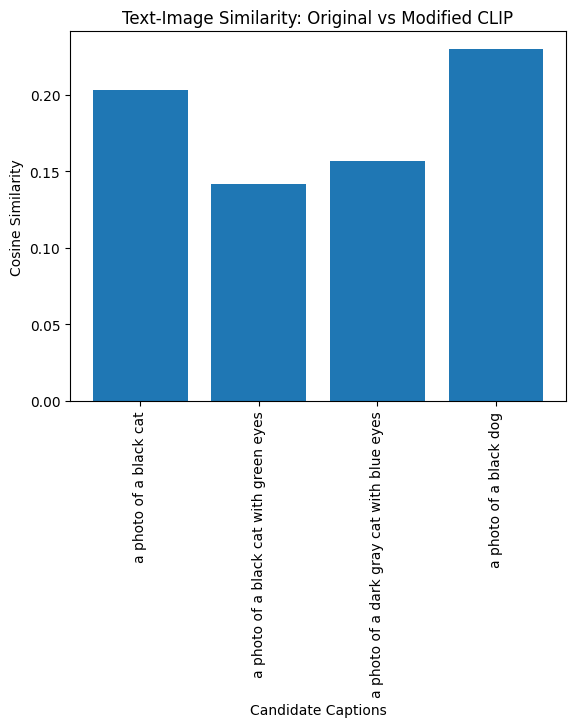

In [228]:
# 텍스트와 이미지 임베딩 추출
image_features = modified_clip_model.get_image_features(pixel_values)
text_features = modified_clip_model.get_text_features(**text_inputs)

# 코사인 유사도 계산
similarities = cosine_similarity(image_features, text_features)

# 유사도 분포 시각화
plt.bar(candidate_captions, similarities.squeeze().tolist())
plt.ylabel("Cosine Similarity")
plt.xlabel("Candidate Captions")
plt.title("Text-Image Similarity: Original vs Modified CLIP")
plt.xticks(rotation=90)
plt.show()


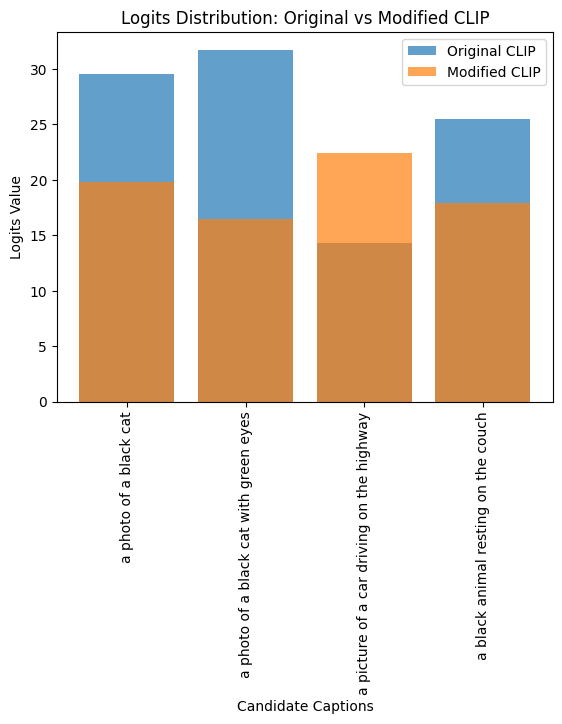

In [214]:
# logits 분포 시각화
plt.bar(candidate_captions, original_logits, alpha=0.7, label="Original CLIP")
plt.bar(candidate_captions, modified_logits, alpha=0.7, label="Modified CLIP")
plt.ylabel("Logits Value")
plt.xlabel("Candidate Captions")
plt.title("Logits Distribution: Original vs Modified CLIP")
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [28]:
# CLIP score 게산
import torch
import torch.nn.functional as F

# 이미지 임베딩 생성
pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values
image_features = clip_model.get_image_features(pixel_values)

# 캡션 임베딩 생성
print(generated_caption)
text_inputs = clip_processor(text=[generated_caption], return_tensors="pt", padding=True)
text_features = clip_model.get_text_features(**text_inputs)

# 임베딩 정규화 (벡터 길이를 1로 만듦)
image_features = F.normalize(image_features, p=2, dim=1)
text_features = F.normalize(text_features, p=2, dim=1)

# 유사도 점수 계산 (코사인 유사도)
similarity_score = (image_features @ text_features.T).item()
print(f"CLIP Similarity Score: {similarity_score}")

a photo of a dog and cat laying on a blanket 
CLIP Similarity Score: 0.25801822543144226
